In [1]:
import warnings
import logging
logging.getLogger('pydlm').setLevel(logging.WARNING)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.tsa.arima.model import ARIMA
from pydlm import dlm, trend, seasonality
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import warnings


Importing plotly failed. Interactive plots will not work.


In [2]:
data=pd.read_excel('RC_F03_12_2023_T03_12_2024.xlsx')
print(data)
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.WARNING)

     nominal       data      curs             cdx    k         ds         y
0         10 2023-12-21   88.6825  Шведская крона  236 2023-12-21   88.6825
1         10 2023-12-22   90.1821  Шведская крона  235 2023-12-22   90.1821
2         10 2023-12-23   90.9782  Шведская крона  234 2023-12-23   90.9782
3         10 2023-12-26   91.6976  Шведская крона  233 2023-12-26   91.6976
4         10 2023-12-27   91.4362  Шведская крона  232 2023-12-27   91.4362
..       ...        ...       ...             ...  ...        ...       ...
231       10 2024-11-27   95.8540  Шведская крона    5 2024-11-27   95.8540
232       10 2024-11-28   98.6276  Шведская крона    4 2024-11-28   98.6276
233       10 2024-11-29  100.0926  Шведская крона    3 2024-11-29  100.0926
234       10 2024-11-30   98.4446  Шведская крона    2 2024-11-30   98.4446
235       10 2024-12-03   98.2802  Шведская крона    1 2024-12-03   98.2802

[236 rows x 7 columns]


In [3]:
def find_rmse(test, pred): #среднеквадратичное отклонение
    return np.sqrt(mean_squared_error(test, pred))**0.5

In [4]:
# Нахождение наилучшей модели
def find_model(train, test, num, part):
    data = train
    train_x = np.array(data)
    train_y = np.arange(0, len(data))

    # Линейная модель
    model = LinearRegression().fit(train_y.reshape(-1, 1), train_x)
    trend_l = model.predict(train_y.reshape(-1, 1))
    rmse_l = find_rmse(data, trend_l)

    # Квадратичная регрессия
    coefficients_quad = np.poly1d(np.polyfit(train_y, train_x, 2))
    trend_quad = coefficients_quad[2] * train_y ** 2 + coefficients_quad[1] * train_y + coefficients_quad[0]
    rmse_quad = find_rmse(data, trend_quad)

    # Экспоненциальная регрессия
    coefficients_exp = np.polyfit(train_y, np.log(train_x), 1)
    a_exp = np.exp(coefficients_exp[1])
    b_exp = coefficients_exp[0]
    trend_exp = a_exp * np.exp(b_exp * train_y)
    rmse_exp = find_rmse(data, trend_exp)

    # Полином Чебышева
    degree_chebyshev = 3  # Задаем степень полинома Чебышева
    coefficients_chebyshev = np.polynomial.chebyshev.chebfit(train_y, train_x, degree_chebyshev)
    # Считаем по МНК
    trend_cheb = np.polynomial.chebyshev.chebval(train_y, coefficients_chebyshev)
    rmse_cheb = find_rmse(data, trend_cheb)

    # Вывод
    rmse_values = [rmse_l, rmse_quad, rmse_exp, rmse_cheb]
    trend_i = [trend_l, trend_quad, trend_exp, trend_cheb]
    models = ['Линейная', 'Квадратичная', 'Экспоненциальная', 'Полином Чебышева']
    plt.plot(np.arange(len(data)), data, label='original', linestyle="--", color="black")
    for i in range(4):
        cur_model = models[i]
        cur_trend = trend_i[i]
        print(f'{cur_model} {num} - {part} trend')
        print("Среднеквадратичное отклонение тренда:", rmse_values[i])
        plt.plot(np.arange(len(data)), cur_trend, label=f'{cur_model}')
    plt.xlabel('index')
    plt.ylabel('y')
    title = f'Тренды {num} - {part} trend'
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig(f'{title}.png')
    plt.close()

    best_model = models[np.argmin(rmse_values)]
    best_trend = trend_i[np.argmin(rmse_values)]
    return best_model, best_trend, min(rmse_values)

In [5]:
def find_season(data, num, part):
    train_x = np.array(data)
    train_y = np.arange(0, len(data))
    # Выполнение дискретного преобразования Фурье
    fft_result = np.fft.rfft(train_x)
    # Получение амплитуды и частоты
    amplitude = np.abs(fft_result)
    frequency = np.fft.rfftfreq(len(data), 1)
    # Отбрасываем отрицательные частоты и их амплитуды
    positive_freq = frequency >= 0
    frequency = frequency[positive_freq]
    amplitude = amplitude[positive_freq]*2
    # Визуализация результатов
    plt.figure()
    plt.plot(frequency[1:], amplitude[1:])
    plt.xlabel('frequency')
    plt.ylabel('amplitude')
    days = len(data)
    plt.title(f'Fourier {num} - seasonality {part}')
    plt.grid()
    plt.savefig(f'Fourier {num} - seasonality {part}.png')
    plt.close()

In [6]:
def find_resid(data, num, part):
    # Тест Шапиро-Уилка на нормальность
    shapiro_test = stats.shapiro(data)
    print("\nДлина мерного интервала: ",len(data))
    print("Статистика теста Шапиро-Уилка:", shapiro_test.statistic)
    print("p-значение теста Шапиро-Уилка:", shapiro_test.pvalue)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q plot {num} - {part} normality')
    plt.xlabel('theoretical')
    plt.ylabel('data')
    plt.grid()
    plt.savefig(f'Q-Q plot {num} - {part} normality.png')
    plt.close()

In [7]:
# Несколько графиков сразу
def plot_all(x, y, legend, name):
    fig, ax = plt.subplots()
    ax.set_xlabel('ds')
    ax.set_ylabel('y')
    plt.figure(figsize=(10,6))
    ax.grid()
    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    for i in range(len(x)):
        plt.plot(x[i], y[i], label=legend[i%4])
    plt.legend(loc="upper left")
    plt.title(name)
    plt.savefig("{}.png".format(name))
    plt.close()

In [8]:
def remainders(x,y,legend,name):
    fig, ax = plt.subplots()
    ax.set_xlabel('ds')
    ax.set_ylabel('y')
    ax.grid()
    for i in range(len(x)):
        plt.plot(x[i], y[i], label=legend[i])
    plt.legend(loc="upper left")
    plt.title(name)
    plt.savefig("{}.png".format(name))
    plt.close()

In [9]:
def bsts(train, test, season):
    m_fit = dlm(train) + trend(degree=2, discount=0.8, name='linear_trend')+ seasonality(len(test)+season, discount=0.9)
    m_fit.fit()
    model_values = m_fit.getMean(filterType='backwardSmoother')
    forecast = m_fit.predictN(date=m_fit.n-1, N=len(test))[0]
    rmse = np.sqrt(mean_squared_error(train, model_values)) ** 0.5
    return model_values, forecast, rmse

In [10]:
def Arima(train, test, order):
    m_fit = ARIMA(train, order=order).fit()
    forecast = m_fit.get_forecast(steps=len(test))
    mean = forecast.predicted_mean
    rmse = np.sqrt(mean_squared_error(train, m_fit.fittedvalues)) ** 0.5
    return m_fit.fittedvalues, mean, rmse, m_fit.aic

In [11]:
# Prophet модель
class Model:
    def __init__(self, time_series, period, fourier):
        self.model_obj = Prophet(daily_seasonality=False,
                                 weekly_seasonality=False,
                                 yearly_seasonality=False)
        self.model_obj.add_seasonality(name="monthly", period=period, fourier_order=fourier)
        self.model_obj.fit(time_series)
    def forecast(self, count_elements):
        future = self.model_obj.make_future_dataframe(periods=count_elements, freq="D", include_history=False)
        predict = self.model_obj.predict(future)
        return predict
    def model(self):
        future = self.model_obj.make_future_dataframe(periods=0, freq="D", include_history=True)
        predict = self.model_obj.predict(future)
        return predict


Значений в выборке 236
== обучающая выборка 0.25
= 153 - 211
Линейная 2 - 0.25 trend
Среднеквадратичное отклонение тренда: 1.2125955661224608
Квадратичная 2 - 0.25 trend
Среднеквадратичное отклонение тренда: 1.1601653117926605
Экспоненциальная 2 - 0.25 trend
Среднеквадратичное отклонение тренда: 1.2172558704419618
Полином Чебышева 2 - 0.25 trend
Среднеквадратичное отклонение тренда: 1.1435948489622536

Длина мерного интервала:  59
Статистика теста Шапиро-Уилка: 0.9480568724592411
p-значение теста Шапиро-Уилка: 0.013685878395371852
Params: (1, 0, 1)
rmse: 1.0697966132046646
Params: (1, 0, 1)
rmse: 1.0697966132046646
Params: (1, 0, 3)
rmse: 1.0669057377067397
Params: (1, 0, 4)
rmse: 1.0612165792218449
Params: (1, 0, 5)
rmse: 1.061067577579127
Params: (1, 0, 5)
rmse: 1.061067577579127
Params: (1, 0, 5)
rmse: 1.061067577579127
Params: (1, 0, 5)
rmse: 1.061067577579127
Params: (1, 0, 5)
rmse: 1.061067577579127
Params: (1, 0, 5)
rmse: 1.061067577579127
Params: (1, 0, 5)
rmse: 1.0610675775791

INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


Обучающие данные:
['2024-08-09T00:00:00.000000000' '2024-08-10T00:00:00.000000000'
 '2024-08-13T00:00:00.000000000' '2024-08-14T00:00:00.000000000'
 '2024-08-15T00:00:00.000000000' '2024-08-16T00:00:00.000000000'
 '2024-08-17T00:00:00.000000000' '2024-08-20T00:00:00.000000000'
 '2024-08-21T00:00:00.000000000' '2024-08-22T00:00:00.000000000'
 '2024-08-23T00:00:00.000000000' '2024-08-24T00:00:00.000000000'
 '2024-08-27T00:00:00.000000000' '2024-08-28T00:00:00.000000000'
 '2024-08-29T00:00:00.000000000' '2024-08-30T00:00:00.000000000'
 '2024-08-31T00:00:00.000000000' '2024-09-03T00:00:00.000000000'
 '2024-09-04T00:00:00.000000000' '2024-09-05T00:00:00.000000000'
 '2024-09-06T00:00:00.000000000' '2024-09-07T00:00:00.000000000'
 '2024-09-10T00:00:00.000000000' '2024-09-11T00:00:00.000000000'
 '2024-09-12T00:00:00.000000000' '2024-09-13T00:00:00.000000000'
 '2024-09-14T00:00:00.000000000' '2024-09-17T00:00:00.000000000'
 '2024-09-18T00:00:00.000000000' '2024-09-19T00:00:00.000000000'
 '2024-

INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 0 0.18338853531413368

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.8651517933576545
p-значение теста Шапиро-Уилка: 0.00423340115043541


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 1 0.18257901227615622

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.7846025232271013
p-значение теста Шапиро-Уилка: 0.00016674926156340765


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 2 0.18217862262813783

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.8603288232271036
p-значение теста Шапиро-Уилка: 0.0034201926035303636


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 3 0.18134155819416126

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.9320539092688903
p-значение теста Шапиро-Уилка: 0.10836227843121365


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 4 0.18059328935265712

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.944232269597675
p-значение теста Шапиро-Уилка: 0.20254944869191427


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 5 0.18015305065310105

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.9474684540814211
p-значение теста Шапиро-Уилка: 0.23864846683295604


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 6 0.17957847291715182

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.9505921956660917
p-значение теста Шапиро-Уилка: 0.2790530421549948


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 7 0.17914894914417928

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.9294632617278827
p-значение теста Шапиро-Уилка: 0.09483077096693245


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 8 0.178806702519702

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.8980119299736822
p-значение теста Шапиро-Уилка: 0.019537623043142414


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 9 0.1785559616868592

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.8857125740119828
p-значение теста Шапиро-Уилка: 0.010850756930105265


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 10 0.1782610016456319

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.8760868580547669
p-значение теста Шапиро-Уилка: 0.006938500581844064


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 11 0.177974987816473

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.8432100384992006
p-значение теста Шапиро-Уилка: 0.0016397152691202512


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 12 0.1777734716029025

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.7989287952143004
p-значение теста Шапиро-Уилка: 0.00028295093686032014


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 13 0.17750685122600585

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.8348840224561912
p-значение теста Шапиро-Уилка: 0.0011604938988470973


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 14 0.17731826814346402

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.8669962865841339
p-значение теста Шапиро-Уилка: 0.004596626088754216


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 15 0.17712756822696346

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.9455830893152627
p-значение теста Шапиро-Уилка: 0.21694481068833116


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 16 0.1769720853363111

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.8969287357849547
p-значение теста Шапиро-Уилка: 0.018537606069249143


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 17 0.176888104229873

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.8909765058599234
p-значение теста Шапиро-Уилка: 0.013924456099813924


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 18 0.17668377134210714

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.8372024392665333
p-значение теста Шапиро-Уилка: 0.0012767851301553857


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 19 0.17662488047539873

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.8482897257502313
p-значение теста Шапиро-Уилка: 0.0020323149724932902


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 20 0.1764693680048136

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.848258645228088
p-значение теста Шапиро-Уилка: 0.002029629626777149


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 21 0.17635615713234787

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.8910576287839036
p-значение теста Шапиро-Уилка: 0.01397845727203676


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 22 0.17632019542519378

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.9342652509227449
p-значение теста Шапиро-Уилка: 0.12143937308575148


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 23 0.1762416606925065

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.9216250526924125
p-значение теста Шапиро-Уилка: 0.0634516098636075


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 24 0.17616191724398825

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.9209472638835832
p-значение теста Шапиро-Уилка: 0.06129591040559985


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 25 0.17606812166327057

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.9367835736690161
p-значение теста Шапиро-Уилка: 0.13825952001674324


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 26 0.17600292634066098

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.9419840517554868
p-значение теста Шапиро-Уилка: 0.1805858725913534


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 27 0.17597475234712517

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.9459641844107564
p-значение теста Шапиро-Уилка: 0.22117723154976443


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 28 0.17593503415179057

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.9520633283299069
p-значение теста Шапиро-Уилка: 0.30013098030168095


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.
INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


BSTS: 29 0.17587825815349845

Длина мерного интервала:  24
Статистика теста Шапиро-Уилка: 0.7921096095569843
p-значение теста Шапиро-Уилка: 0.00021950061172738367


DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (C:\Users\artem\AppData\Roaming\Python\Python312\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
DEBUG:cmdstanpy:input tempfile: C:\Users\artem\AppData\Local\Temp\tmpgdlpig5s\68g1ur9v.json
DEBUG:cmdstanpy:input tempfile: C:\Users\artem\AppData\Local\Temp\tmpgdlpig5s\aq3vpe5g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\artem\\AppData\\Roaming\\Python\\Python312\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=11601', 'data', 'file=C:\\Users\\artem\\AppData\\Local\\Temp\\tmpgdlpig5s\\68g1ur9v.json', 'init=C:\\Users\\artem\\AppData\\Local\\Temp\\tmpgdlpig5s\\aq3vpe5g.json', 'output', 'file=C:\\Users\\artem\\AppData\\Local\\Temp\\tmpgdlpig5s\\prophet_modelxm69yh_l\\prophet_model-20241204110244.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:02:44 - cmdstanpy - INFO -

29 3 0.8082150923753462


DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\artem\AppData\Local\Temp\tmpgdlpig5s\deposglt.json
DEBUG:cmdstanpy:input tempfile: C:\Users\artem\AppData\Local\Temp\tmpgdlpig5s\7t6j4ofn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\artem\\AppData\\Roaming\\Python\\Python312\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=22209', 'data', 'file=C:\\Users\\artem\\AppData\\Local\\Temp\\tmpgdlpig5s\\deposglt.json', 'init=C:\\Users\\artem\\AppData\\Local\\Temp\\tmpgdlpig5s\\7t6j4ofn.json', 'output', 'file=C:\\Users\\artem\\AppData\\Local\\Temp\\tmpgdlpig5s\\prophet_model62iiwmvr\\prophet_model-20241204110330.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:03:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:03:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done proces

== обучающая выборка 0.5
= 94 - 211
Линейная 2 - 0.5 trend
Среднеквадратичное отклонение тренда: 1.624164874374002
Квадратичная 2 - 0.5 trend
Среднеквадратичное отклонение тренда: 1.4366042993369852
Экспоненциальная 2 - 0.5 trend
Среднеквадратичное отклонение тренда: 1.6144187698589727
Полином Чебышева 2 - 0.5 trend
Среднеквадратичное отклонение тренда: 1.35228615851217

Длина мерного интервала:  118
Статистика теста Шапиро-Уилка: 0.9463843989709484
p-значение теста Шапиро-Уилка: 0.0001358084774925045
Params: (1, 0, 1)
rmse: 1.013626811172254
Params: (1, 0, 2)
rmse: 1.0110693449714652
Params: (1, 0, 3)
rmse: 1.010880311596895
Params: (1, 0, 4)
rmse: 1.0107369733083265
Params: (1, 0, 4)
rmse: 1.0107369733083265
Params: (1, 0, 6)
rmse: 1.0027985764624074
Params: (1, 0, 7)
rmse: 0.9989203596890179
Params: (1, 0, 8)
rmse: 0.9959154340286664
Params: (1, 0, 9)
rmse: 0.9927009918166668
Params: (1, 0, 9)
rmse: 0.9927009918166668
Params: (1, 0, 9)
rmse: 0.9927009918166668
Params: (1, 0, 9)
rmse

KeyboardInterrupt: 

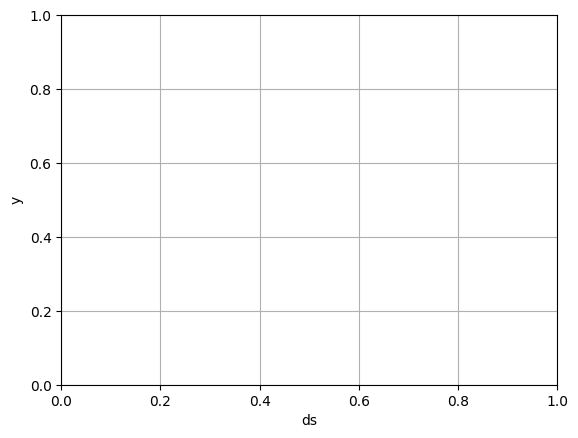

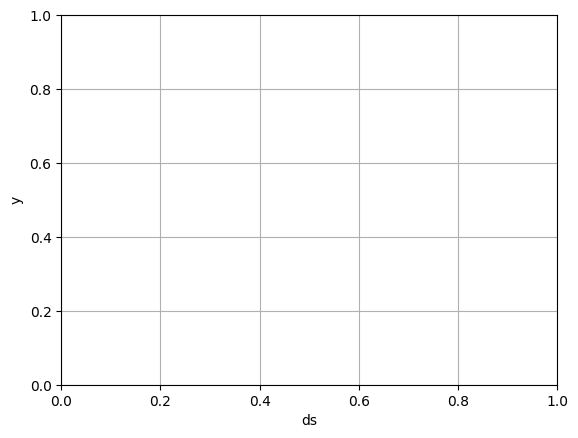

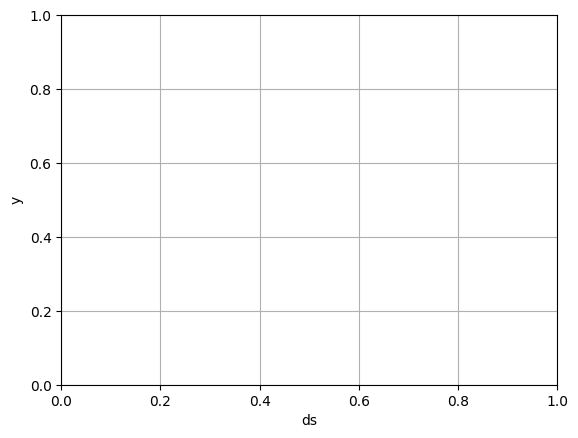

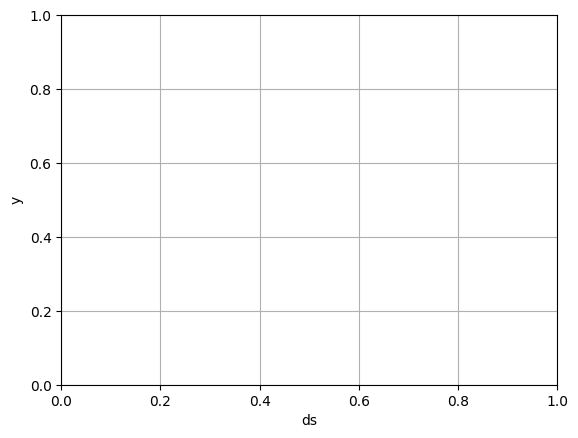

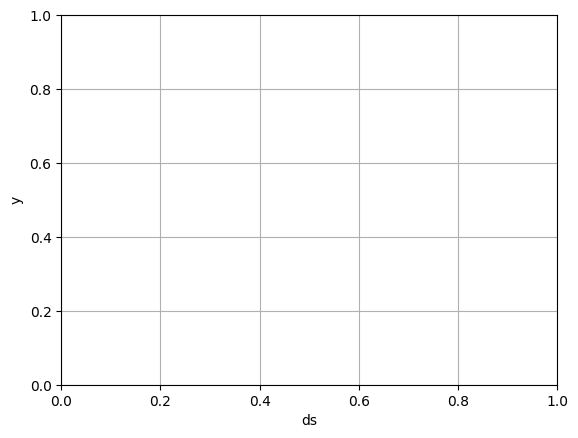

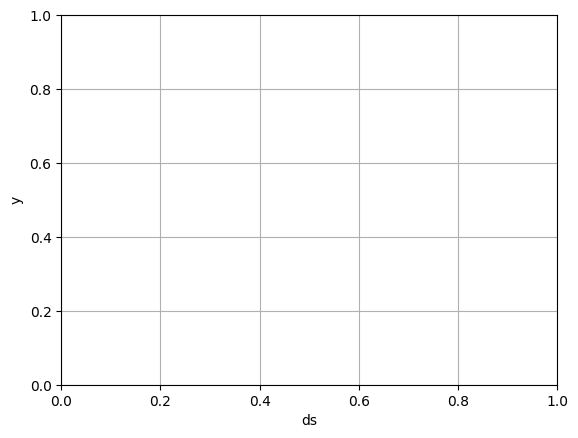

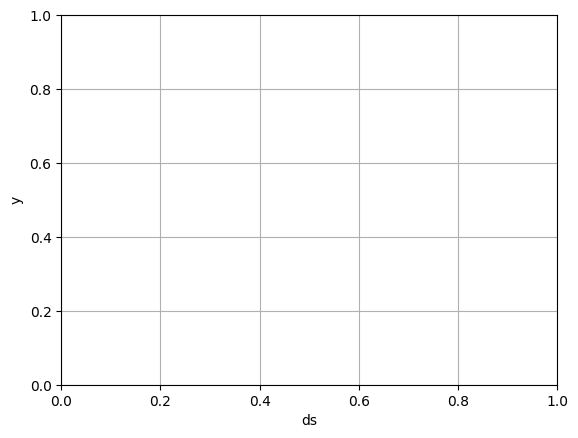

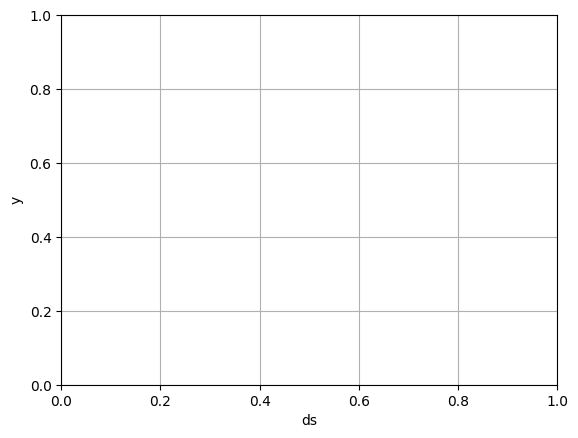

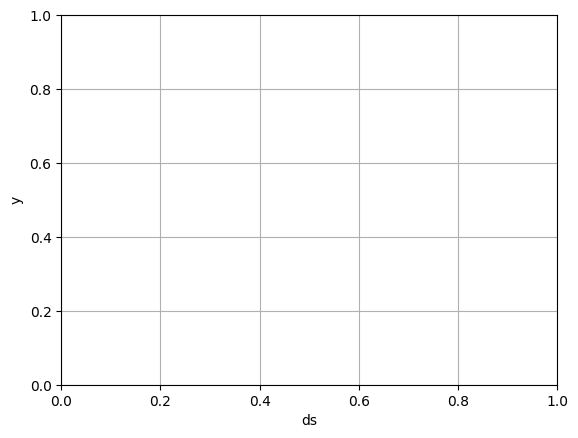

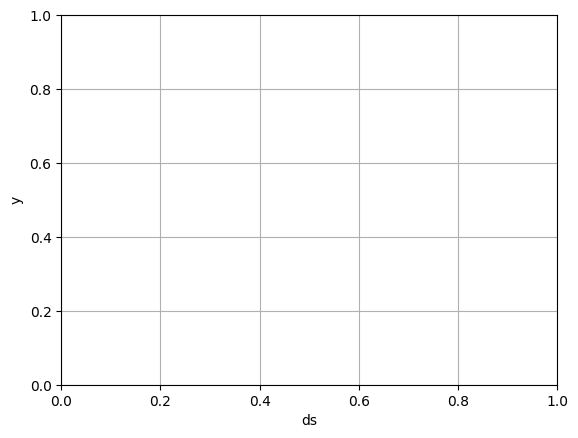

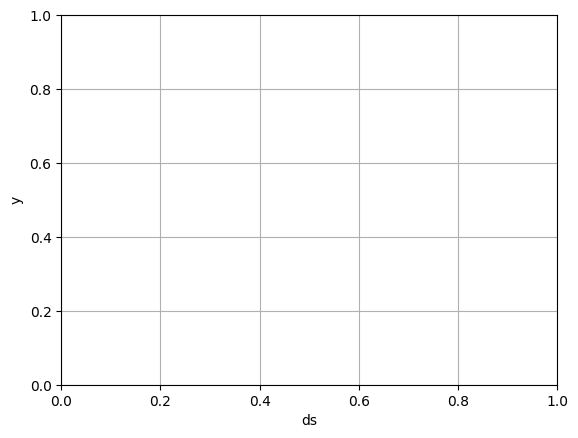

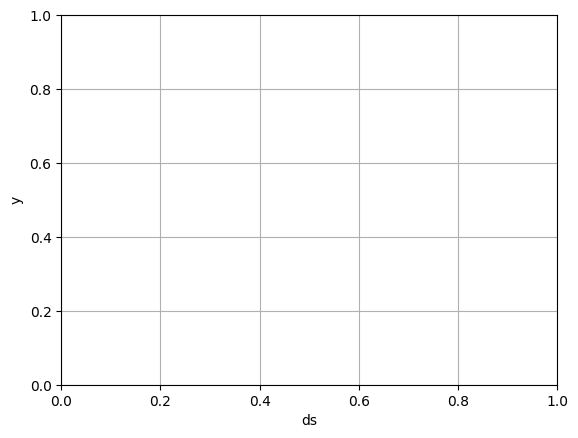

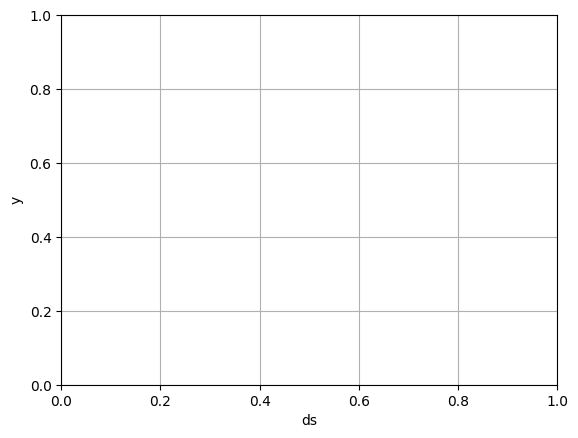

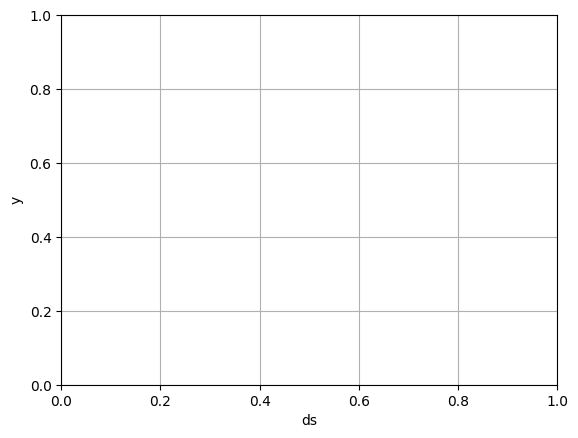

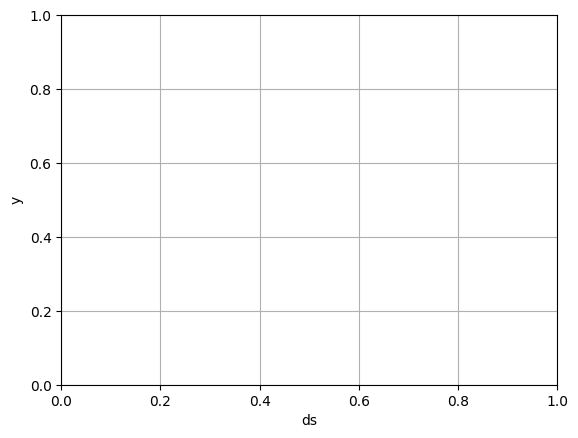

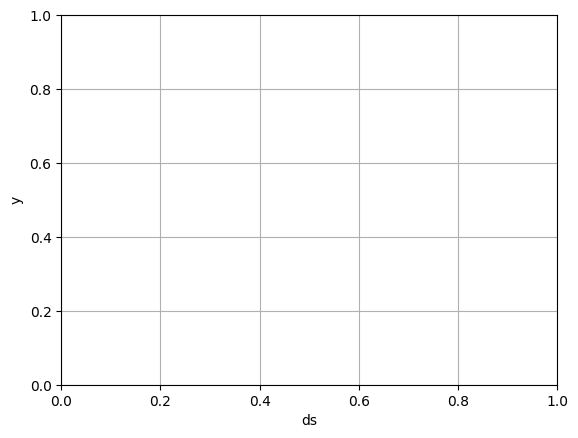

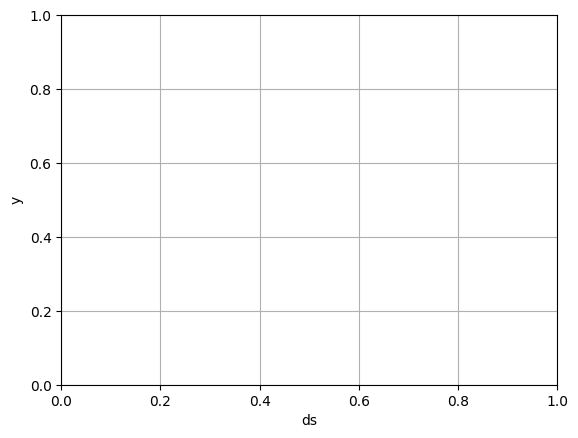

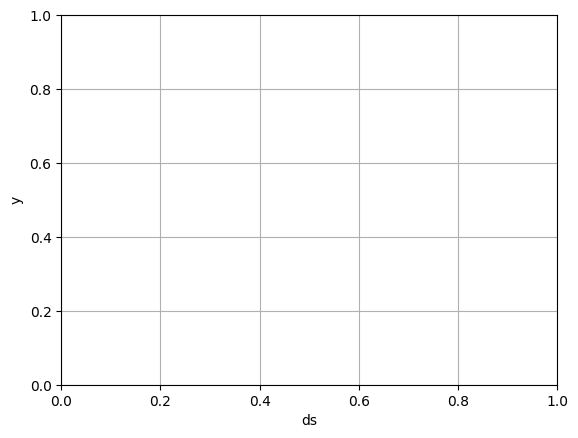

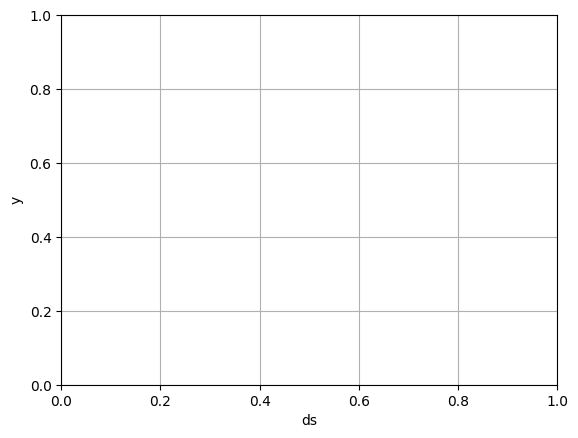

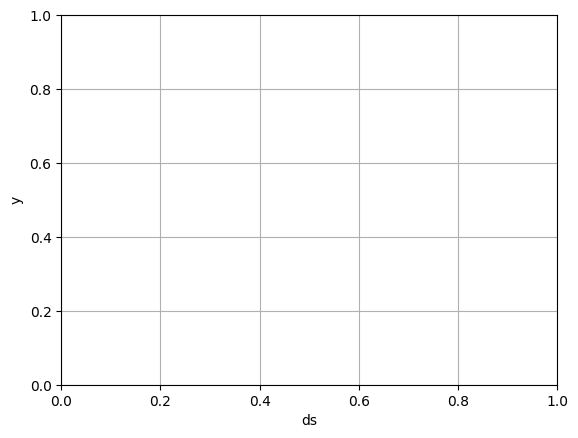

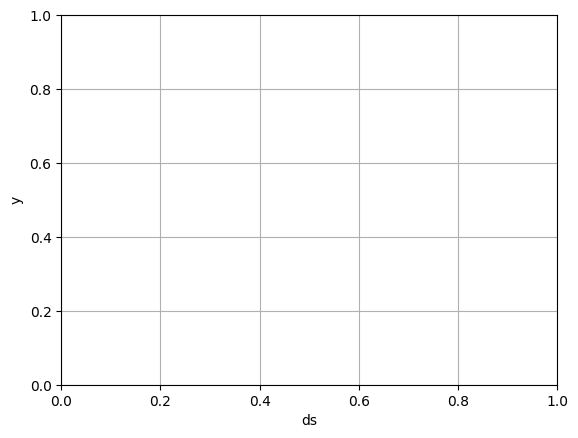

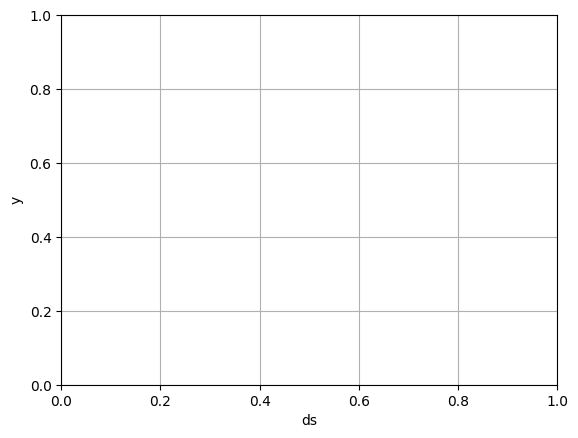

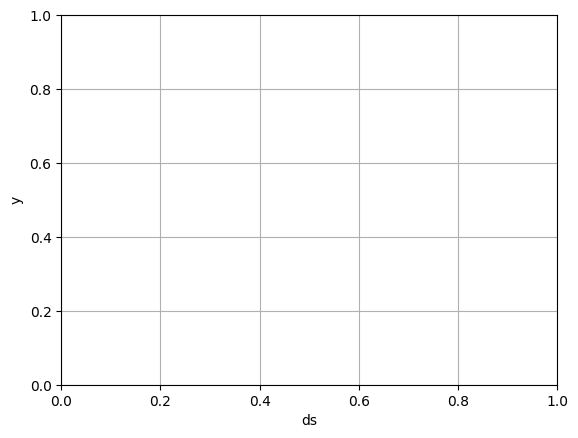

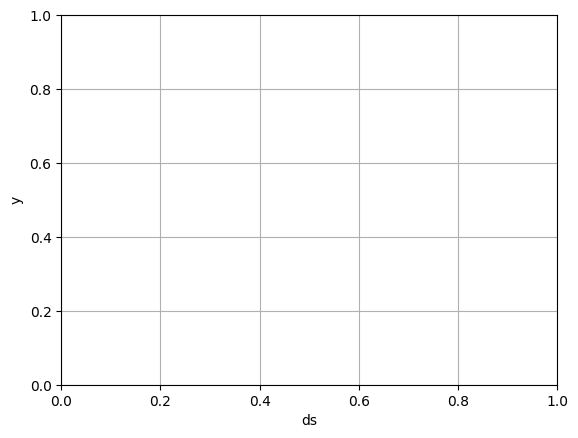

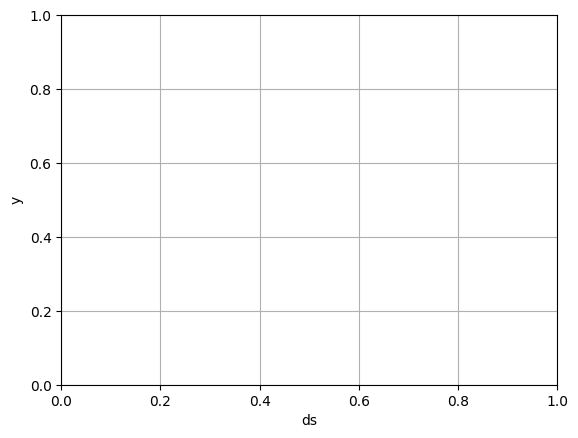

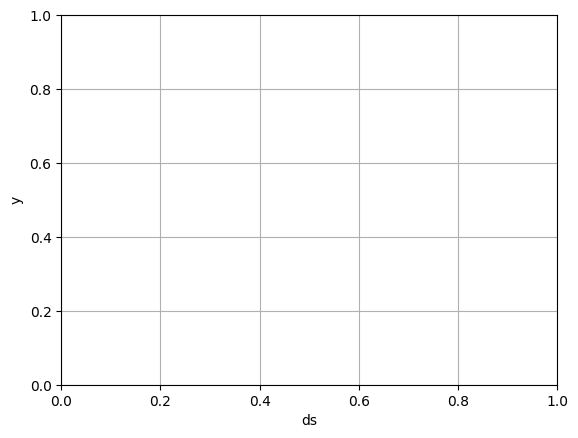

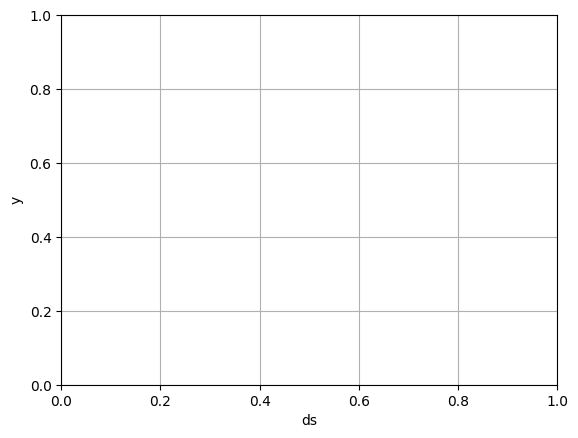

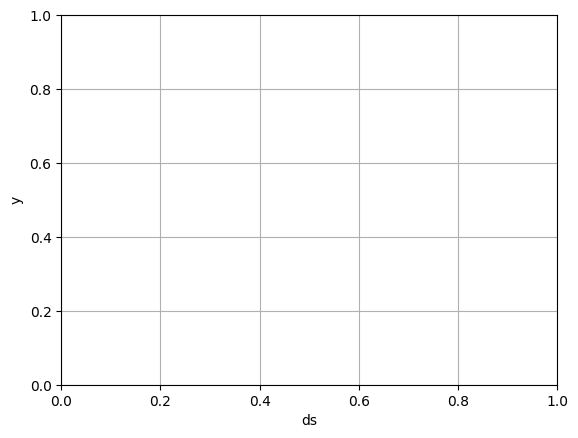

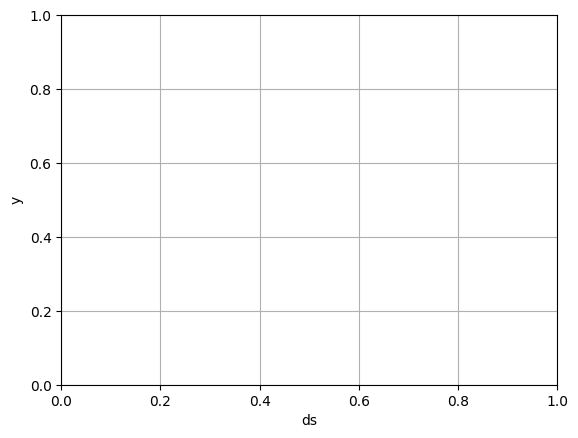

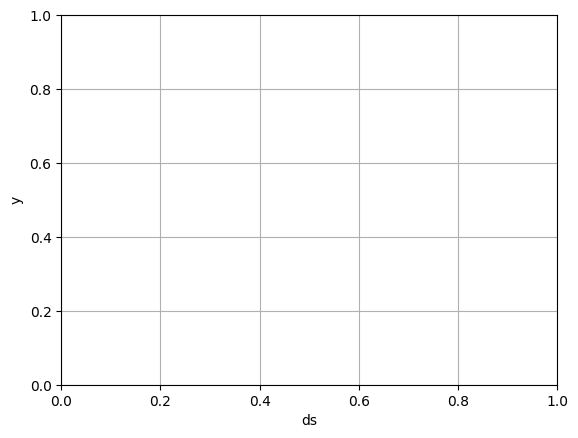

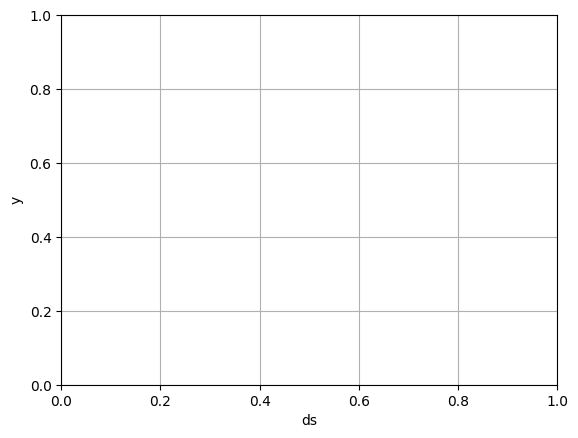

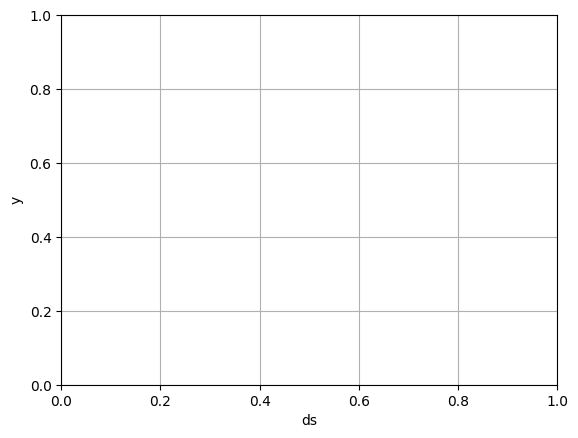

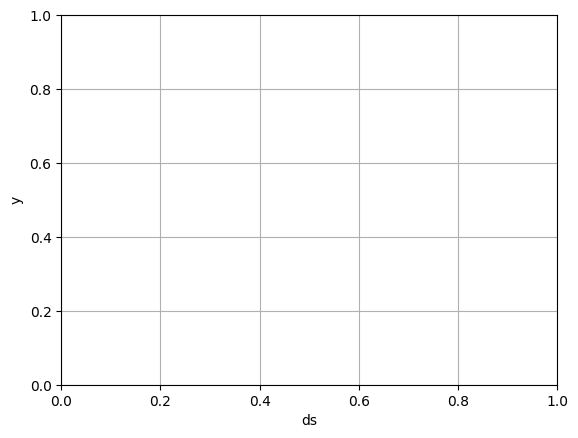

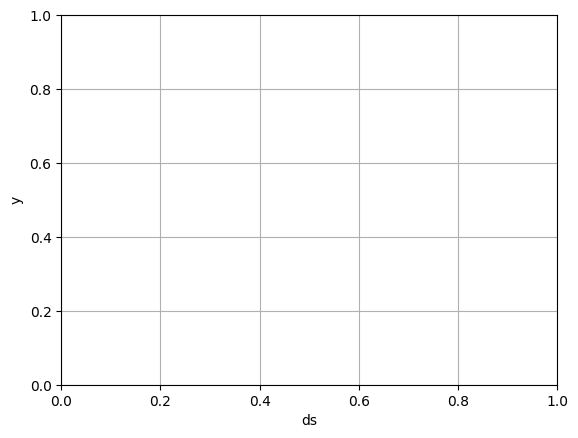

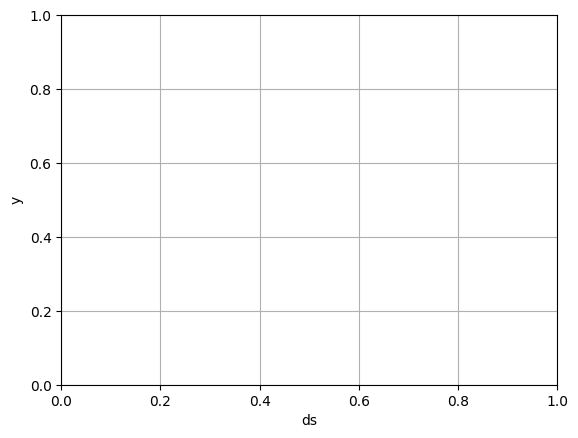

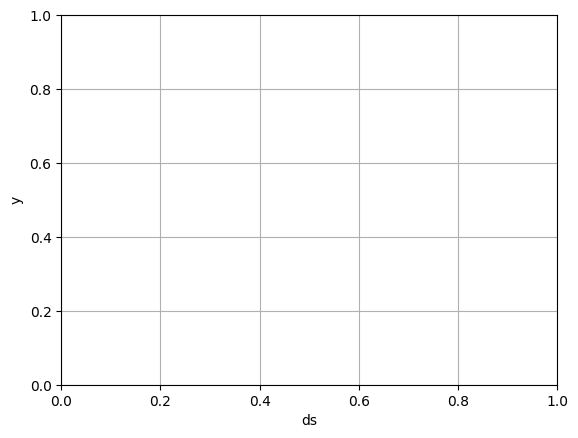

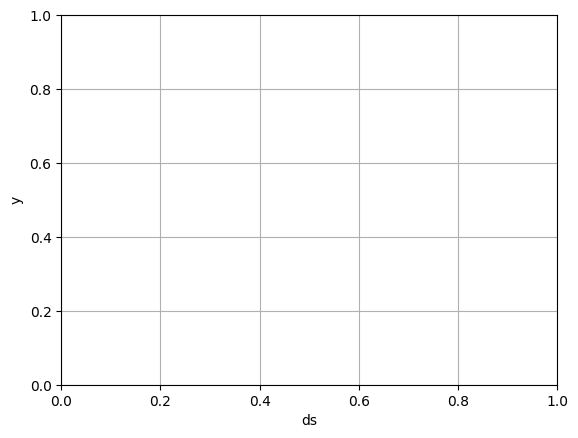

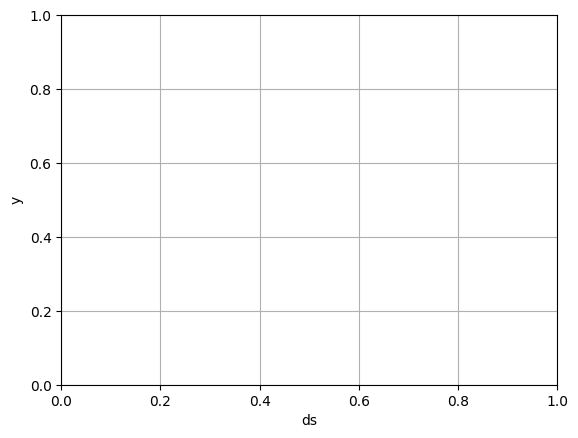

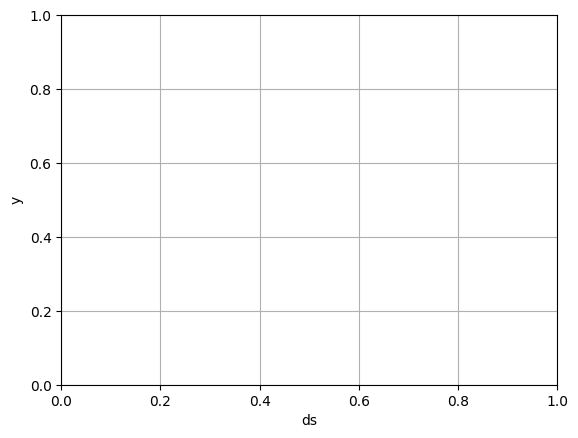

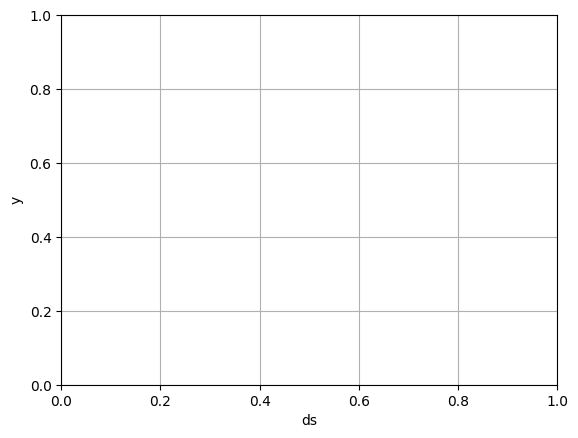

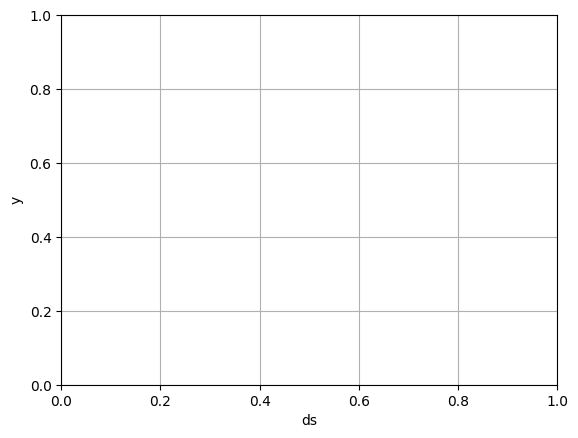

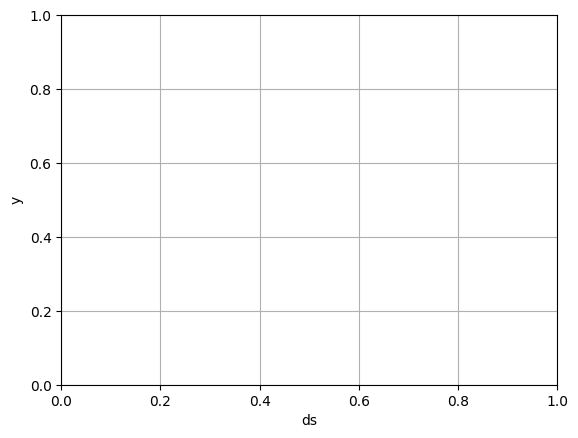

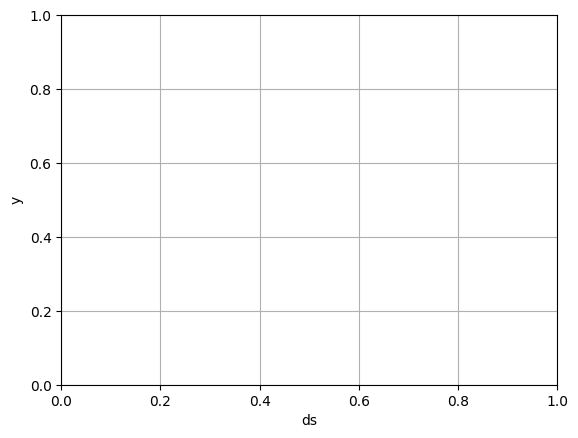

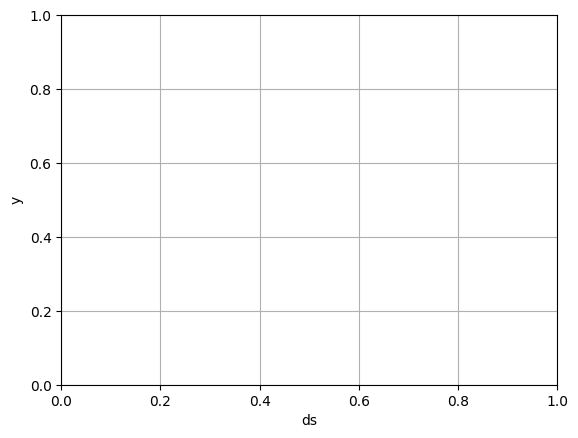

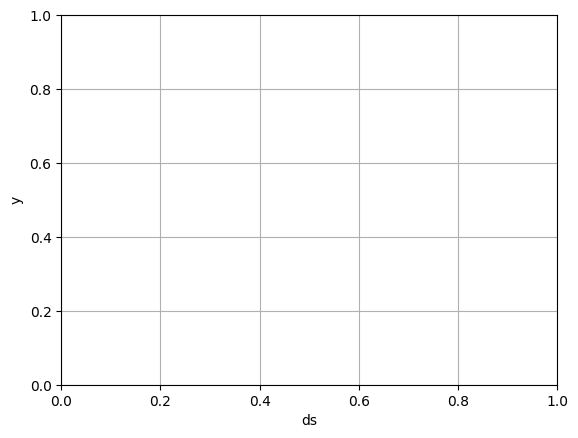

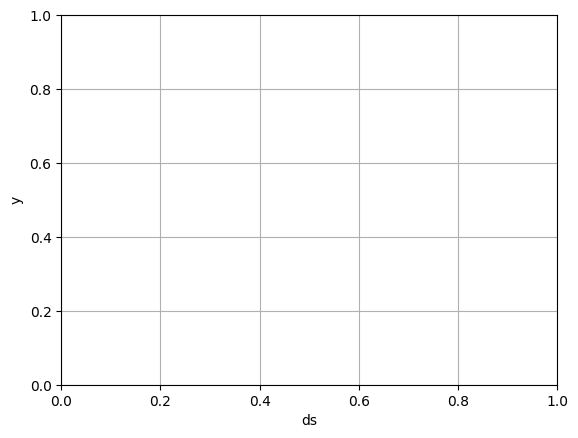

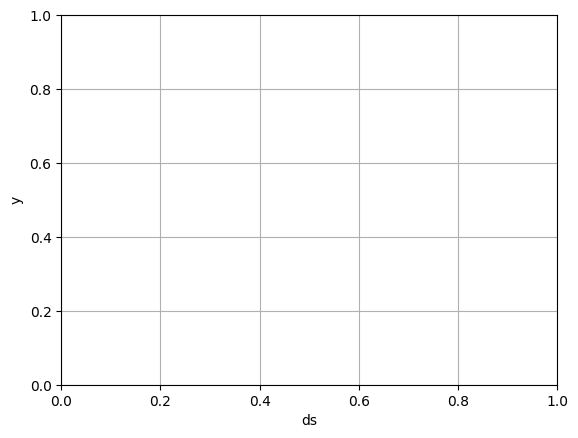

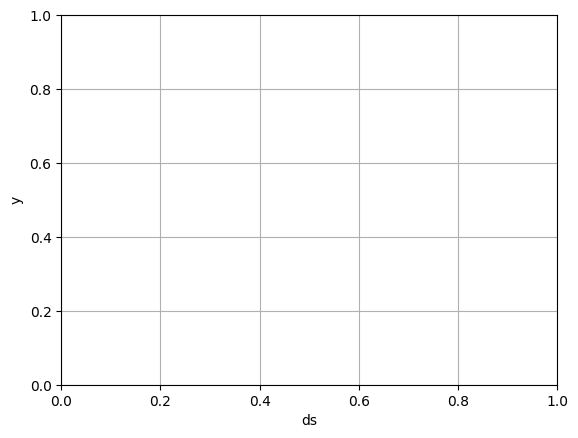

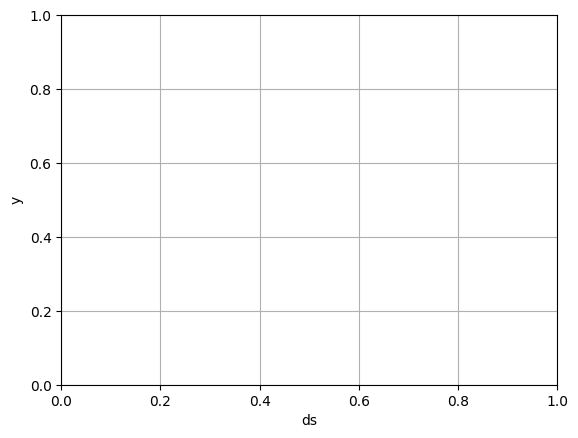

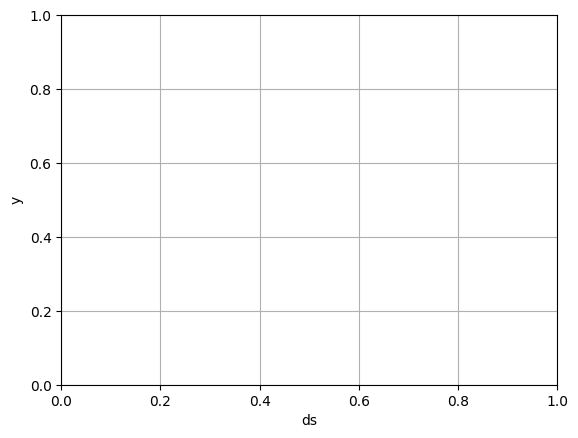

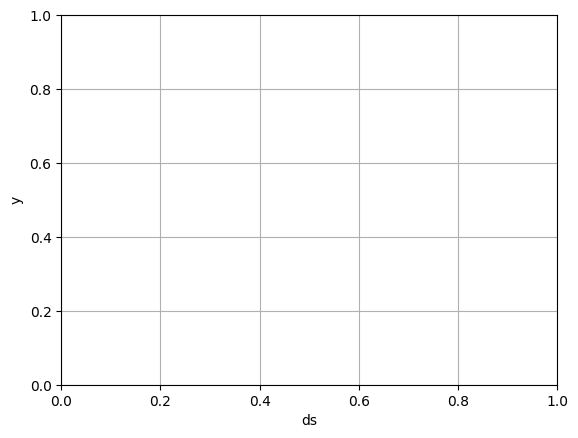

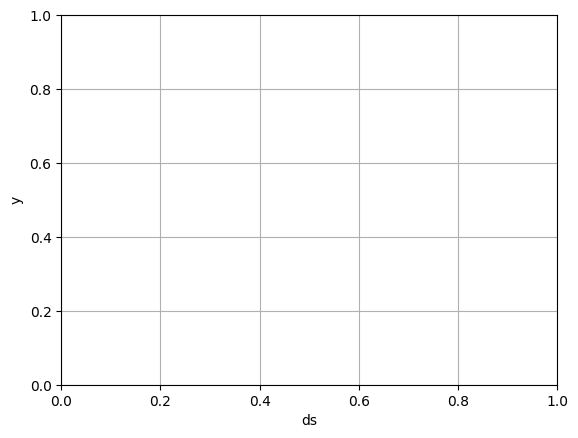

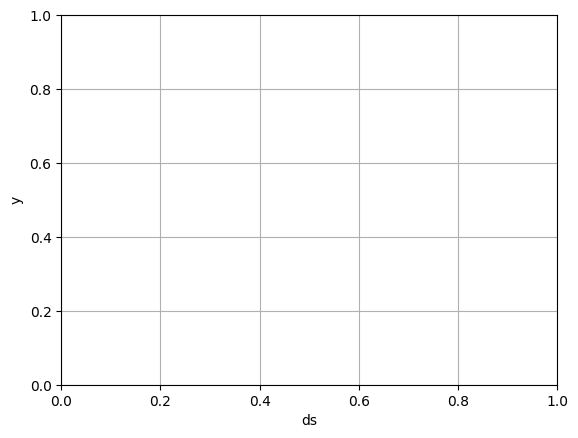

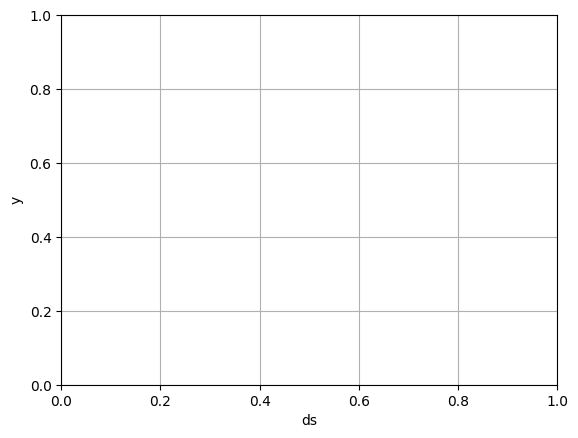

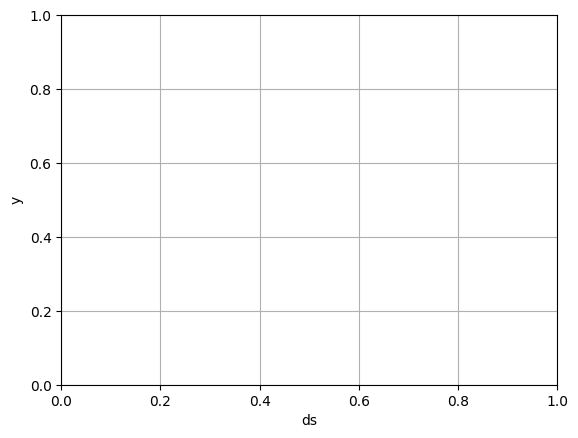

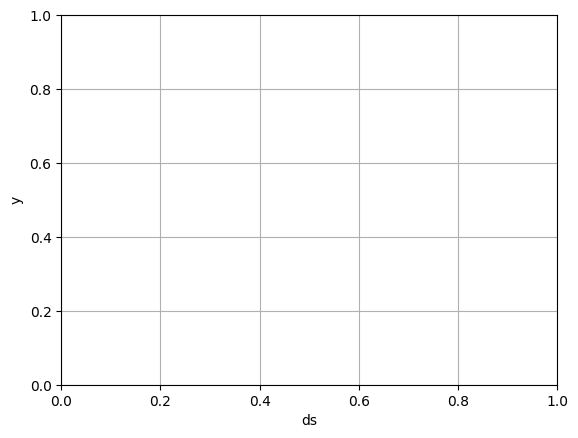

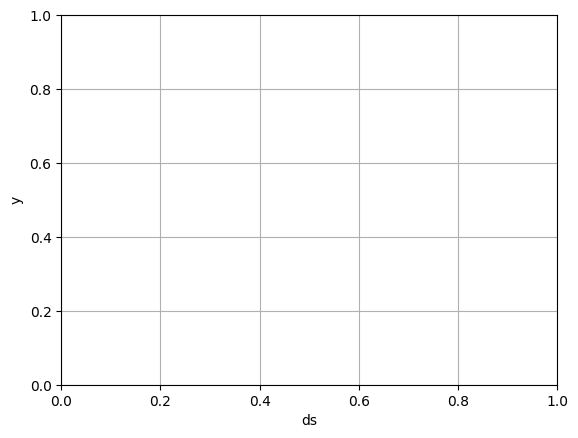

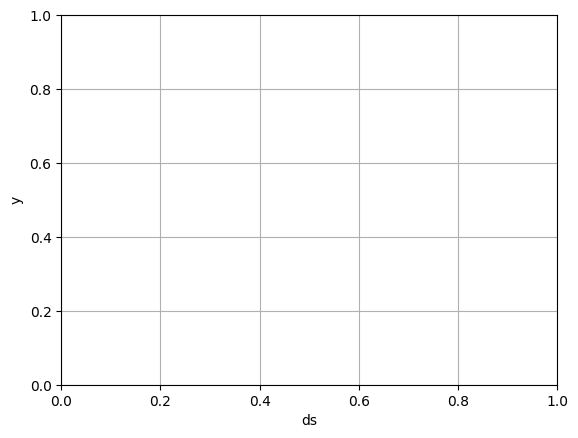

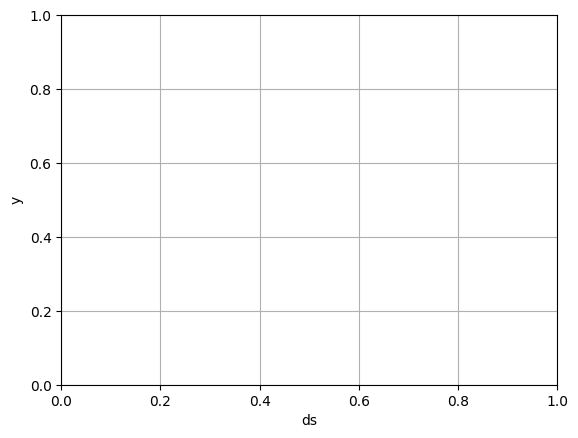

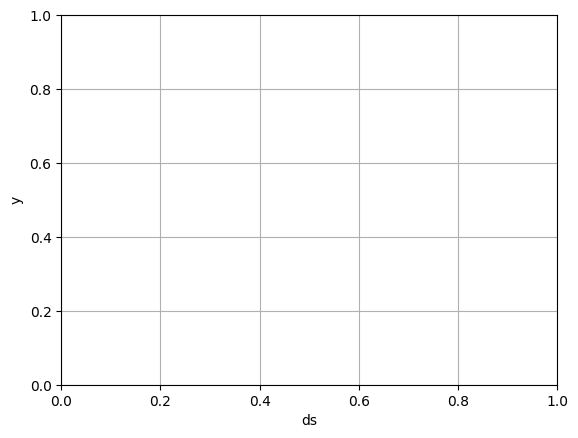

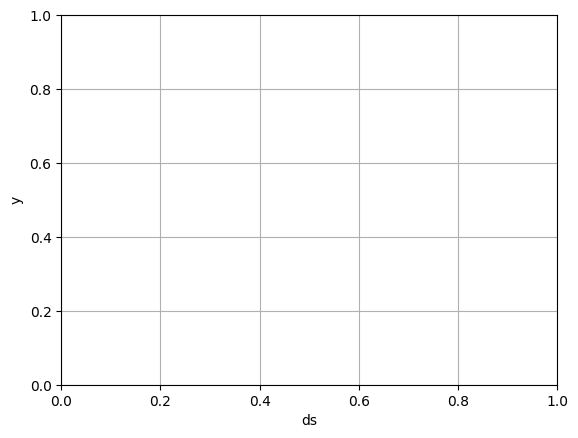

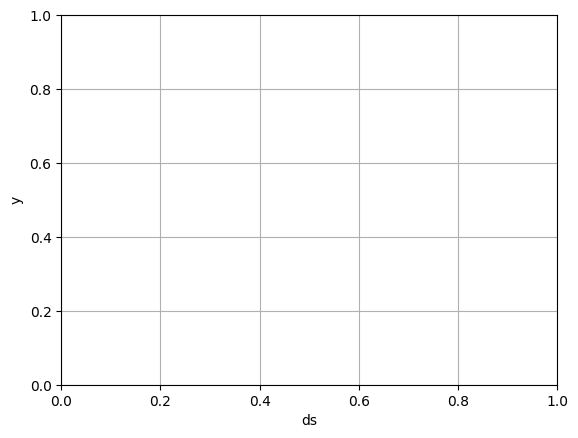

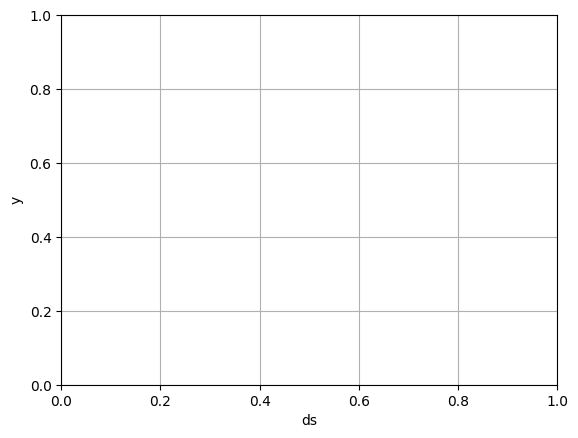

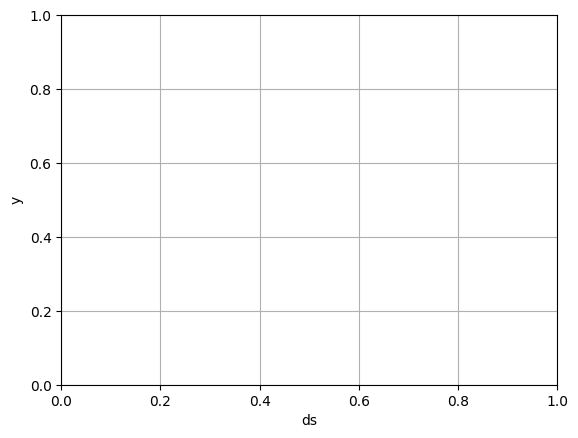

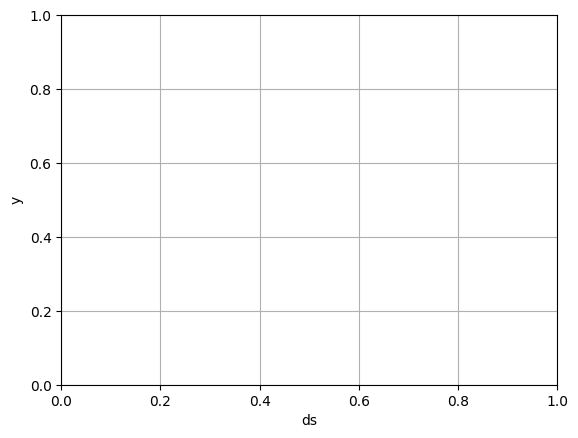

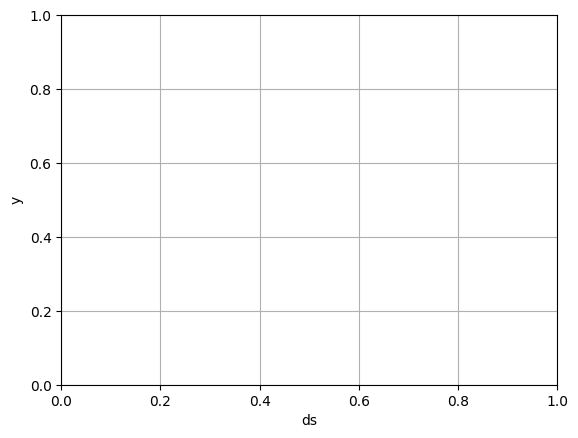

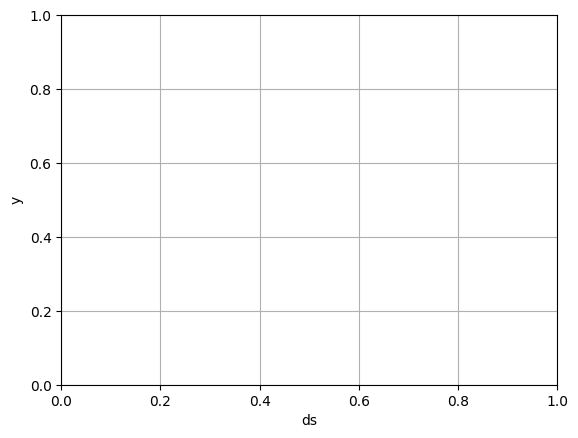

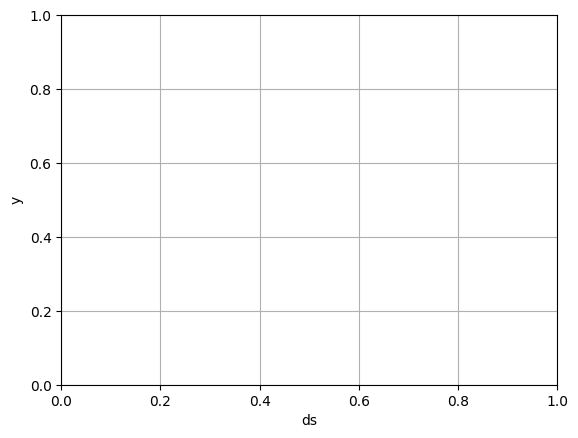

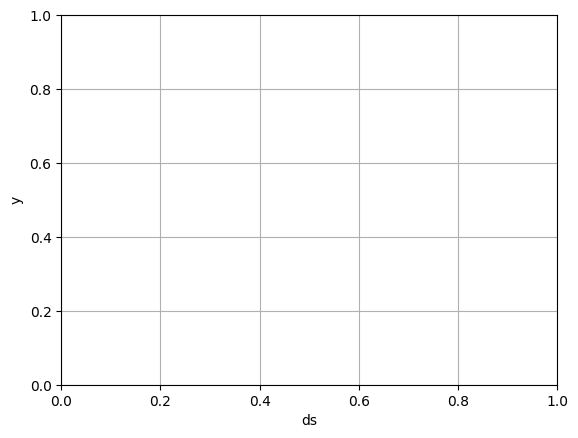

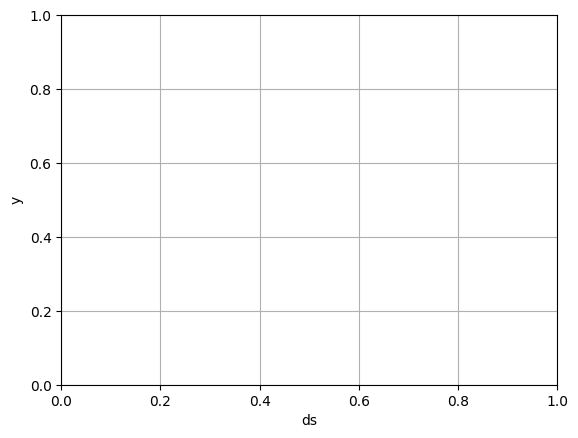

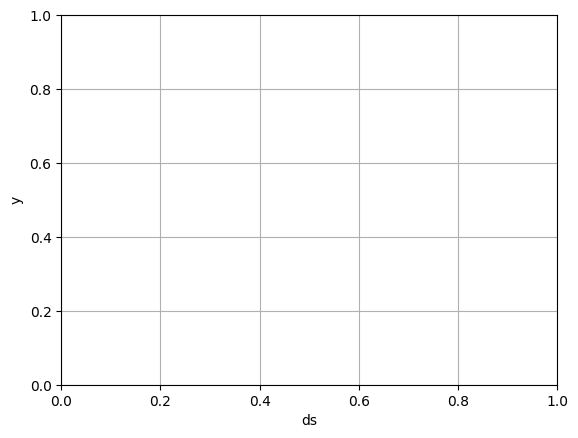

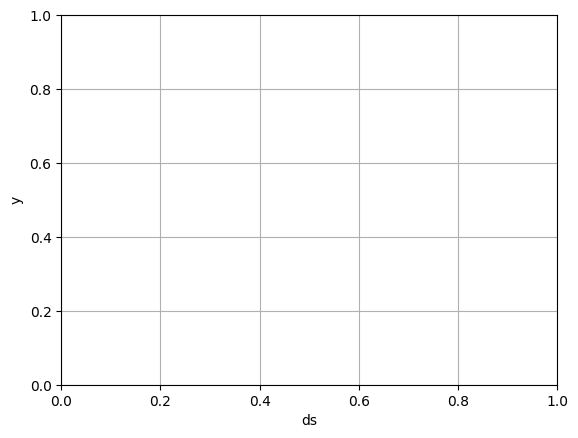

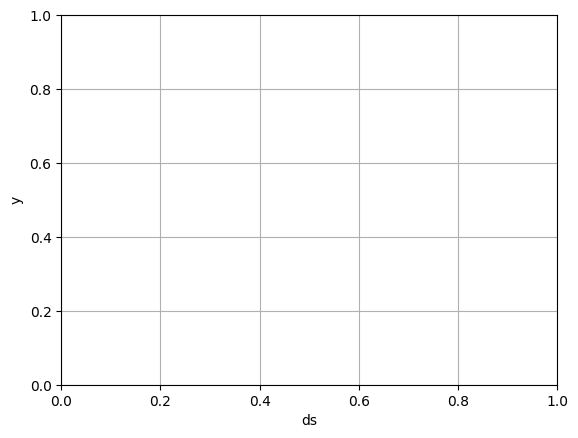

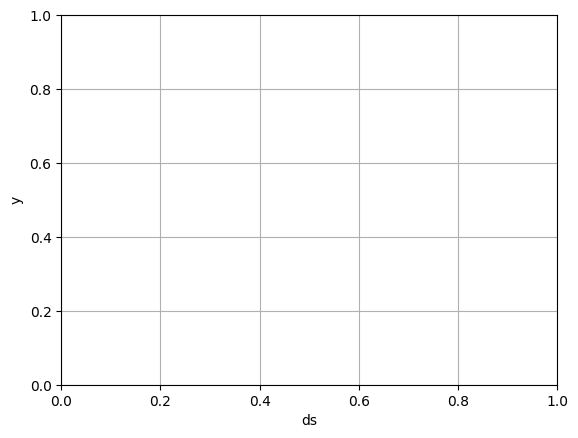

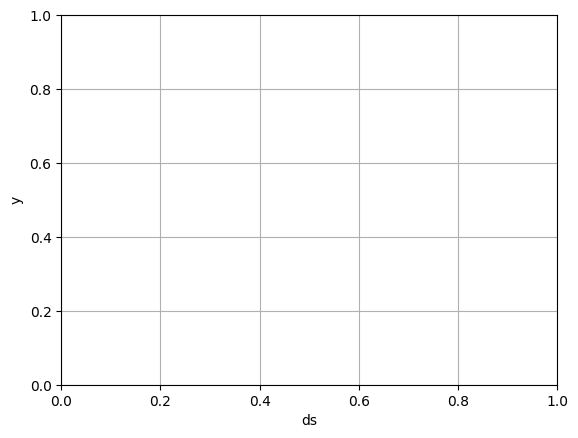

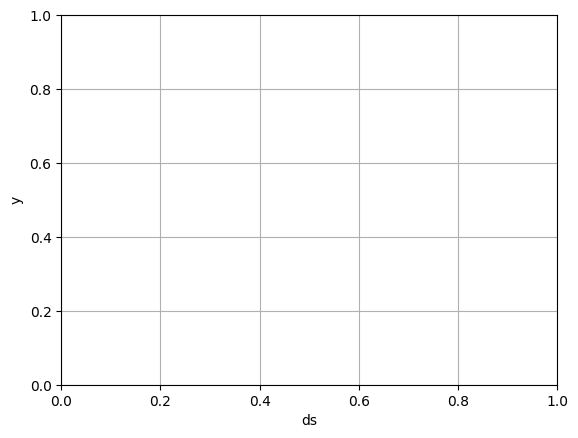

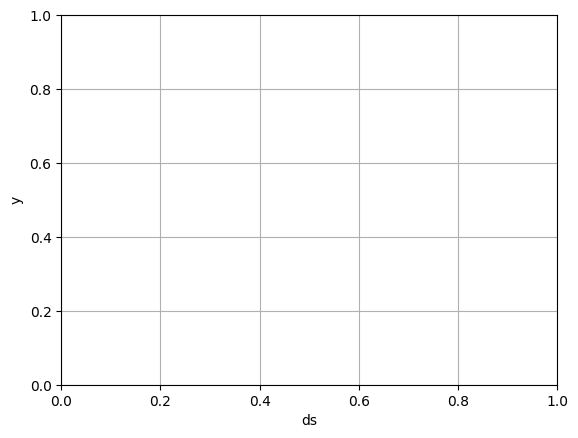

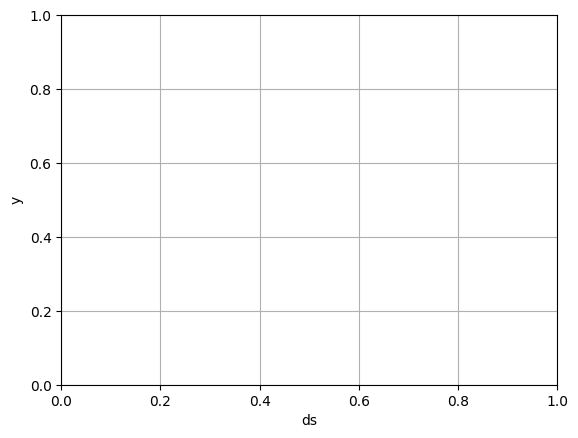

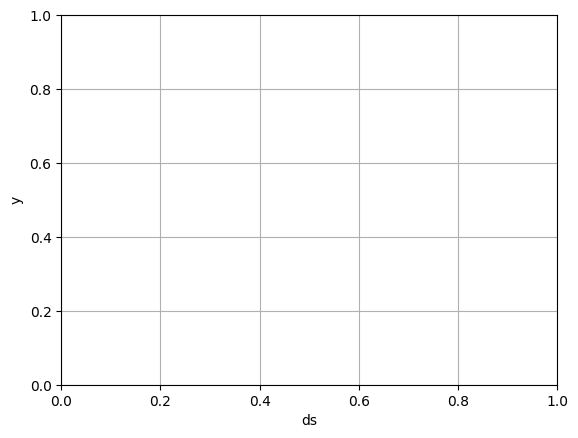

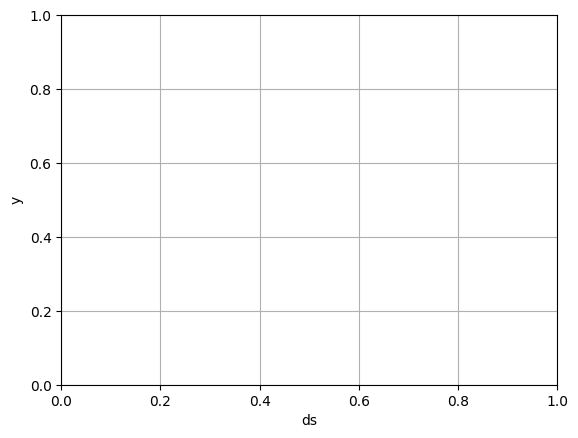

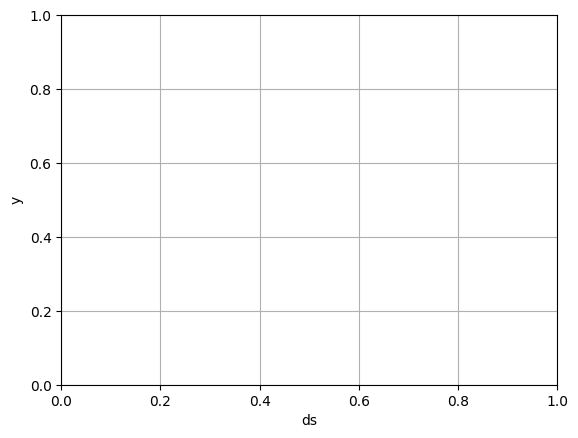

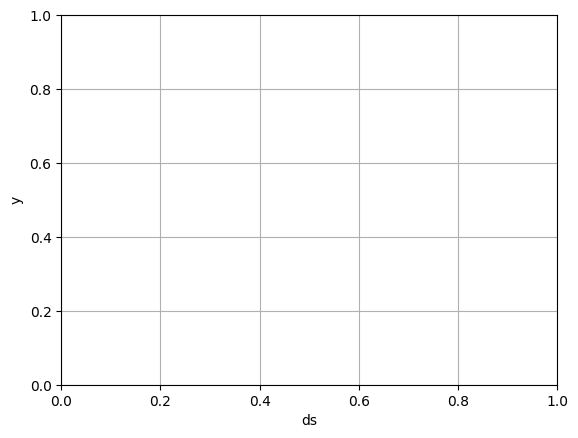

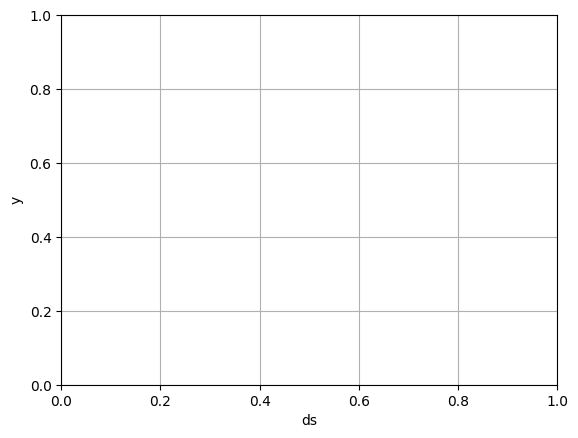

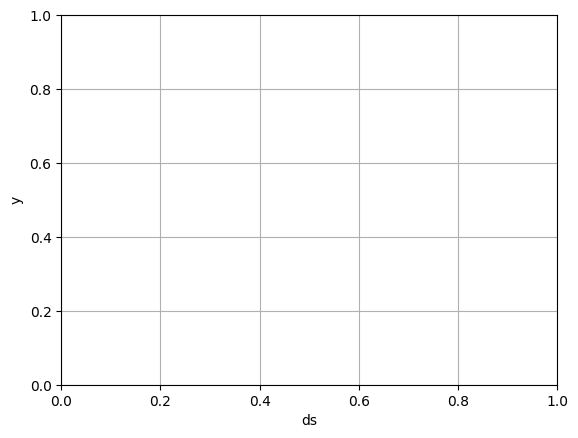

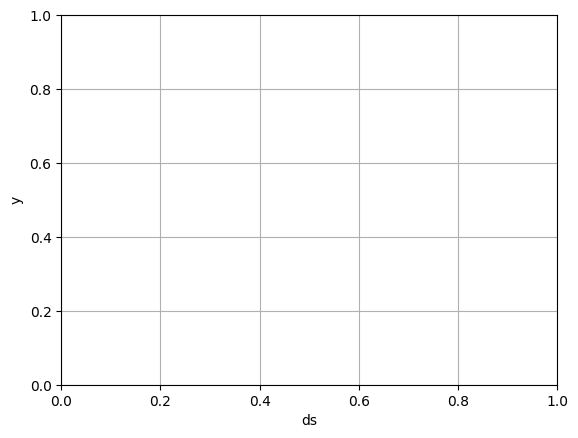

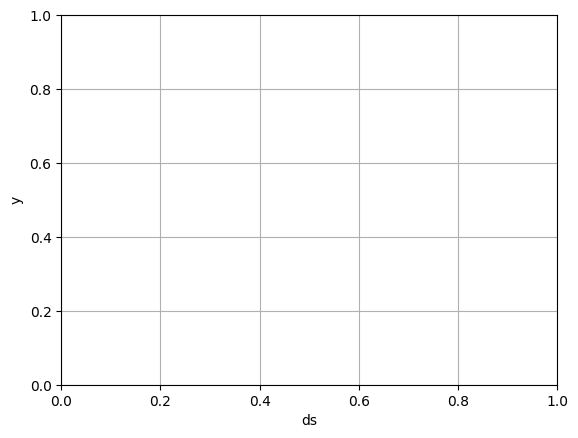

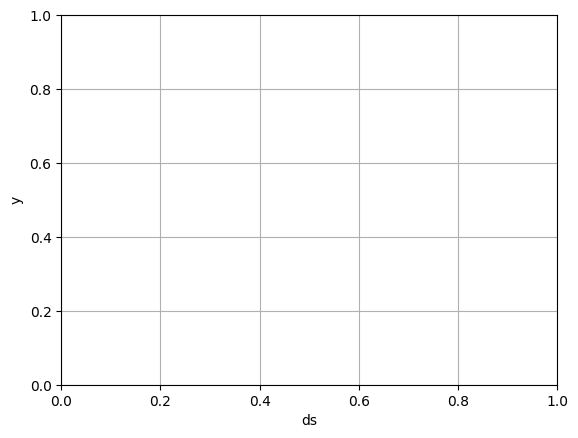

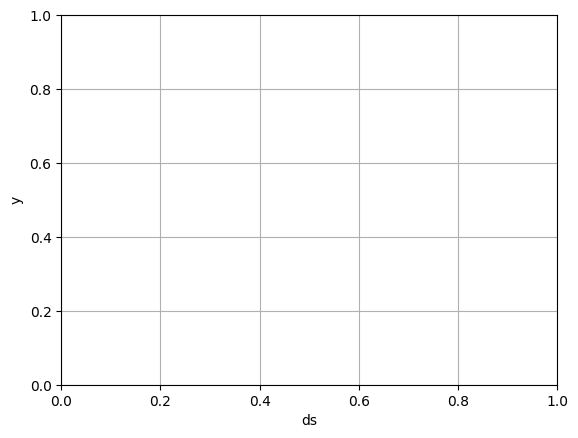

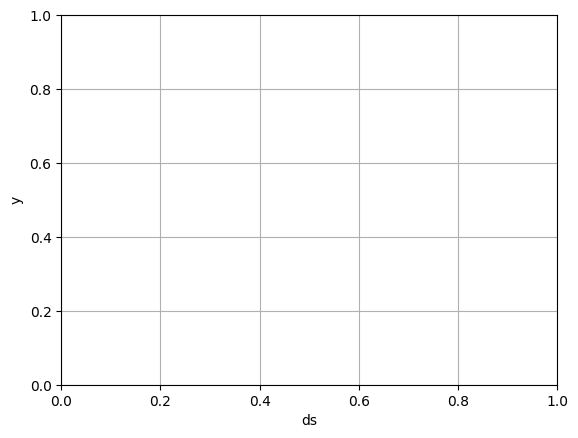

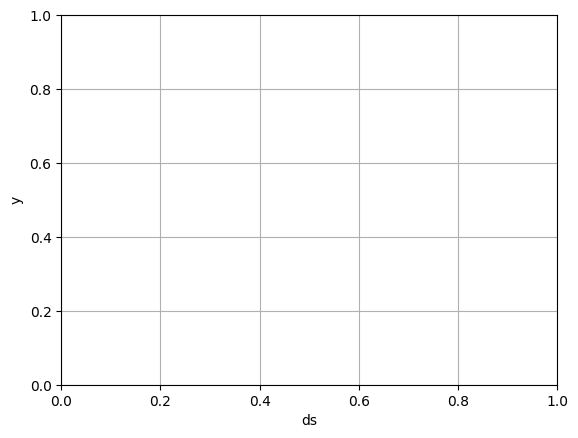

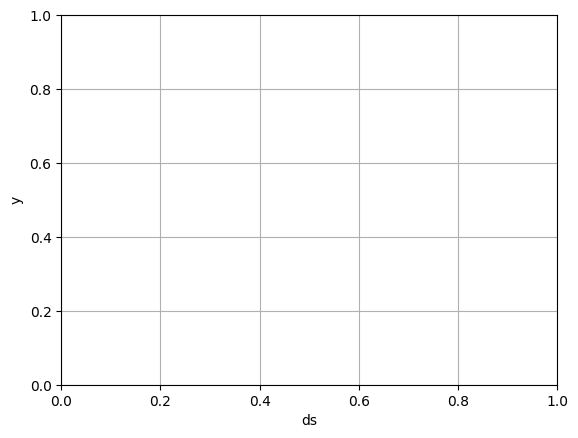

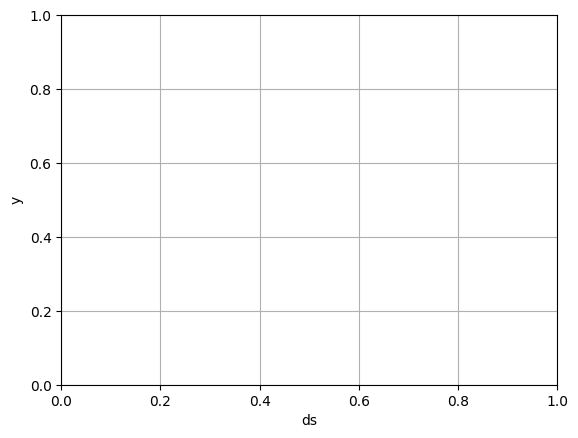

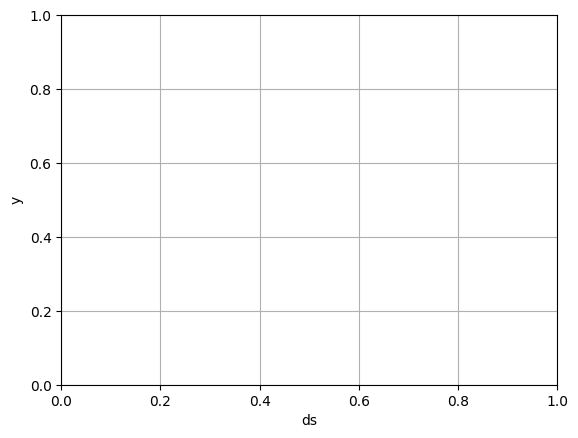

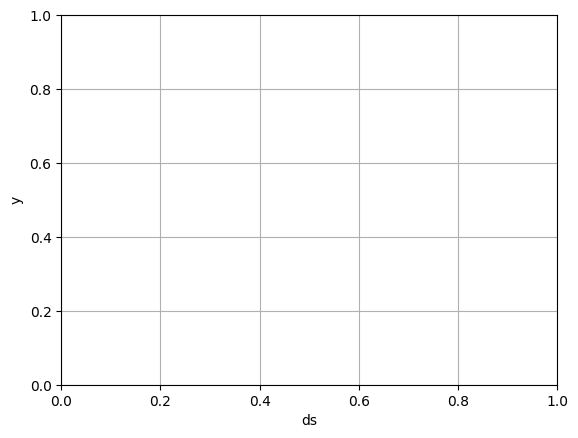

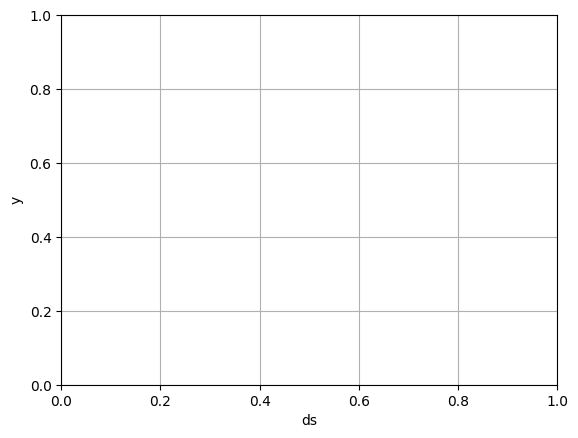

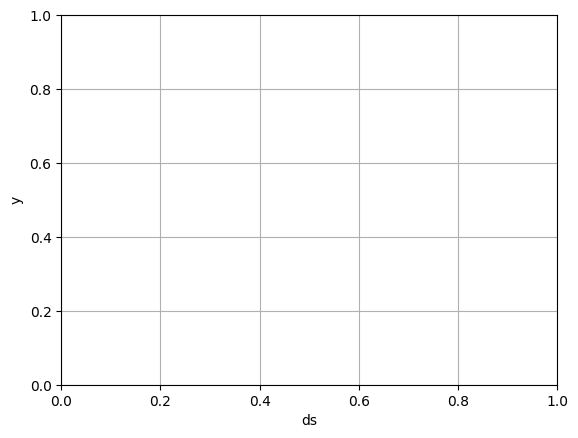

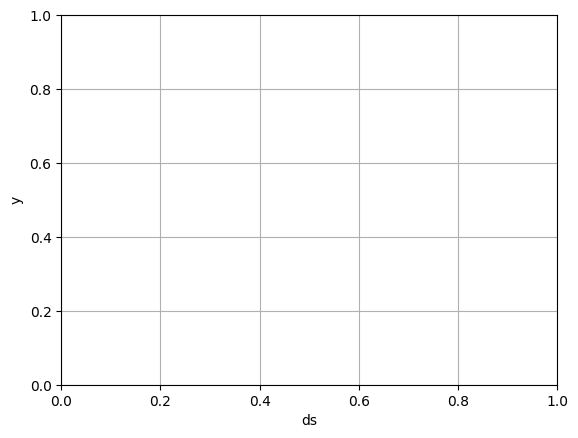

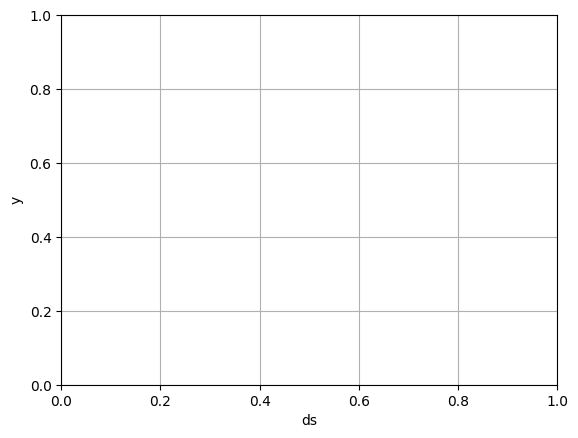

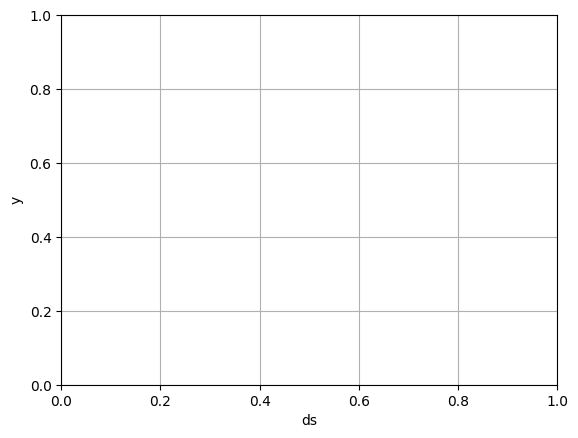

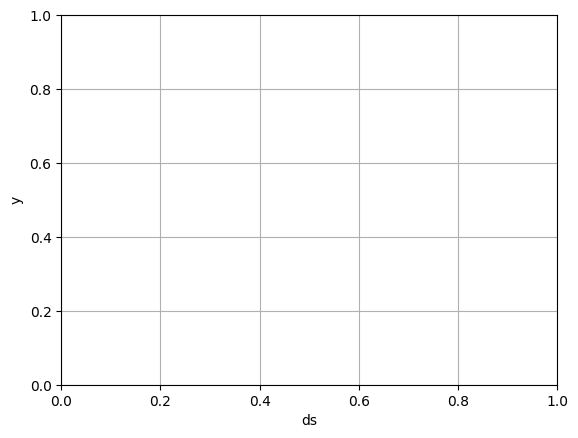

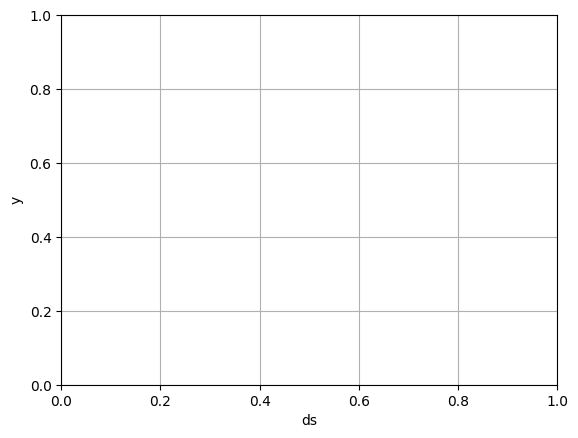

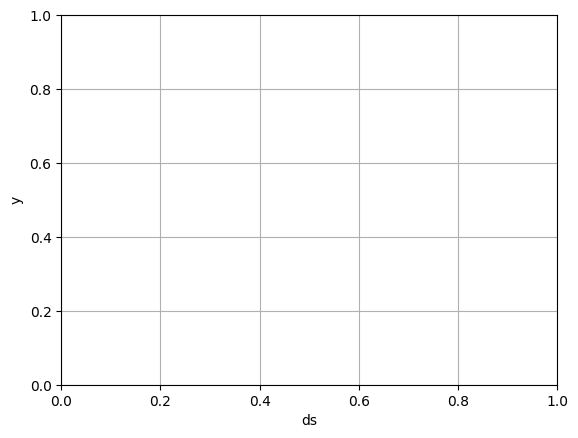

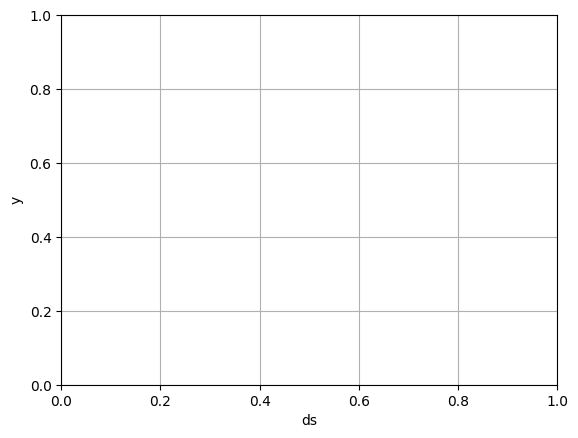

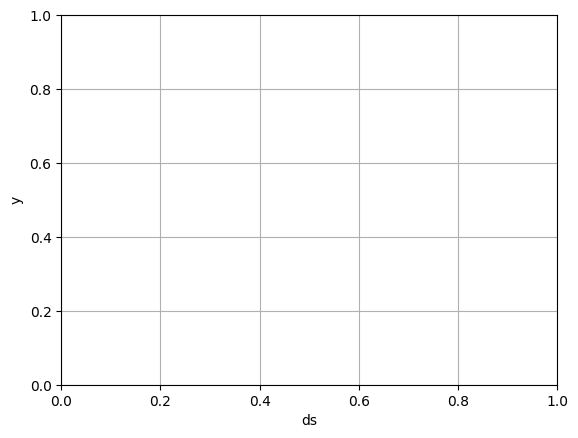

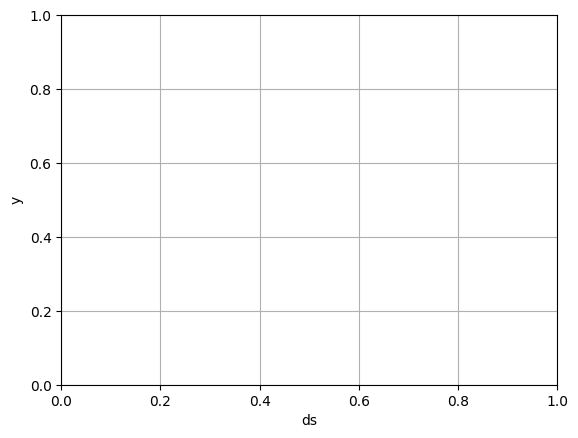

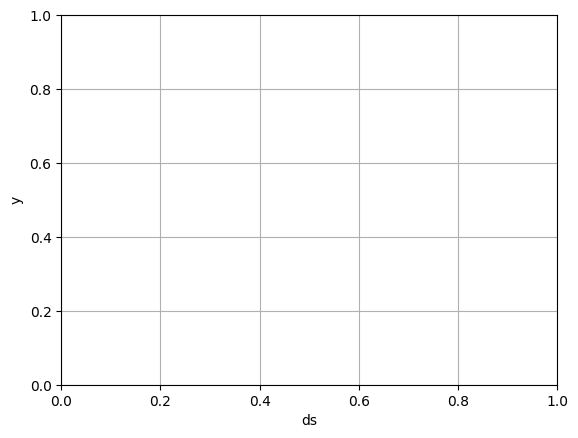

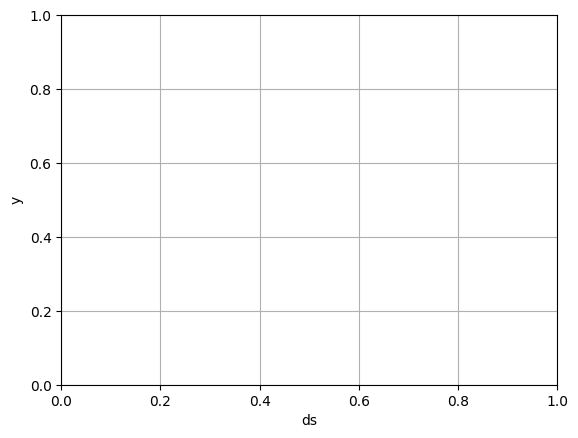

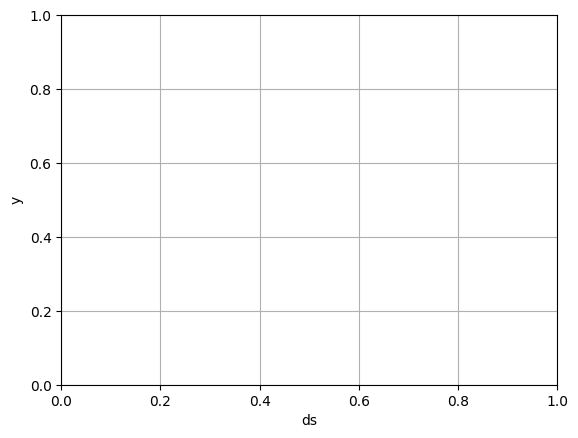

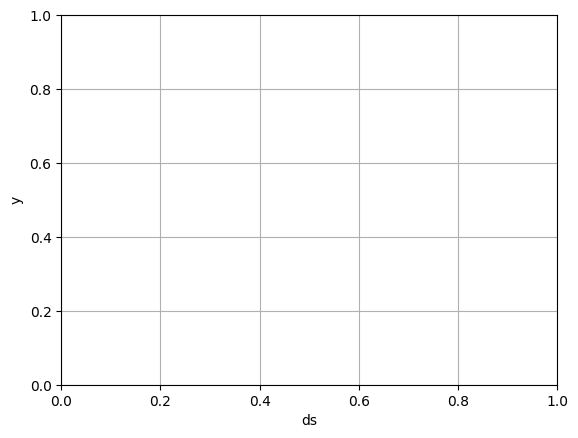

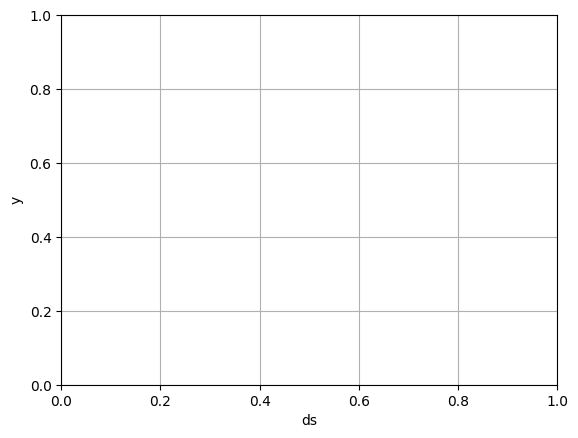

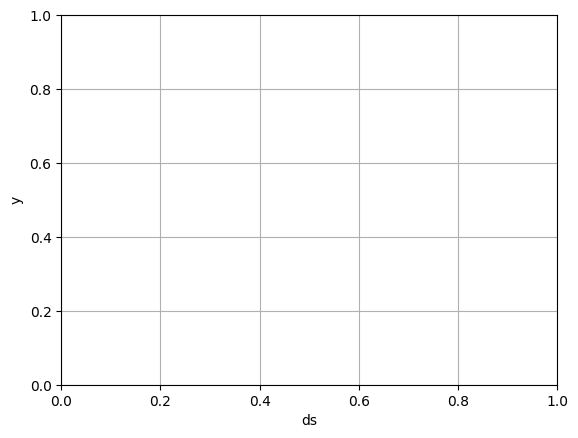

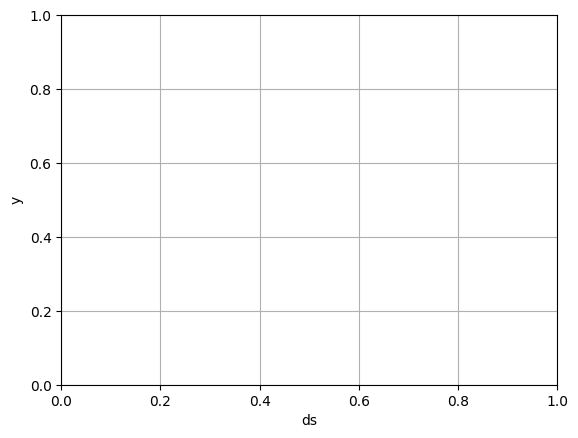

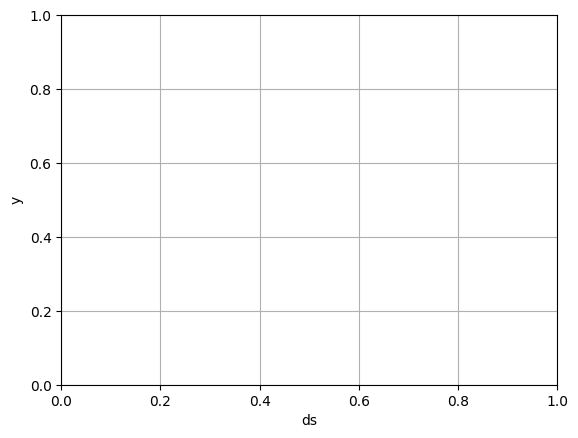

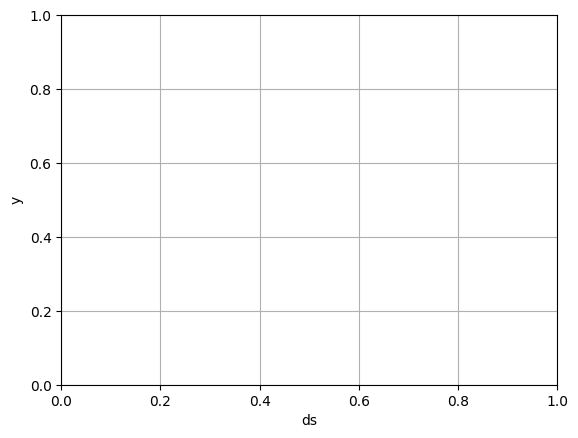

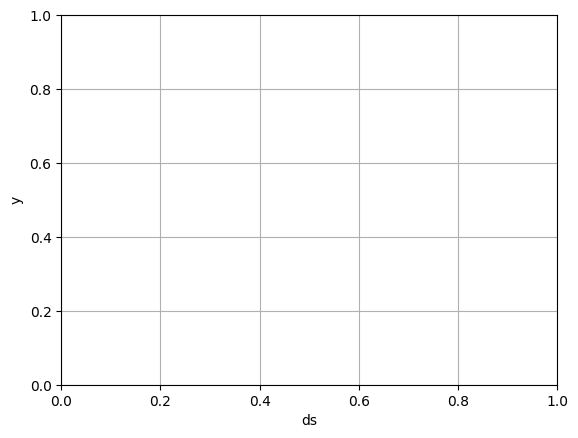

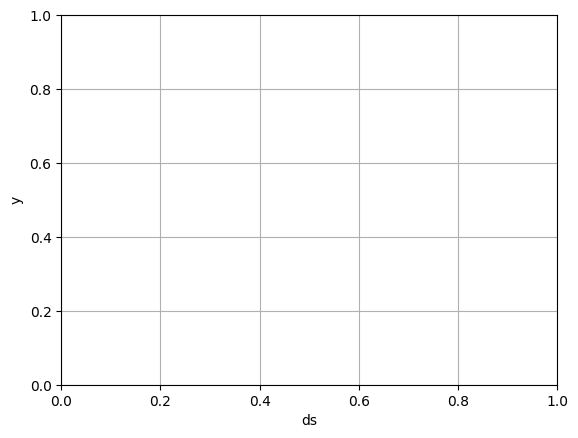

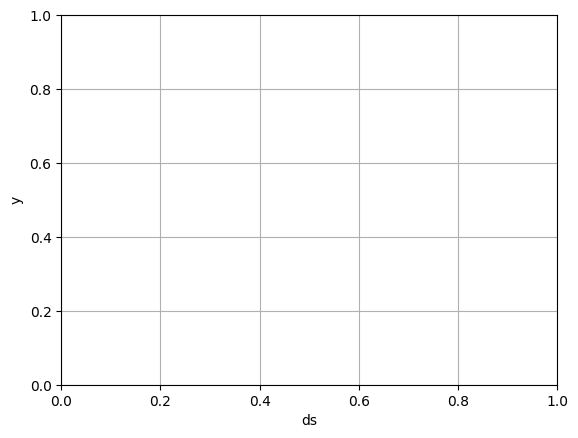

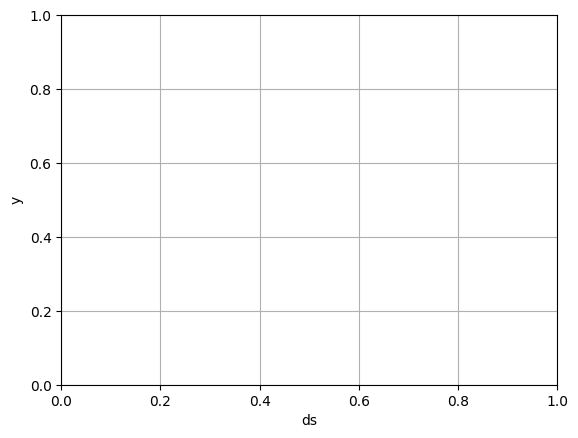

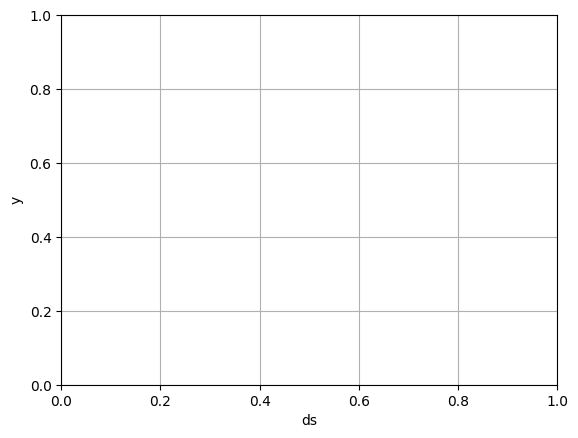

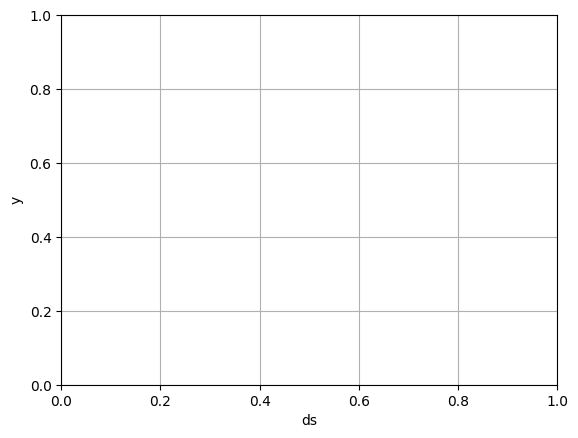

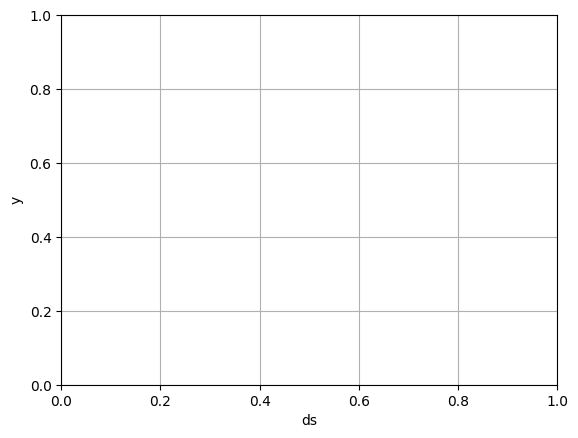

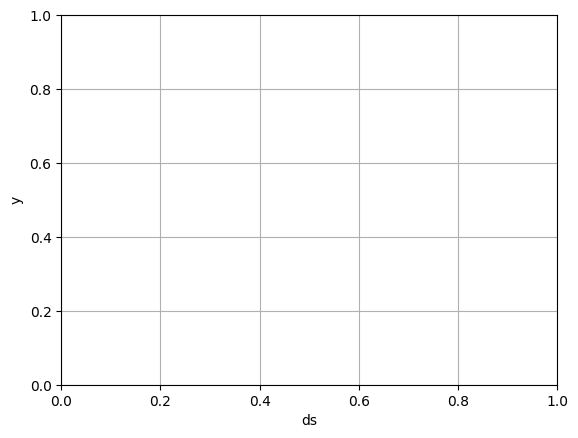

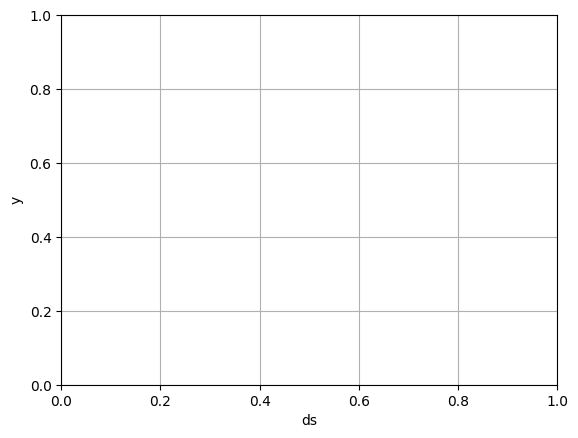

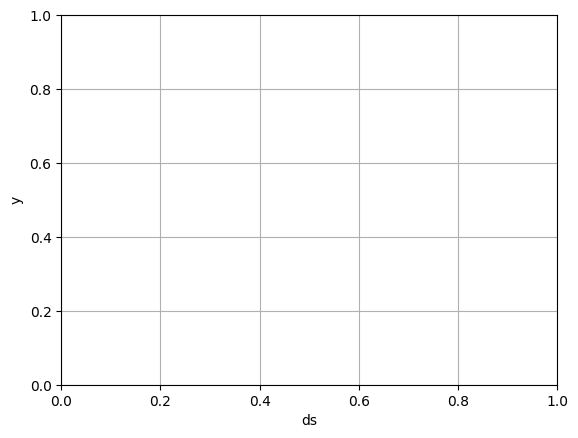

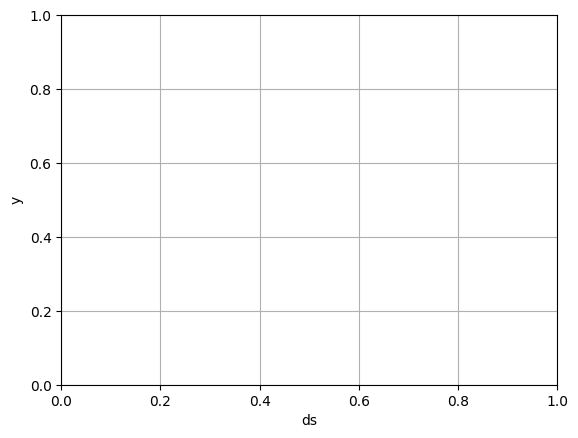

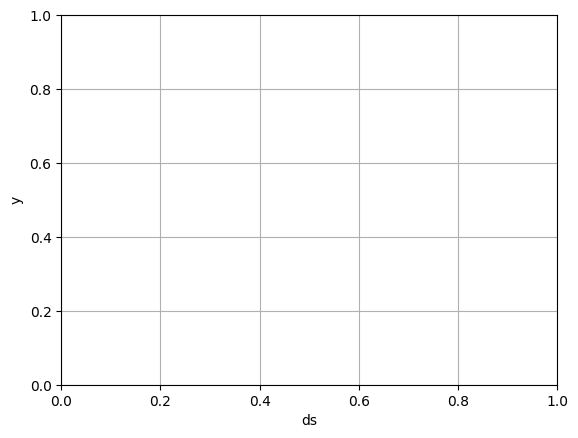

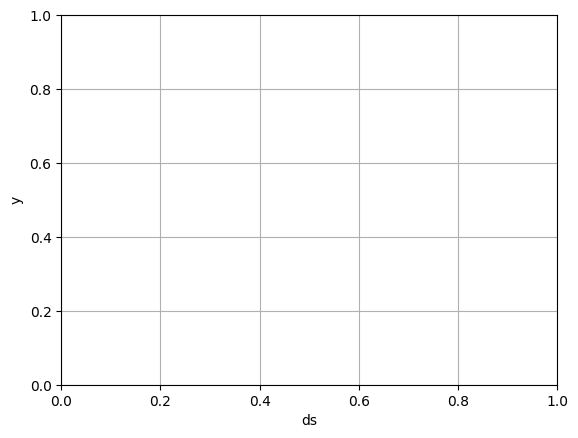

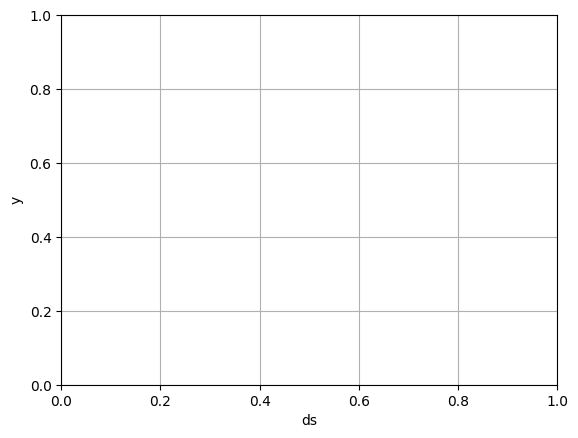

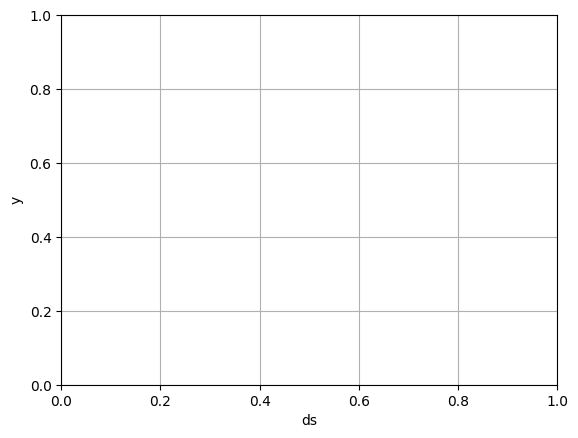

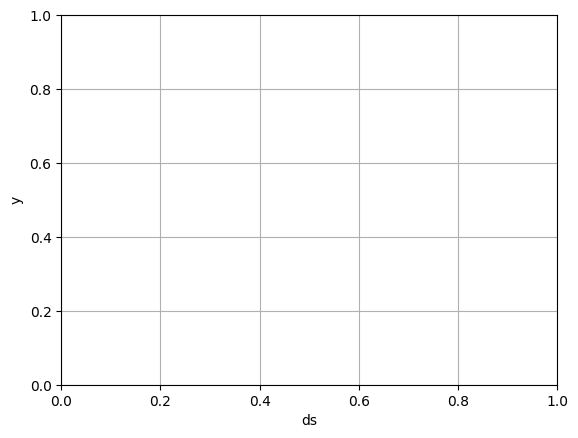

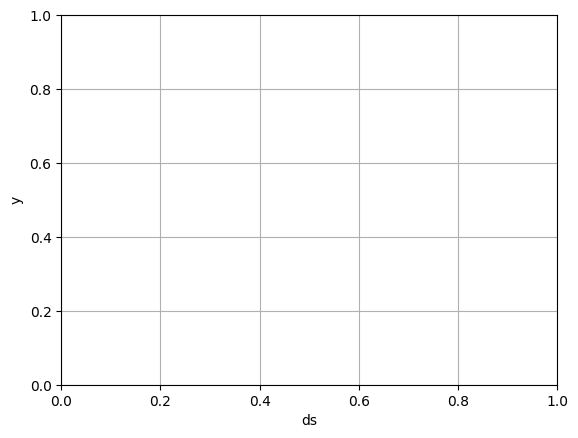

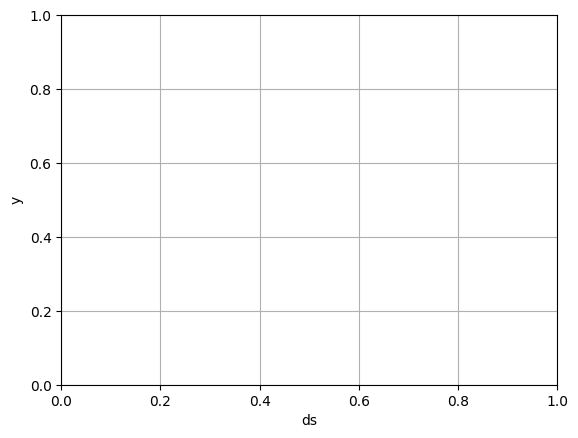

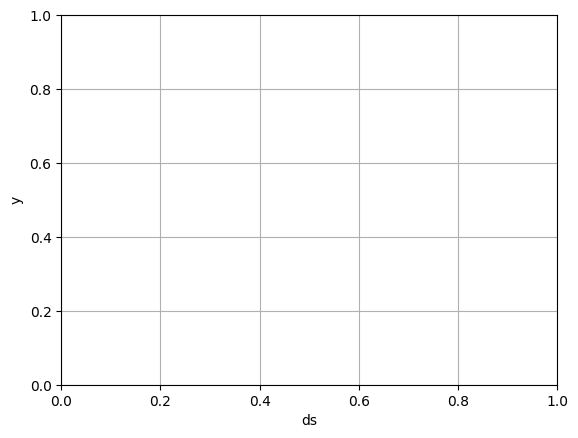

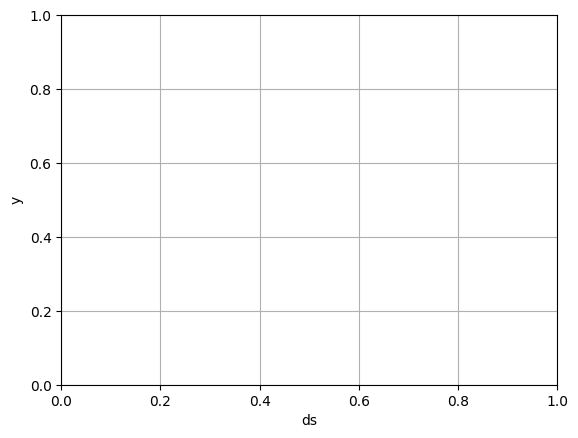

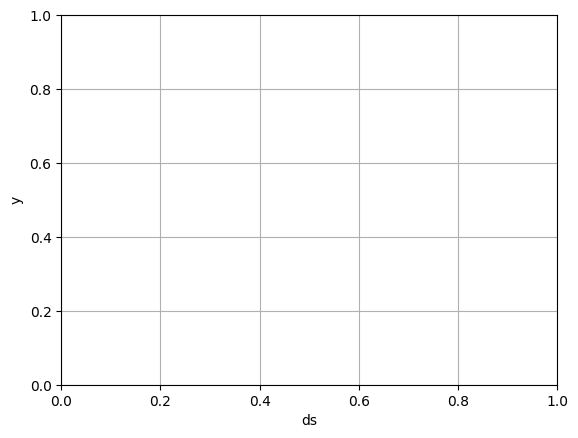

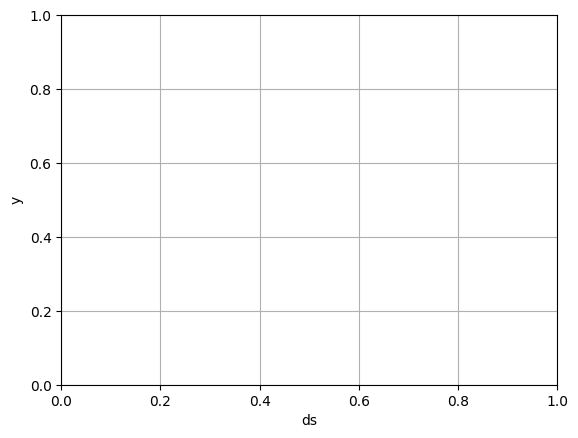

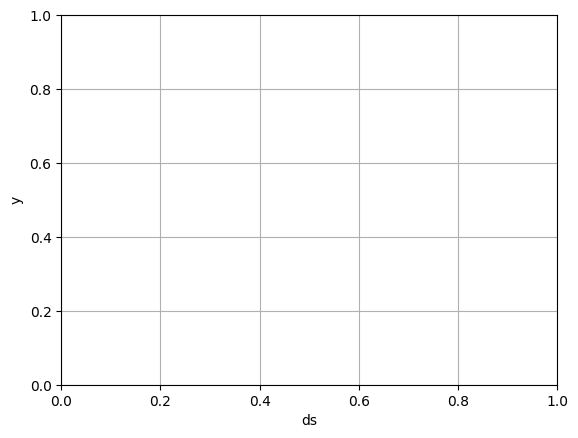

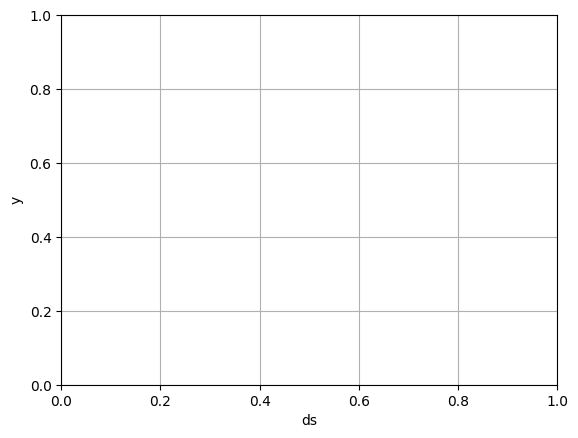

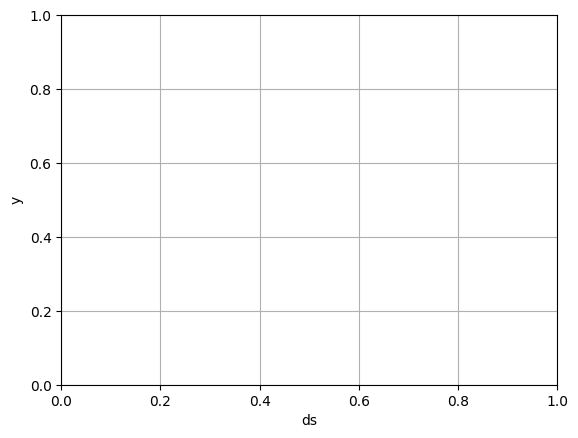

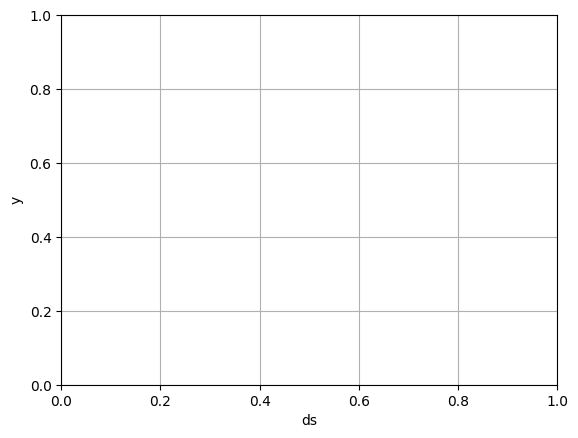

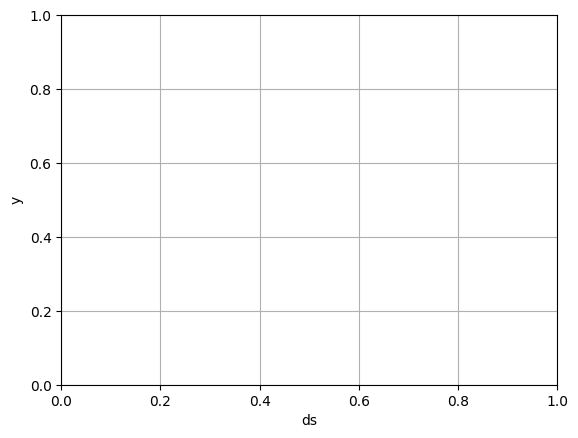

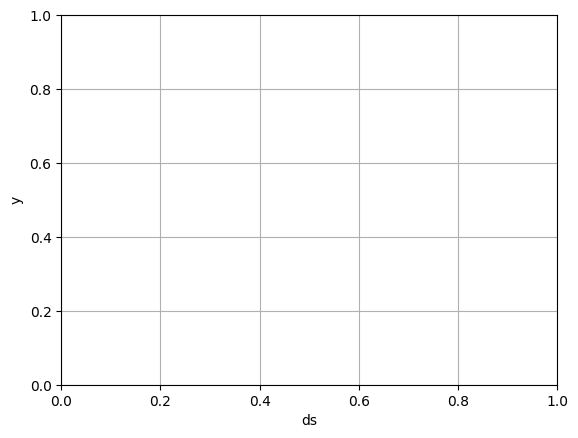

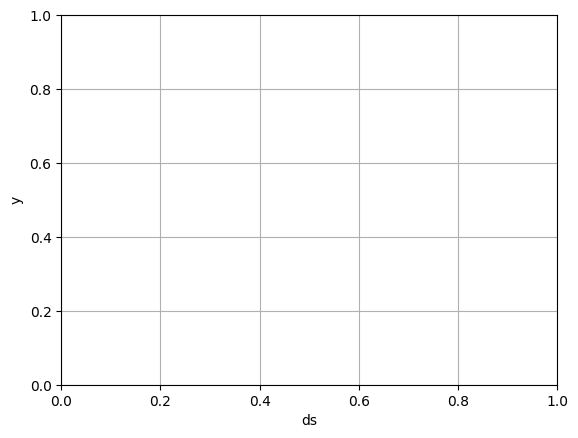

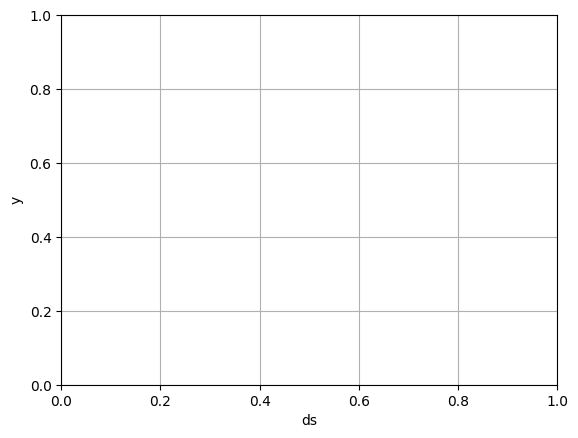

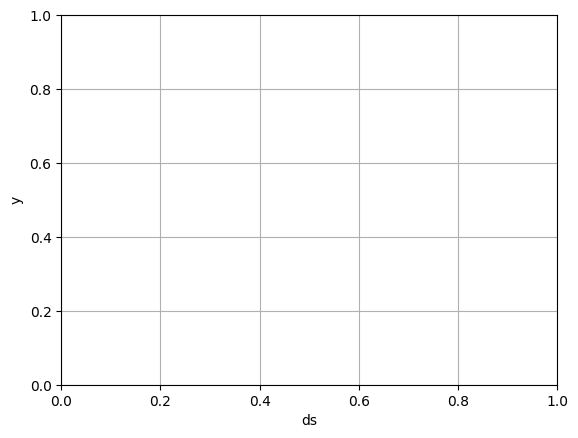

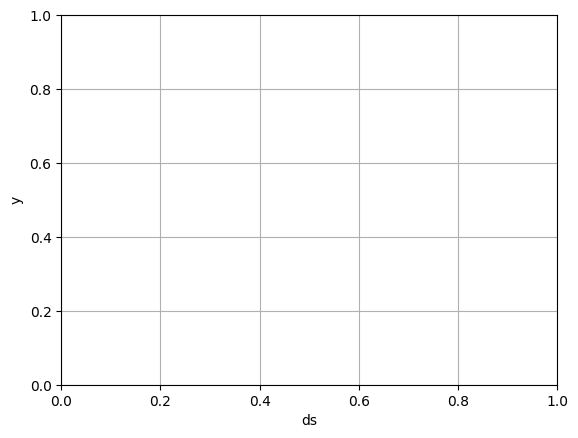

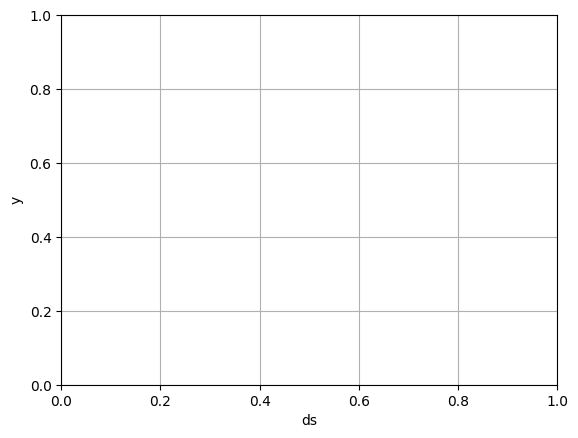

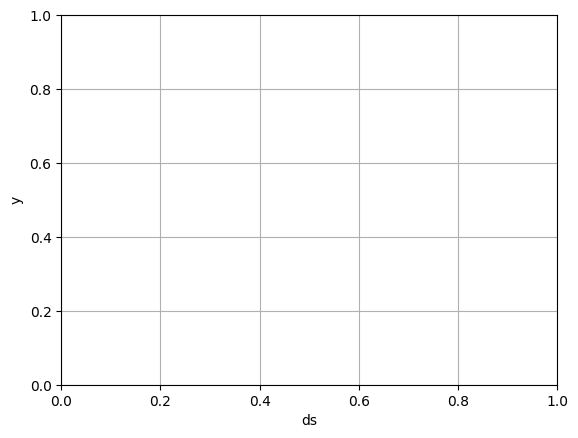

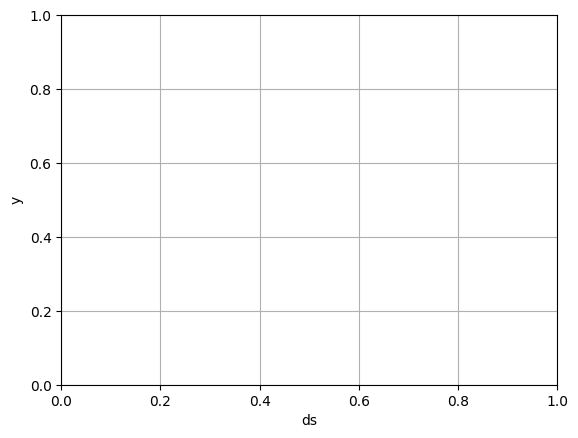

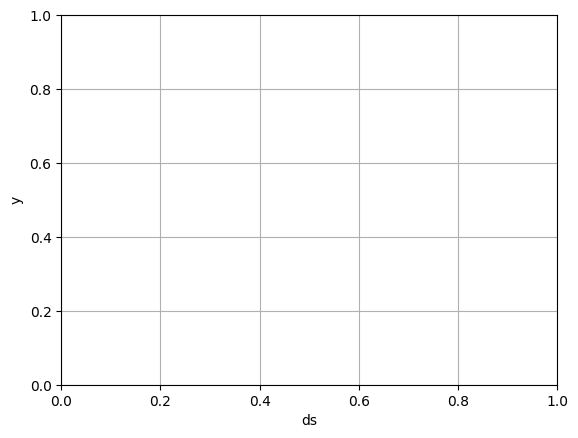

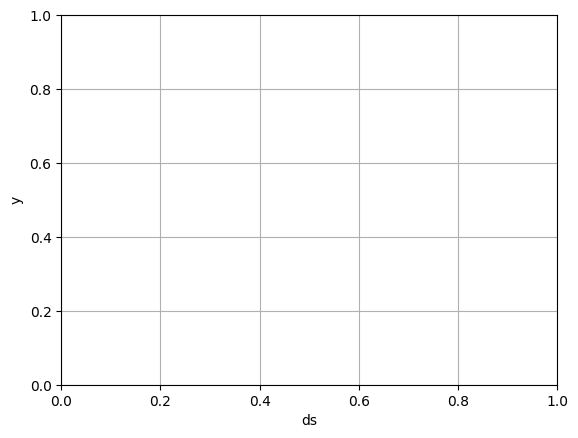

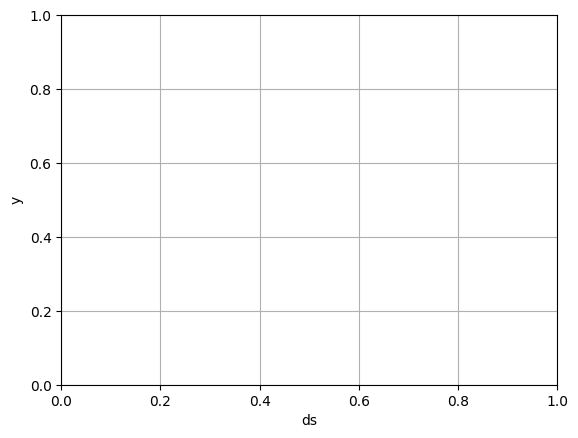

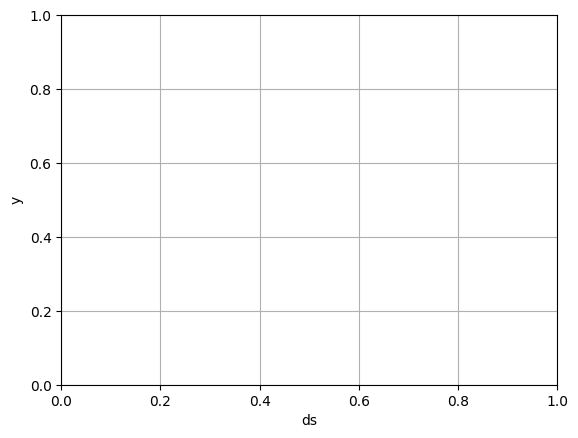

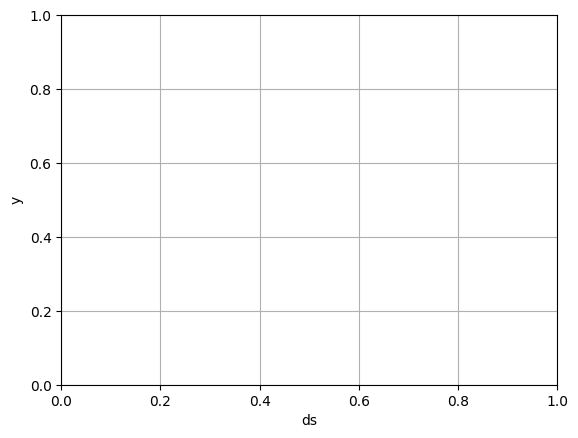

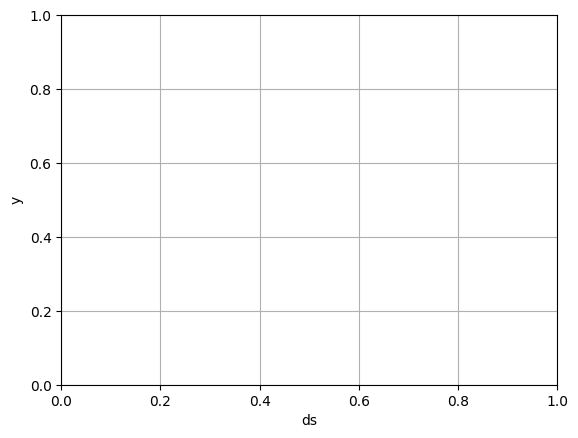

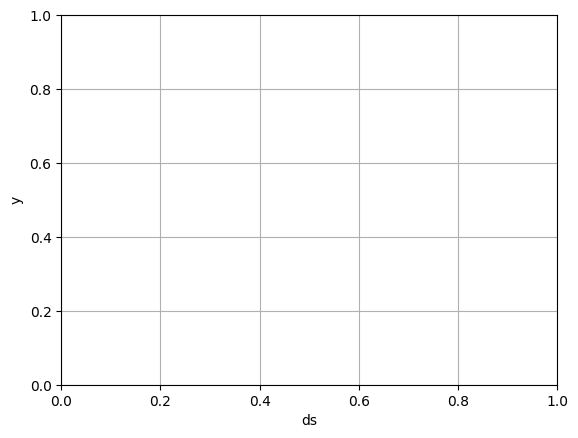

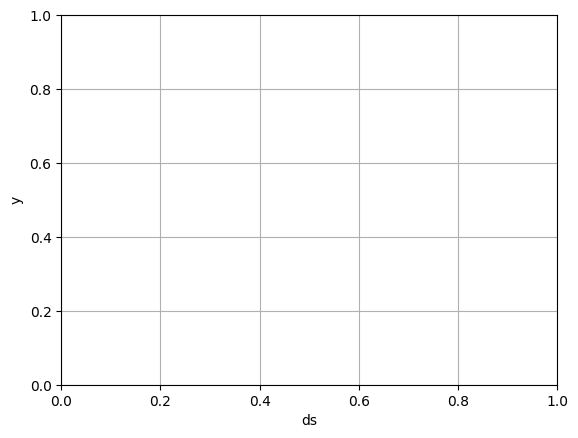

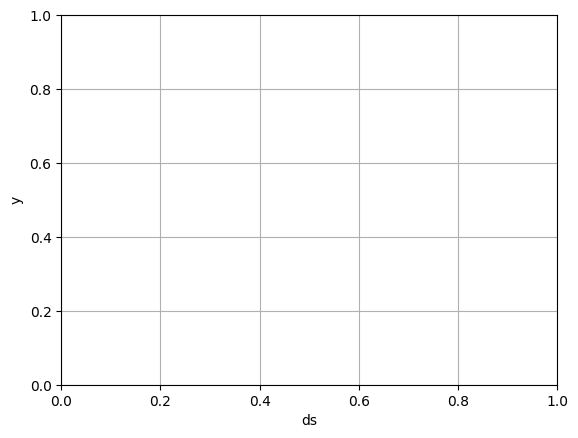

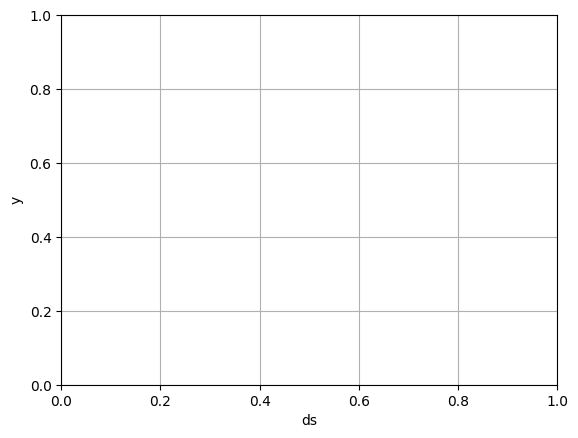

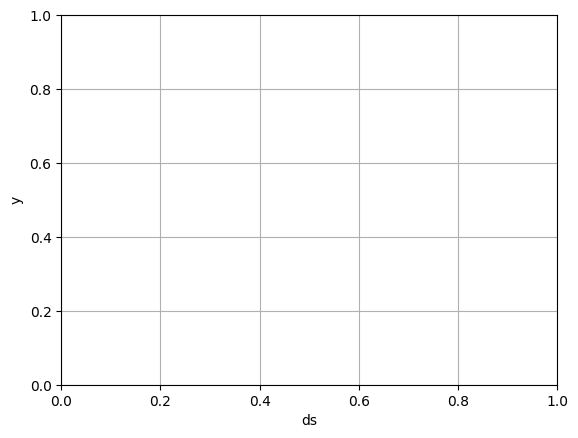

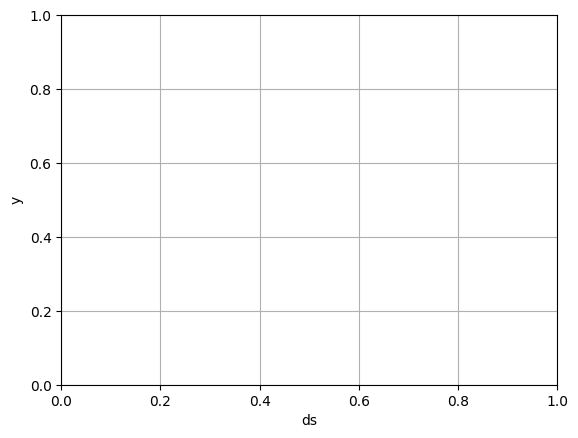

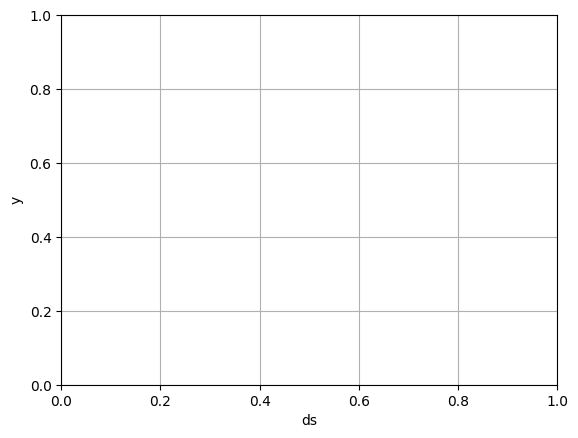

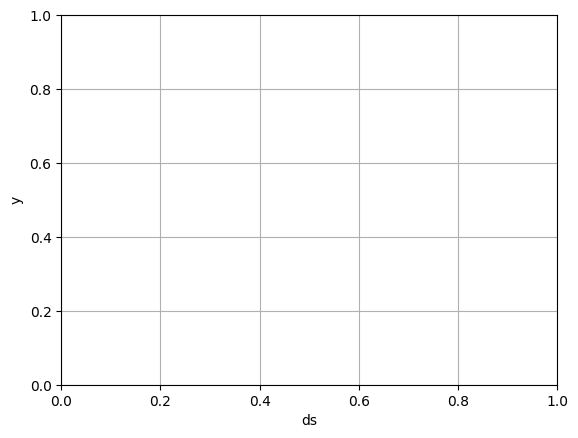

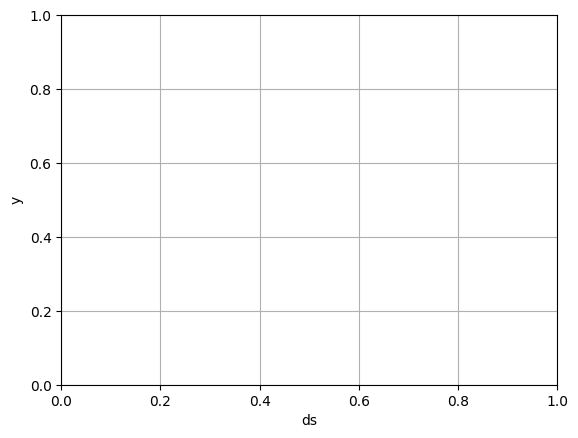

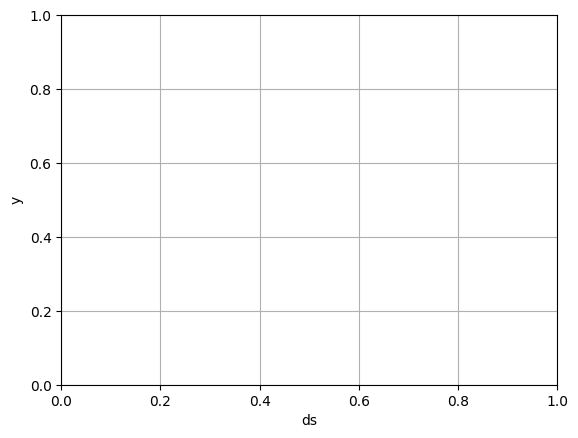

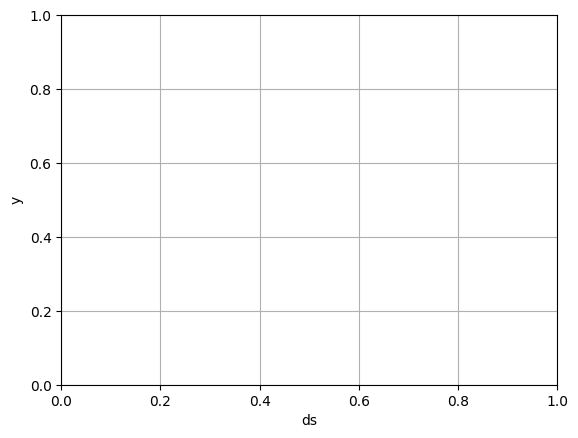

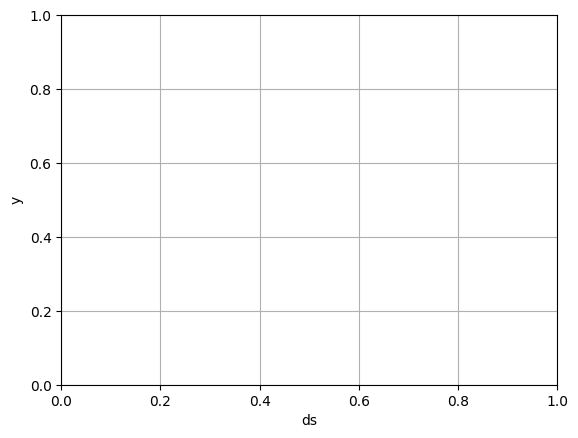

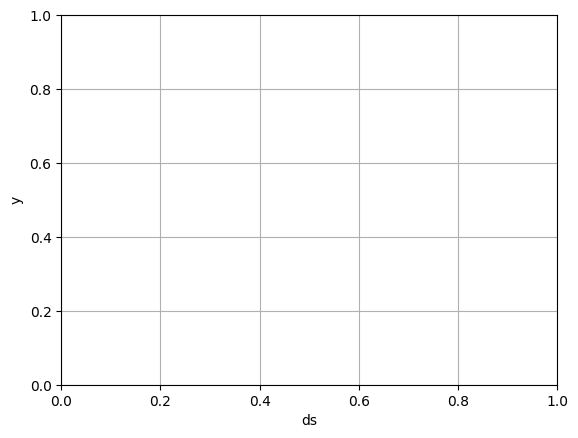

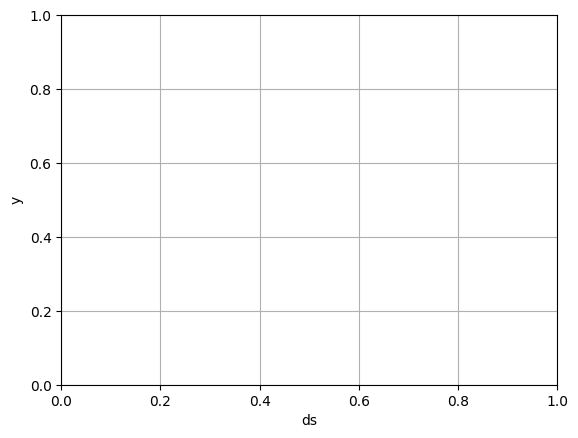

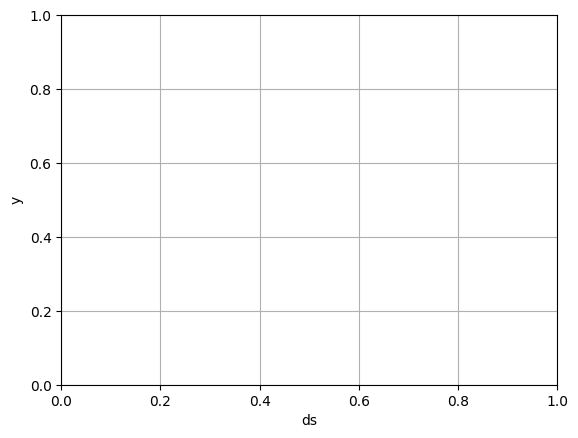

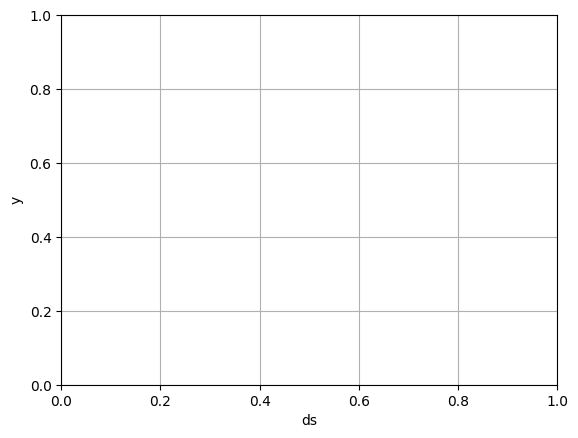

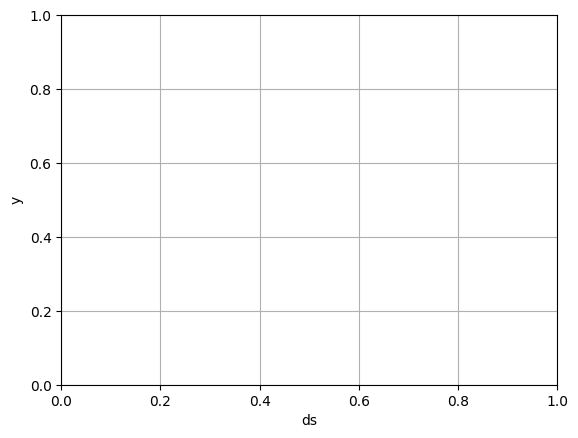

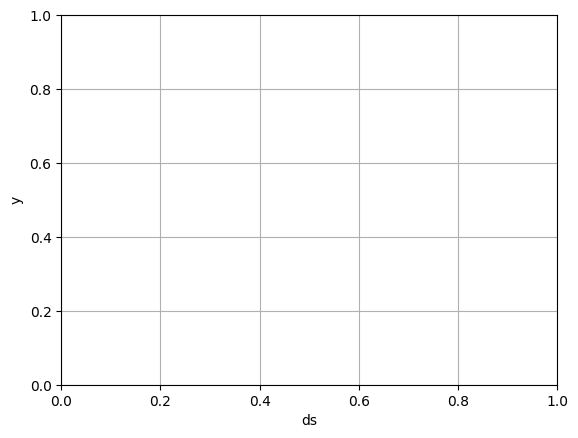

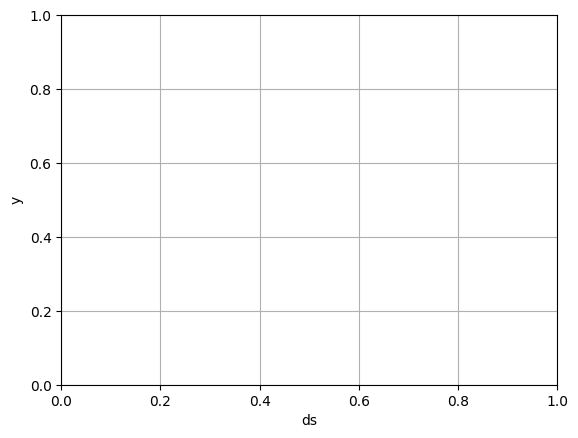

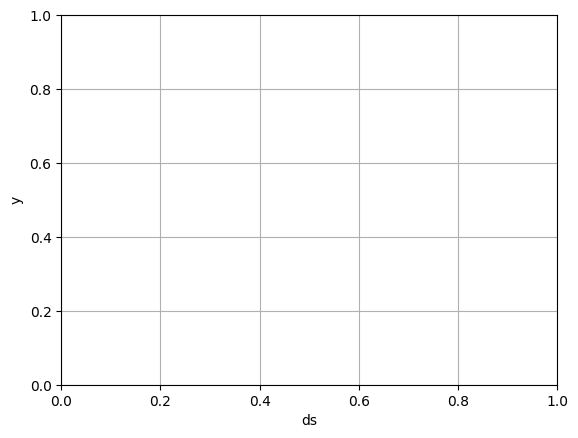

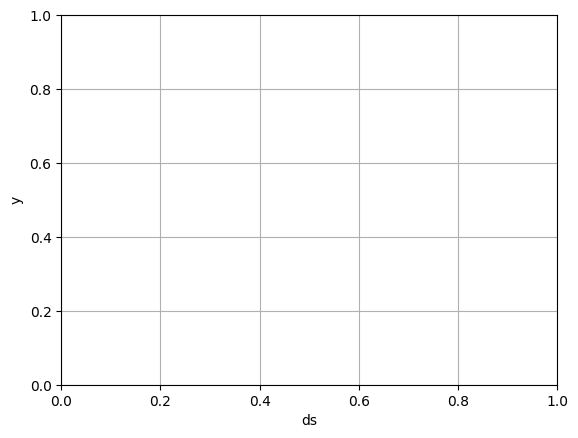

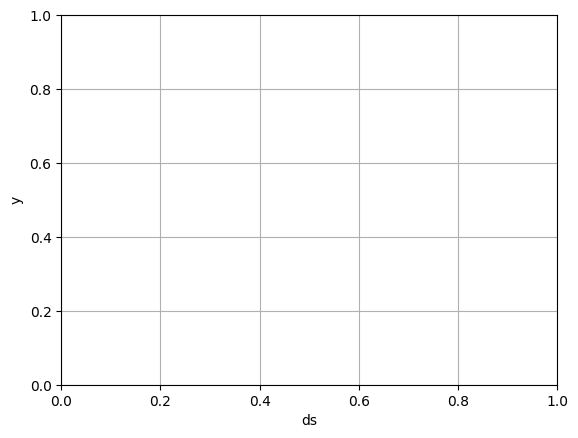

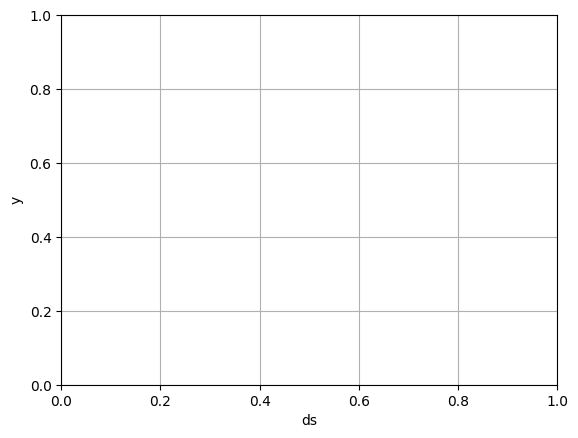

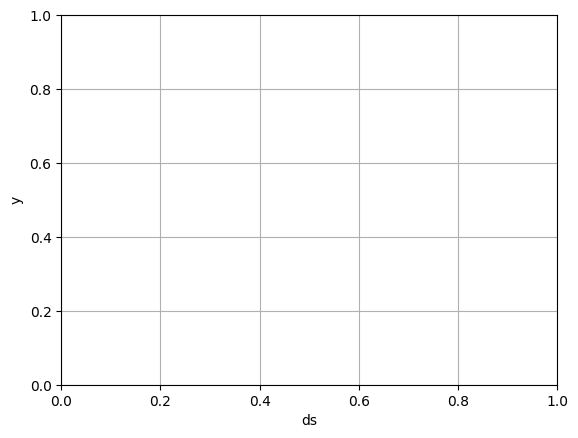

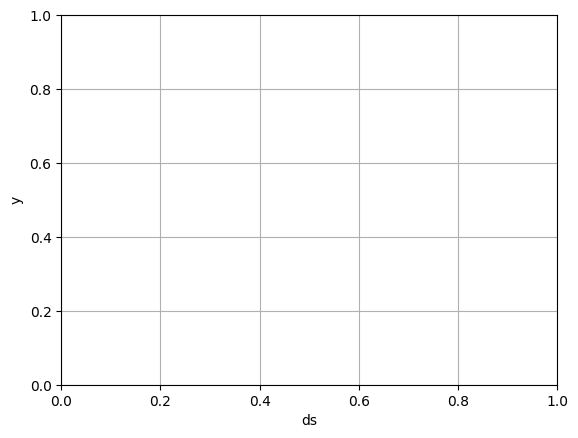

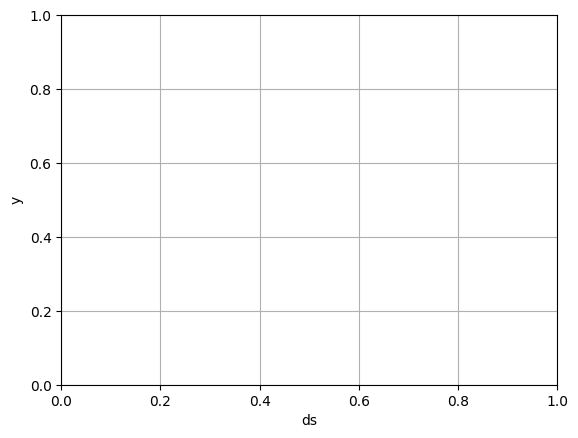

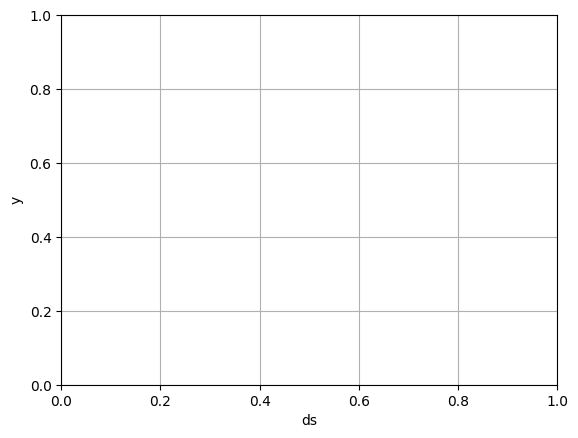

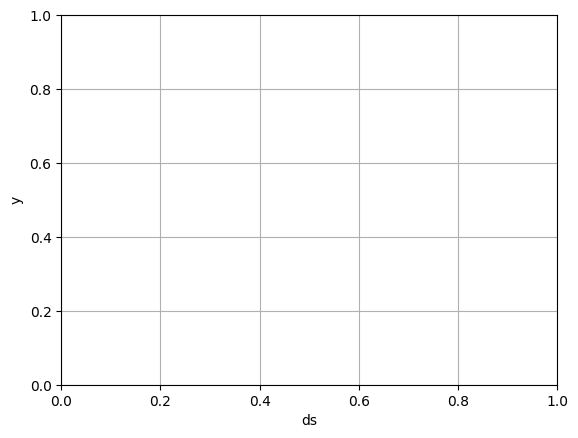

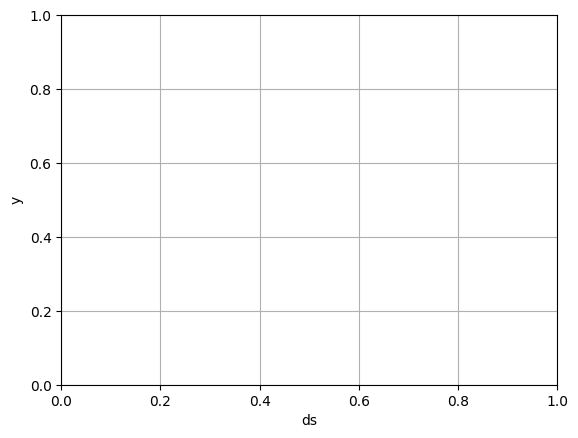

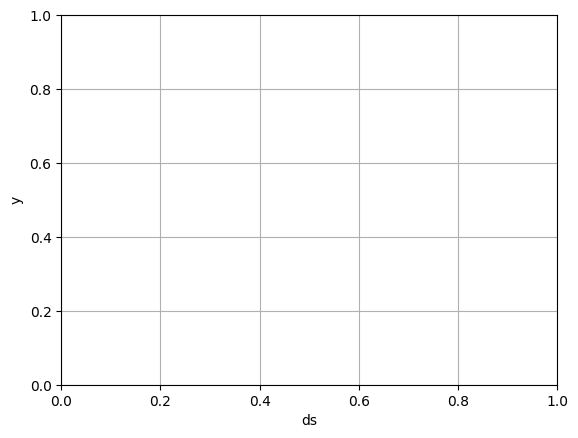

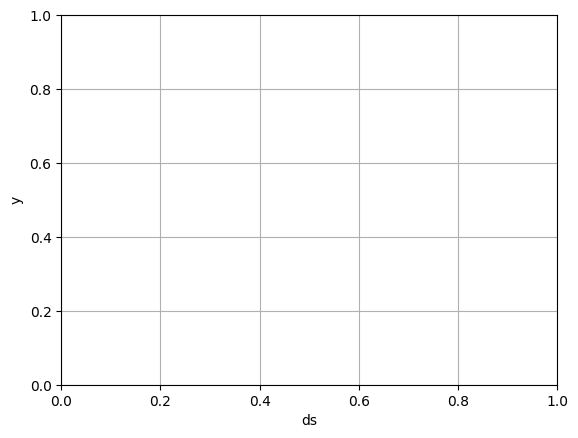

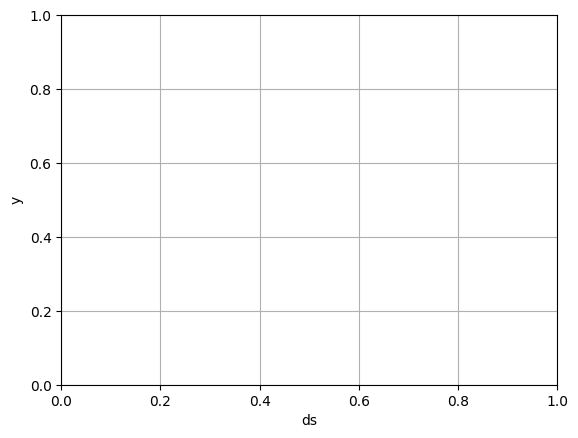

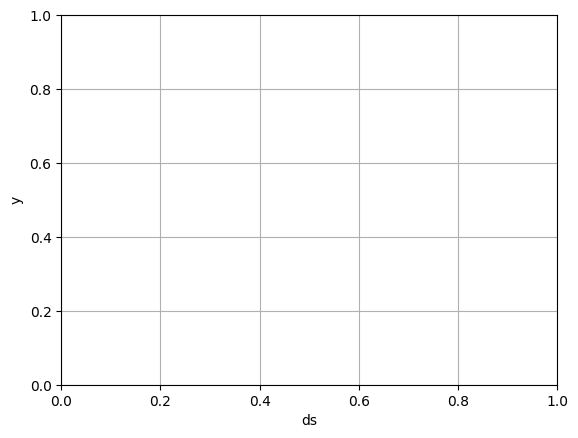

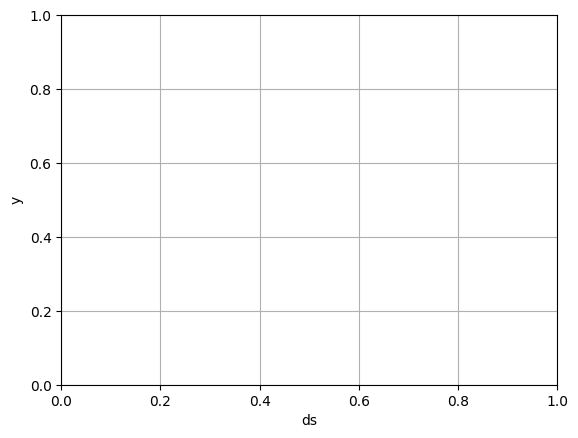

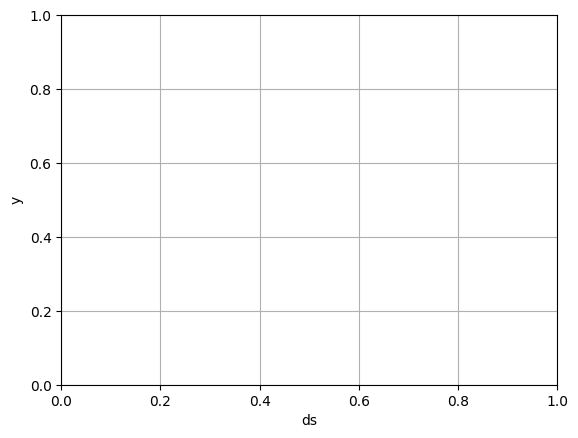

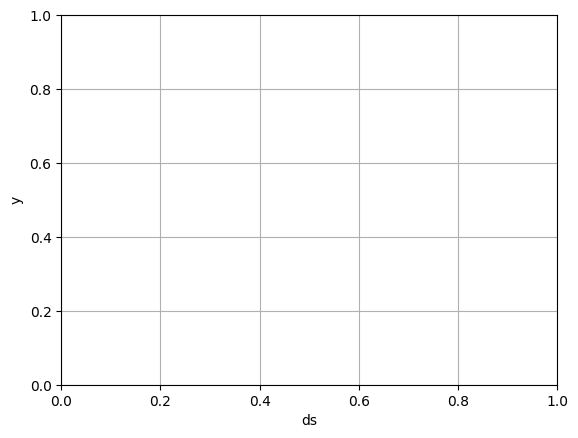

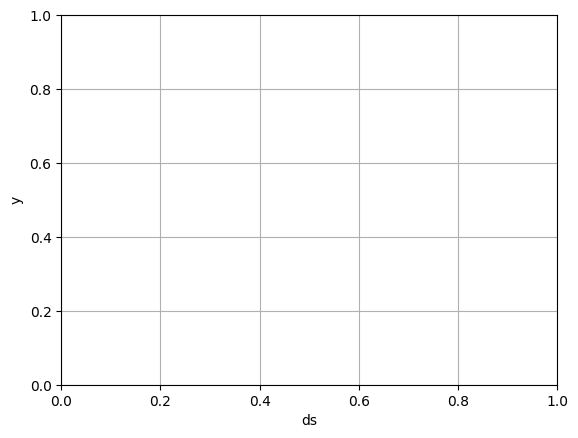

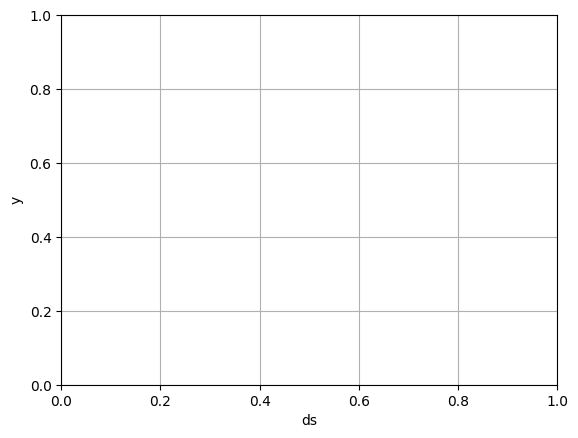

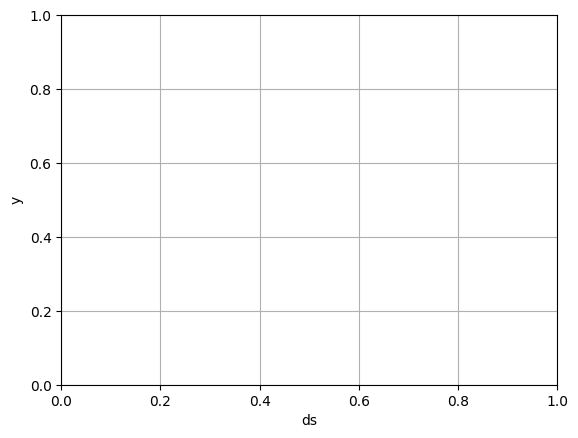

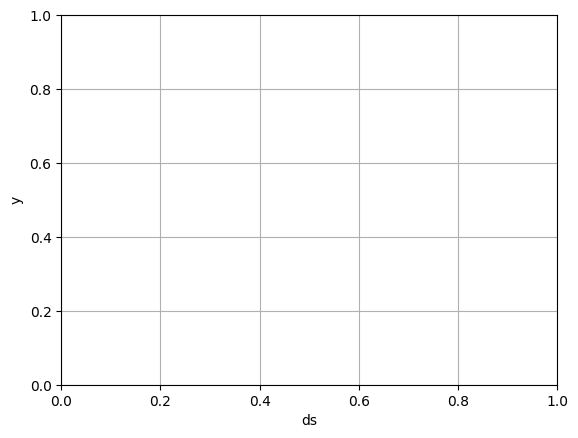

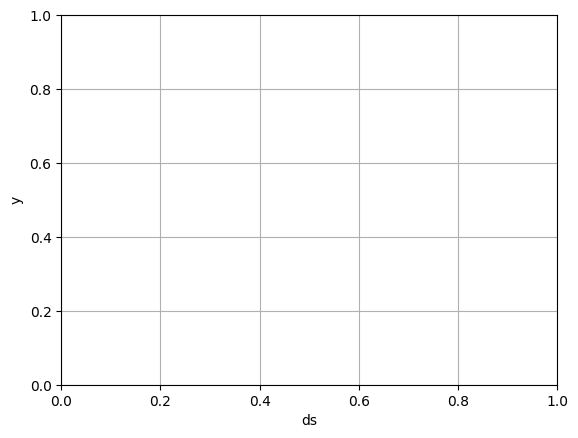

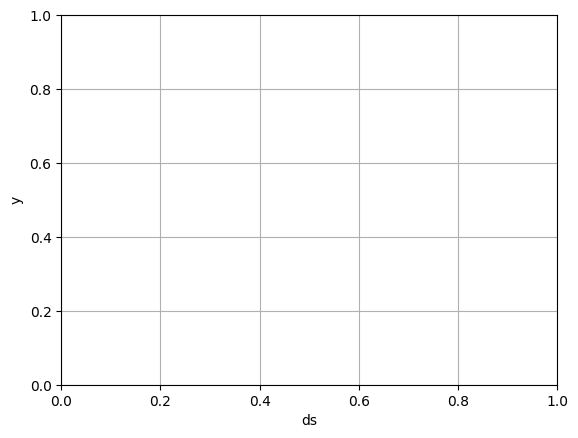

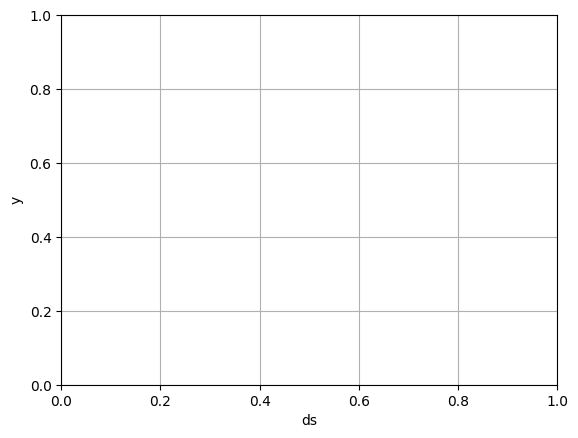

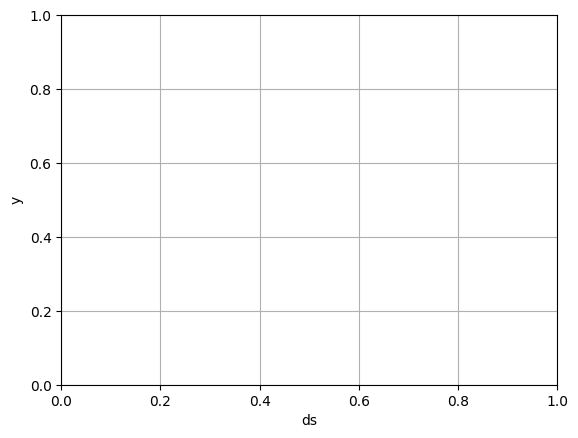

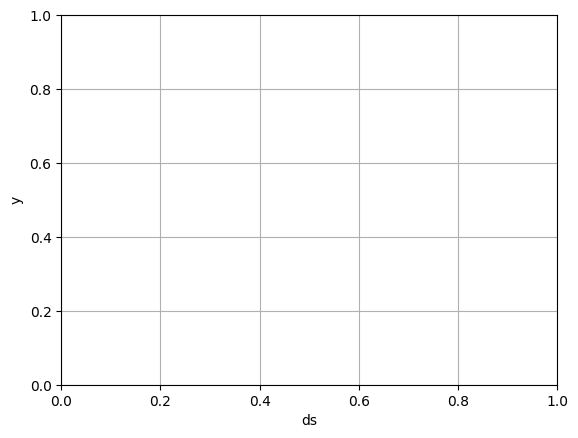

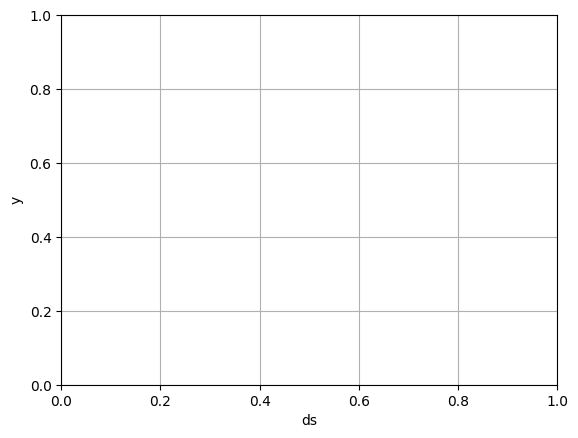

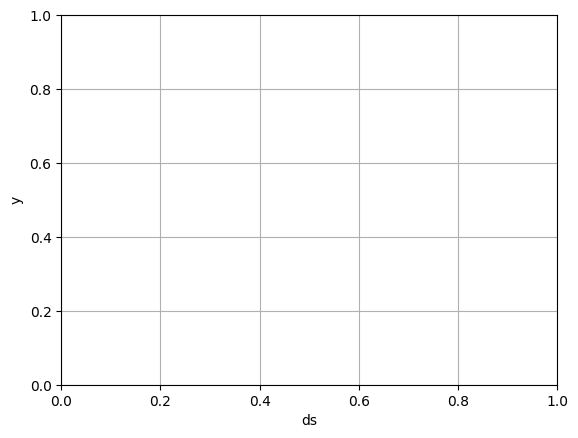

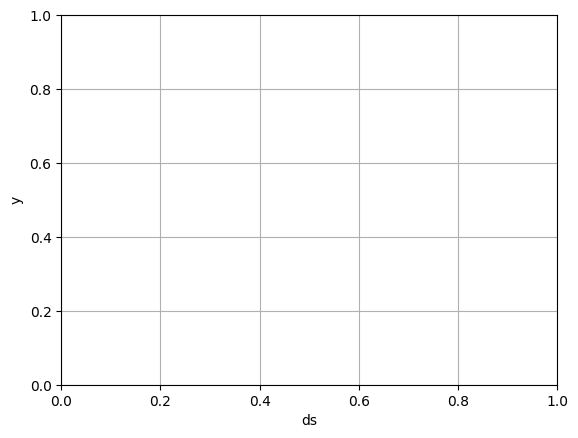

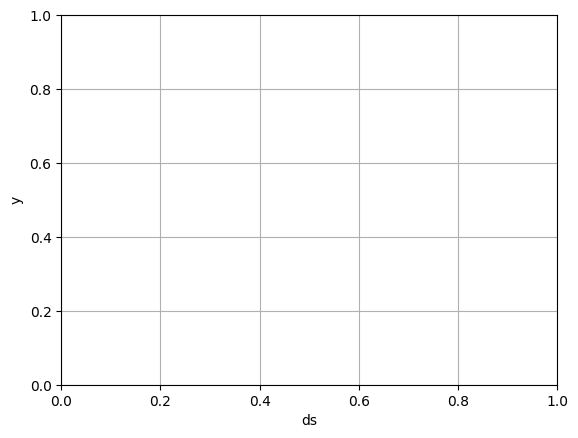

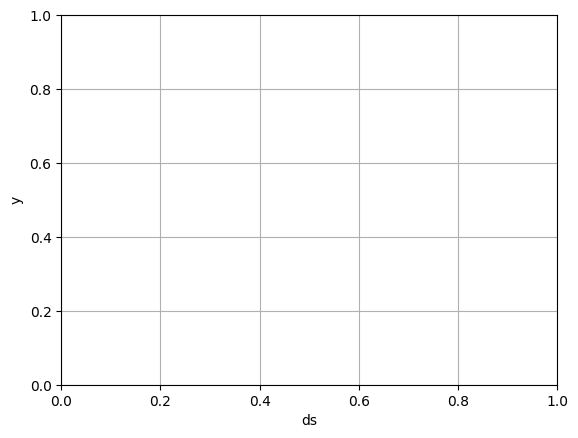

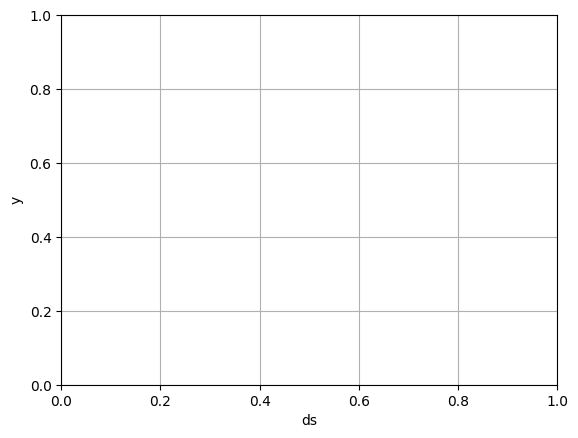

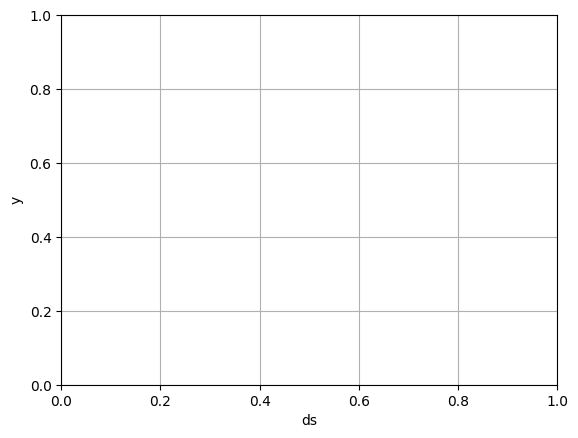

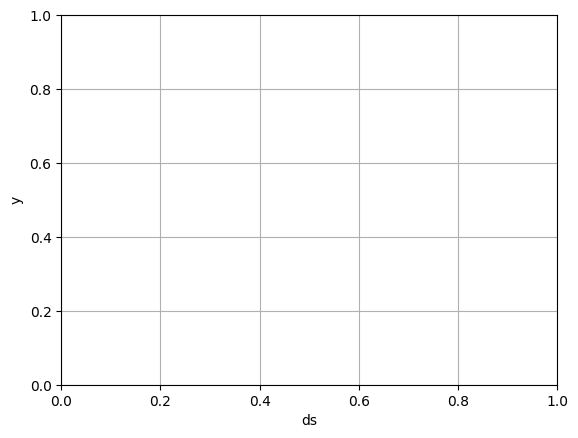

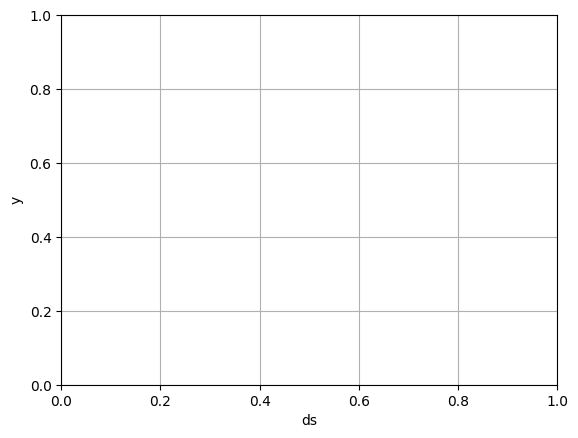

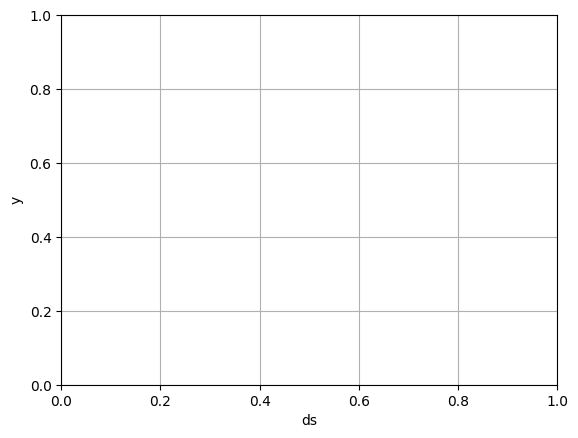

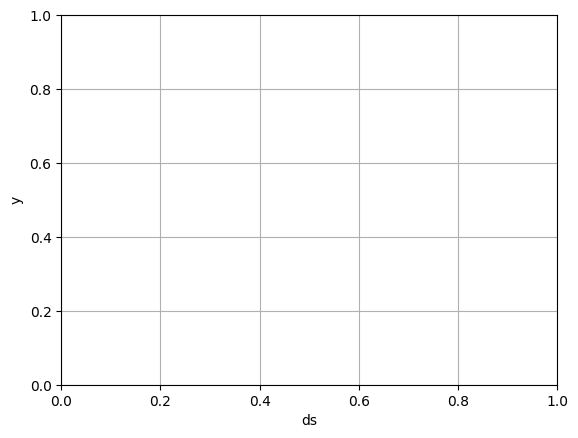

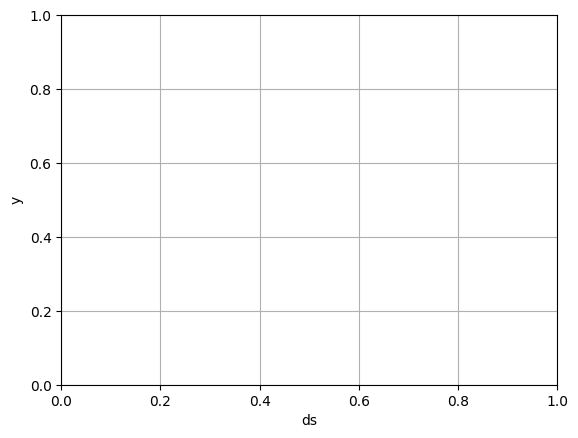

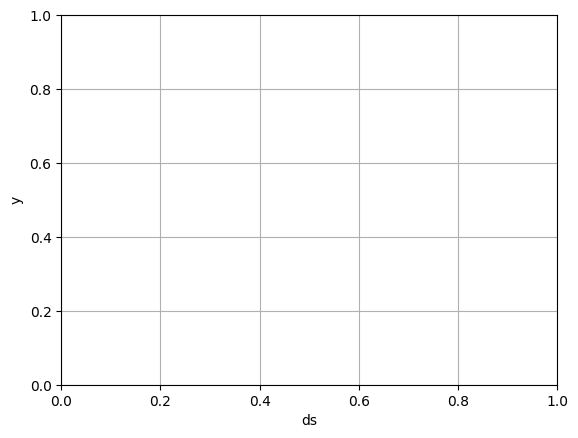

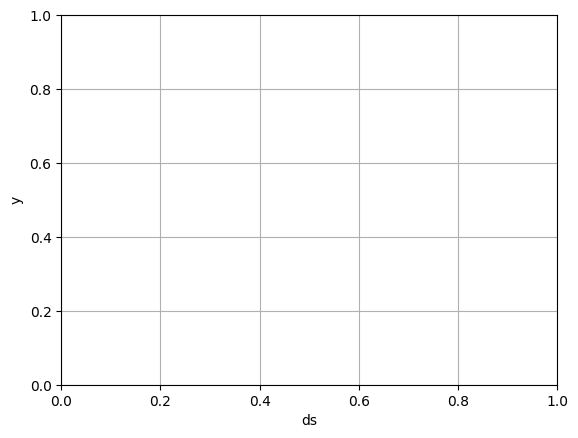

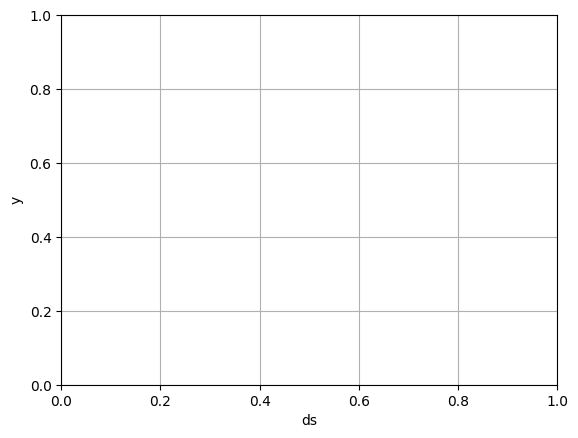

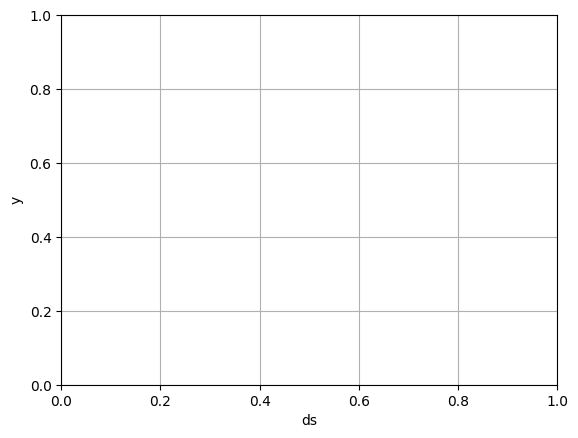

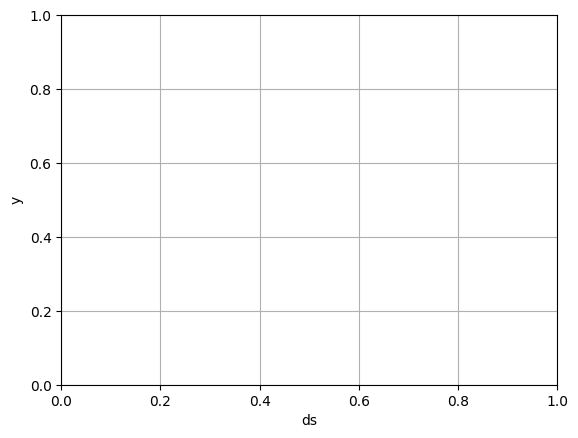

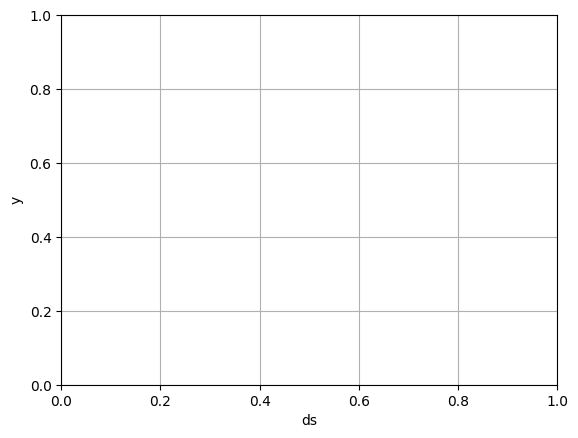

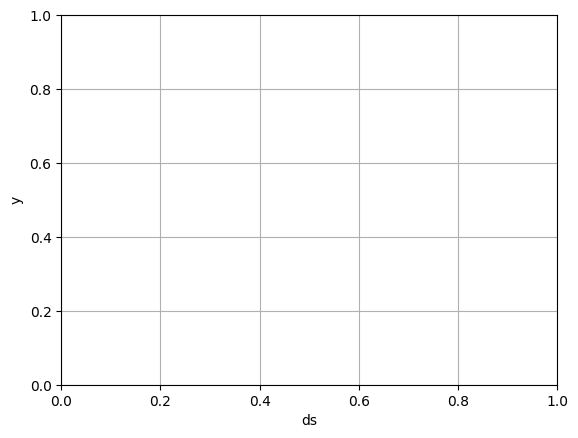

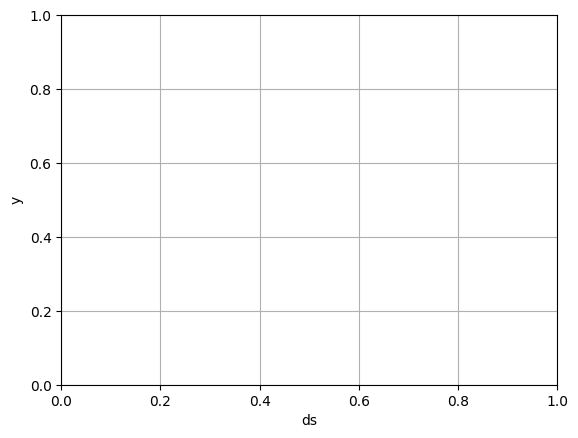

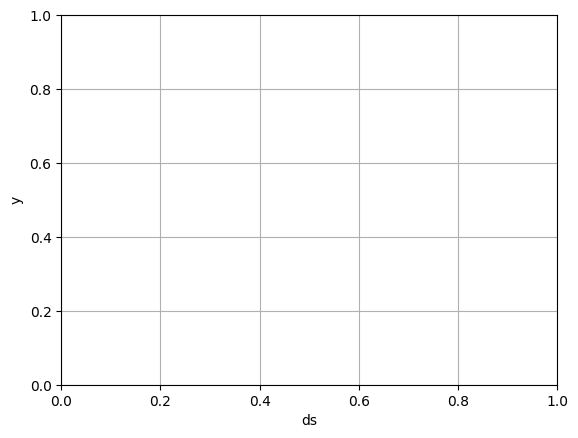

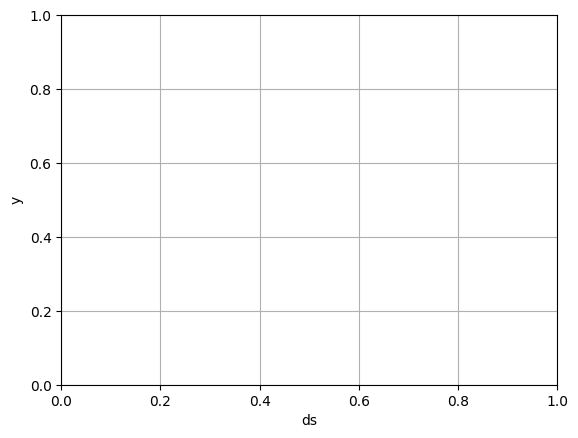

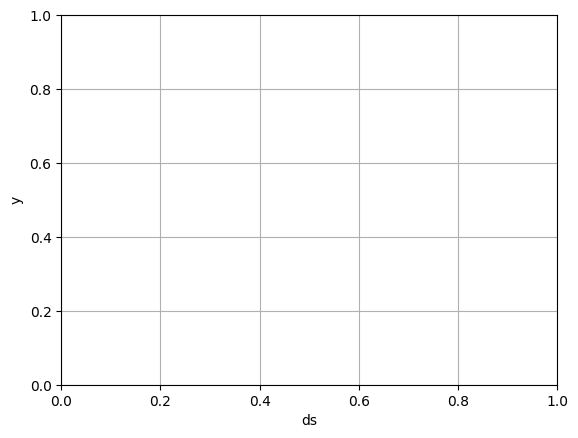

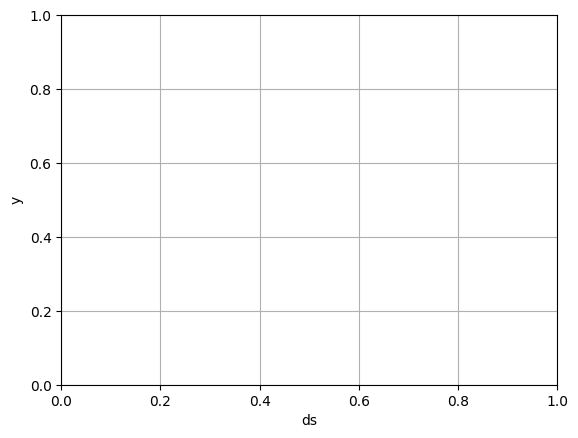

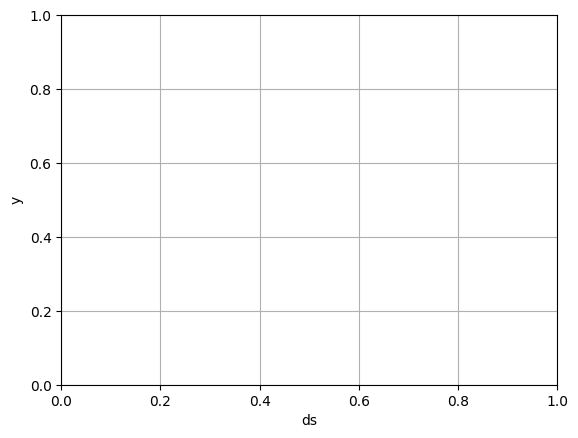

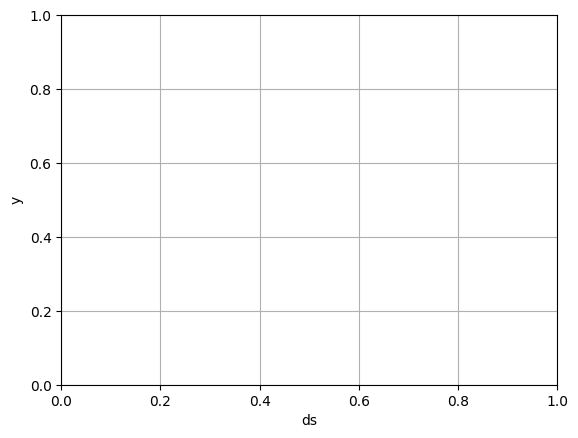

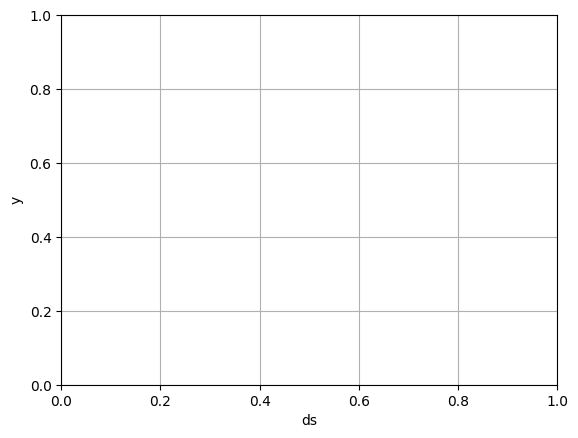

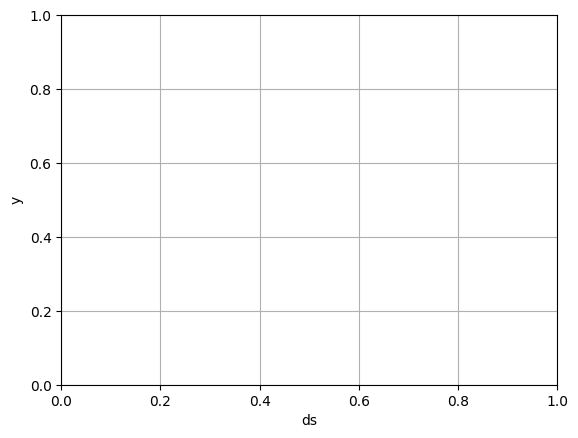

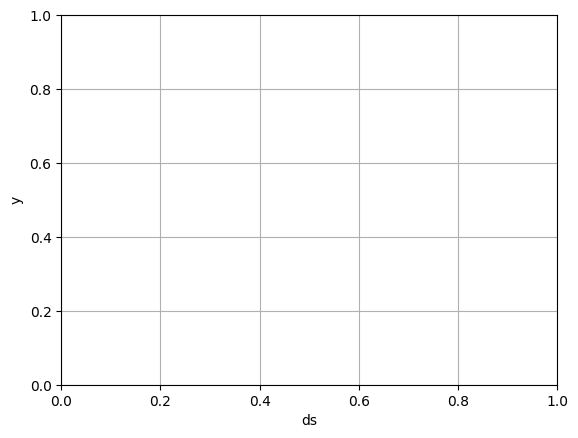

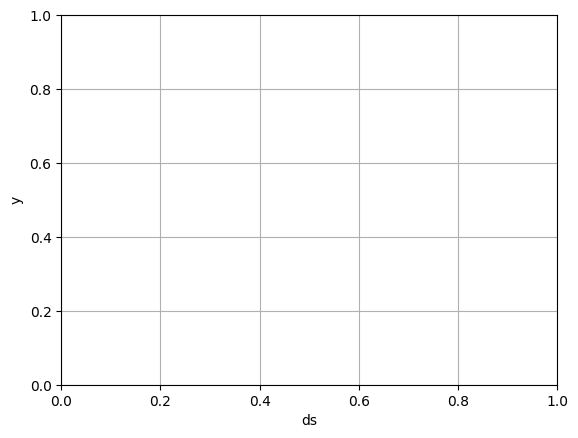

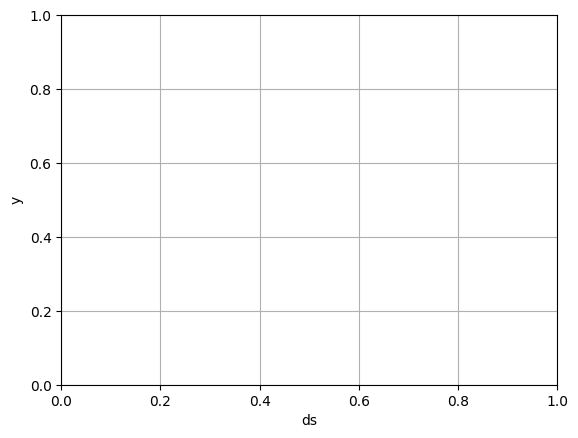

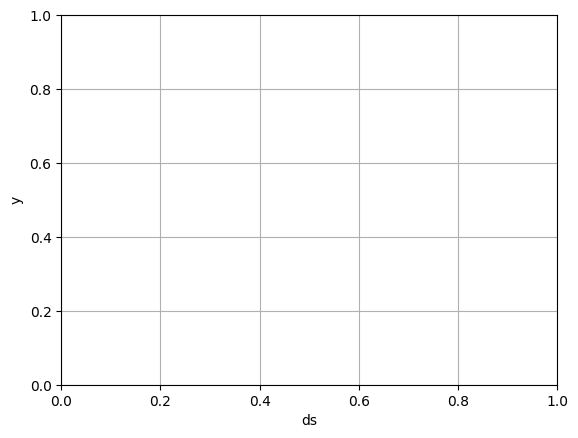

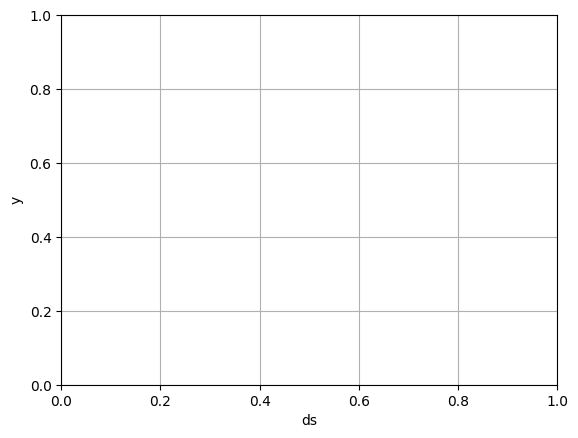

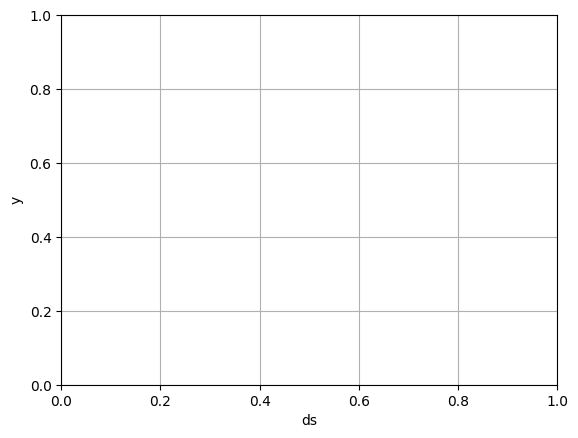

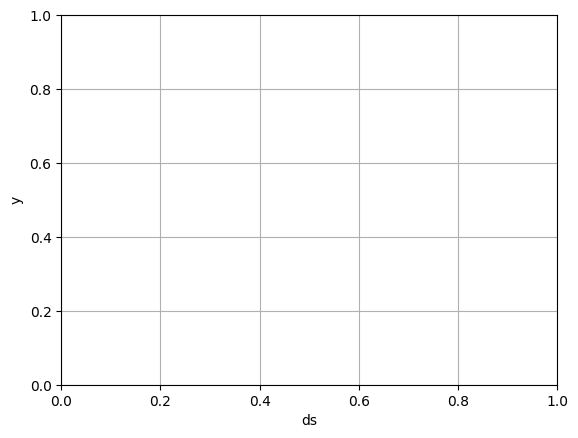

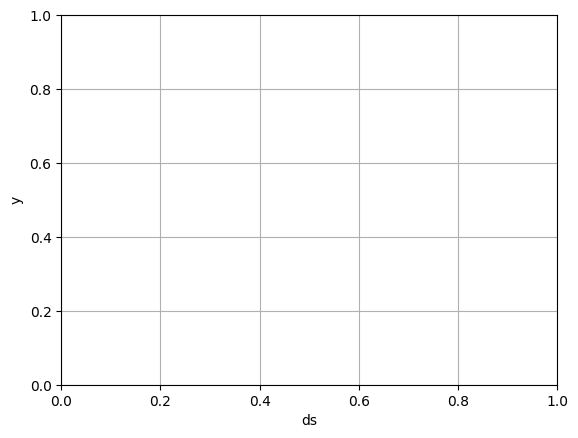

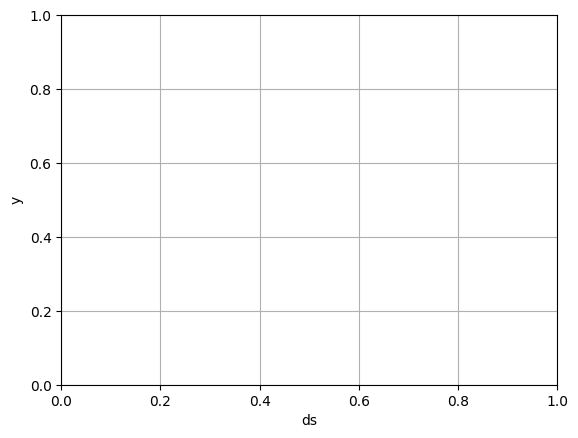

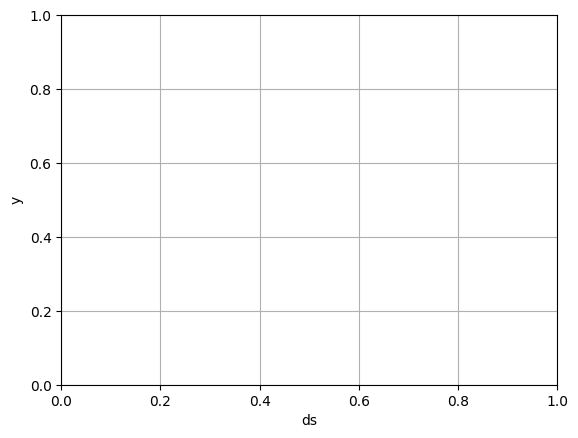

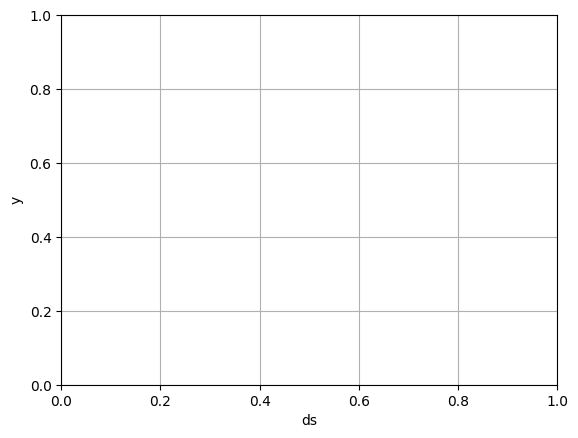

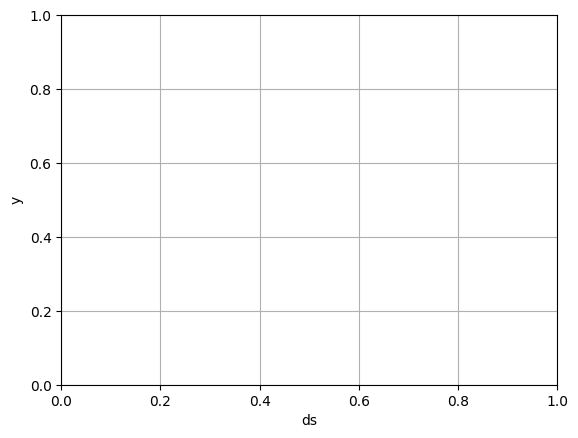

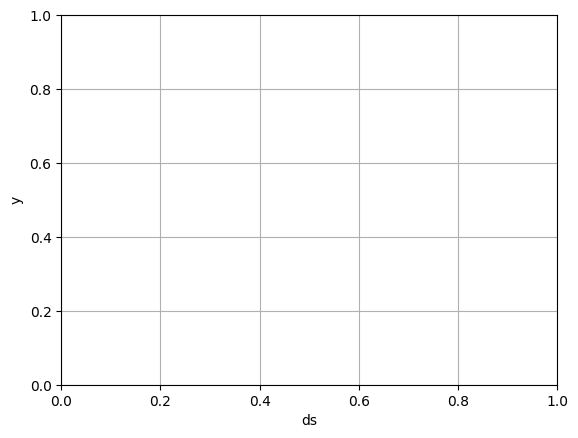

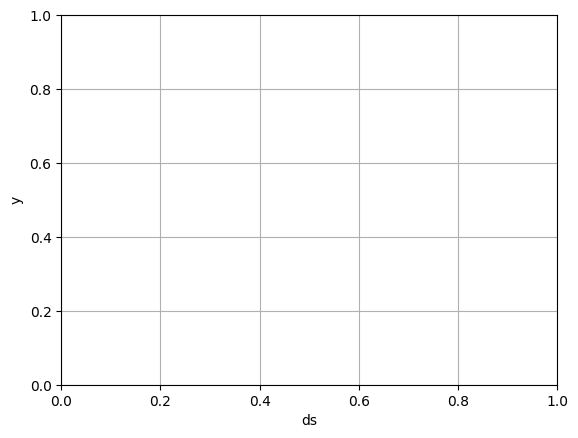

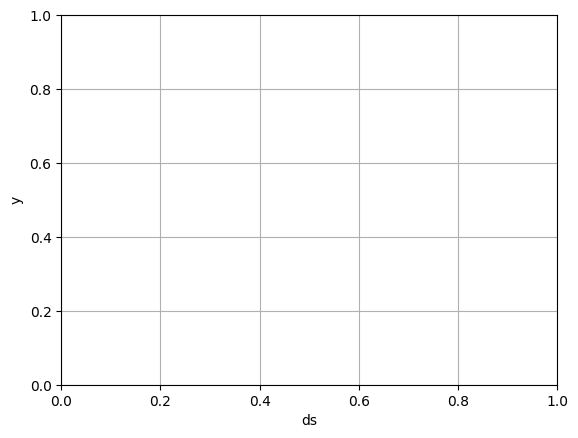

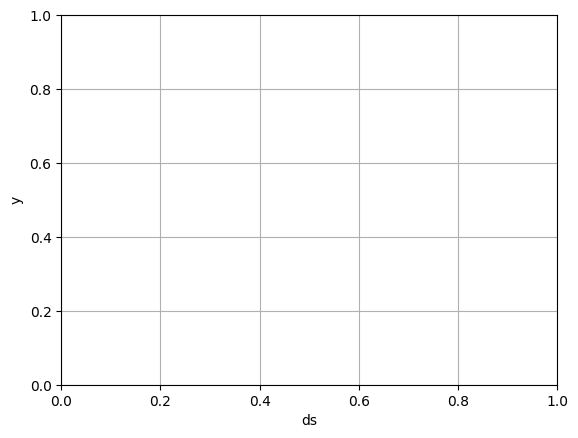

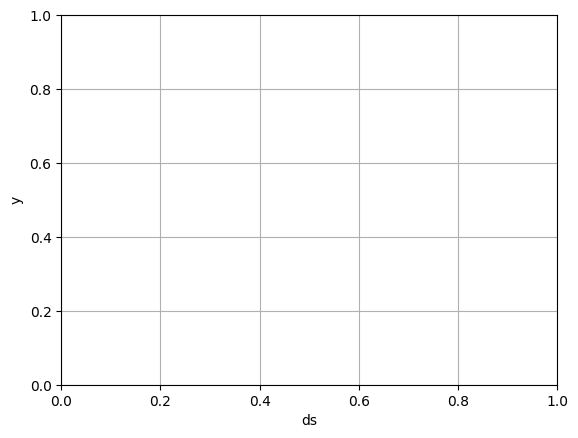

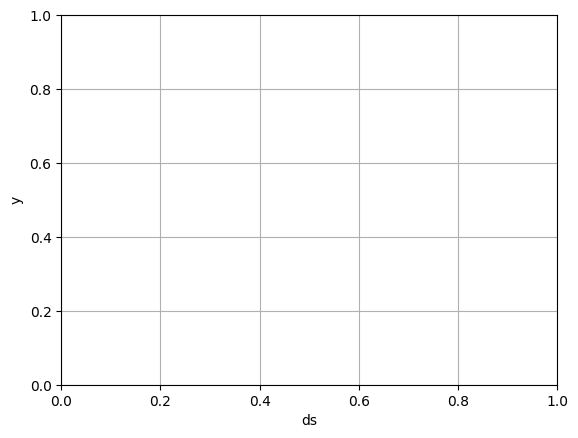

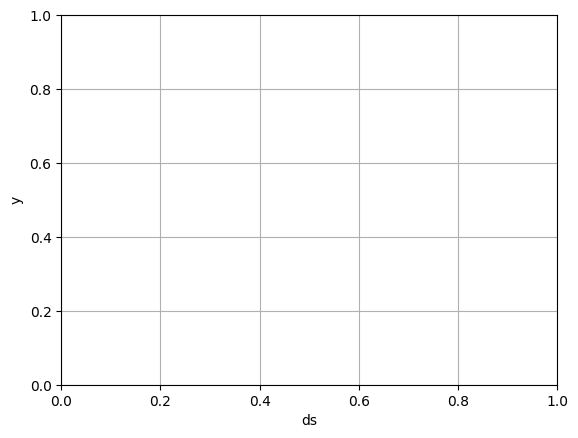

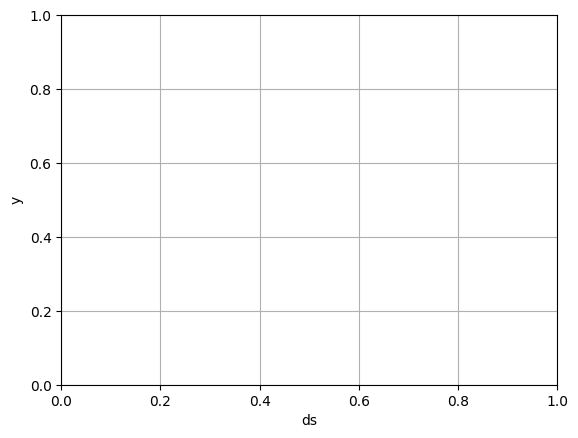

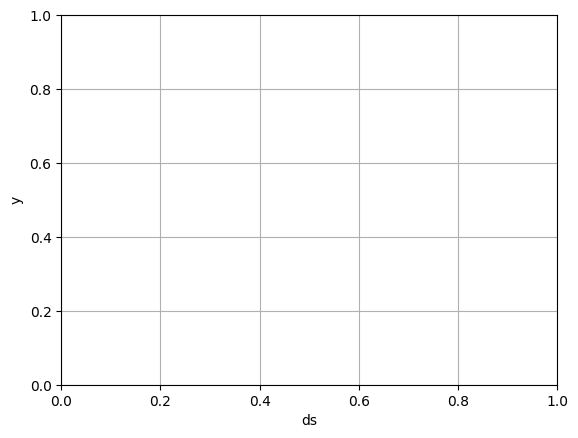

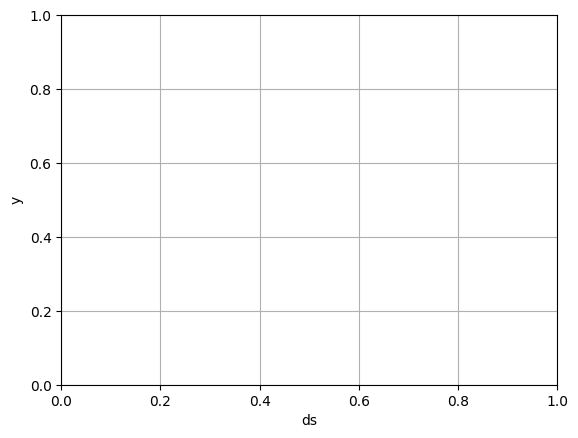

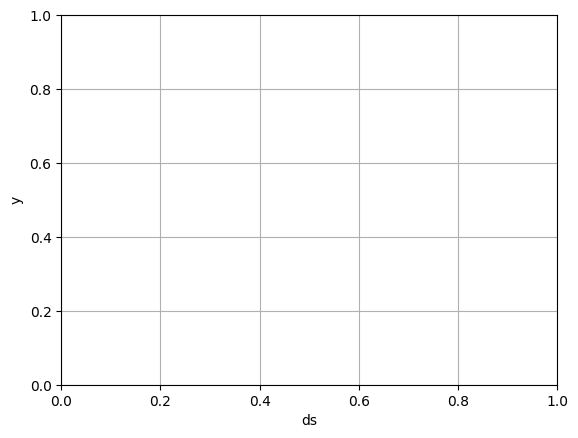

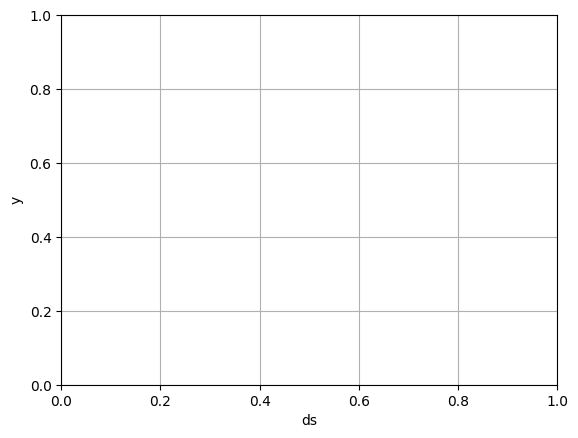

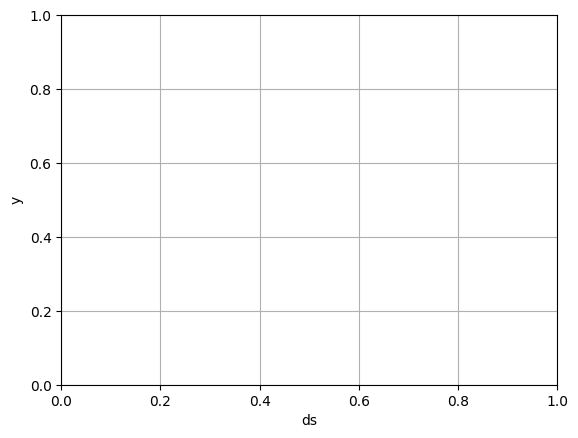

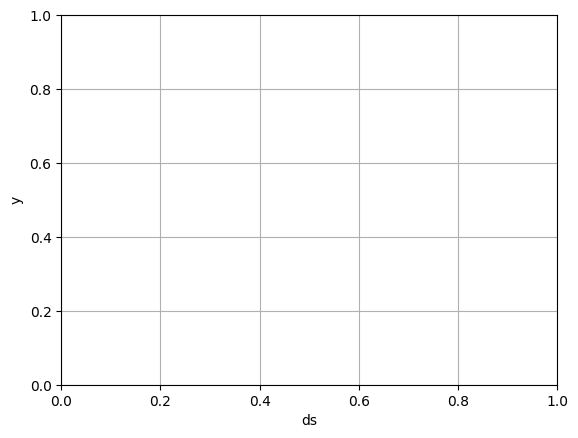

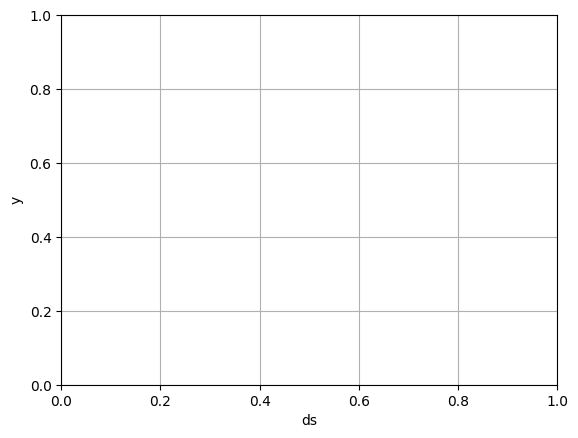

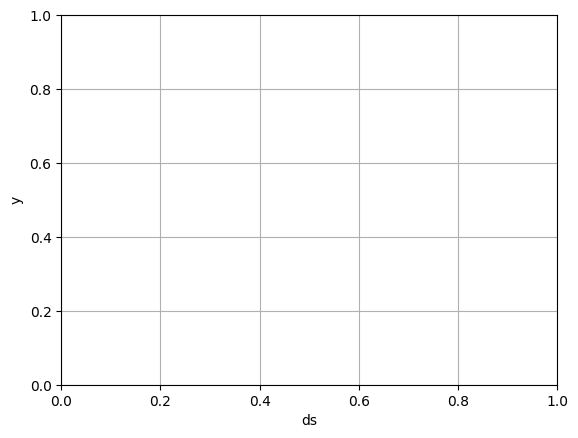

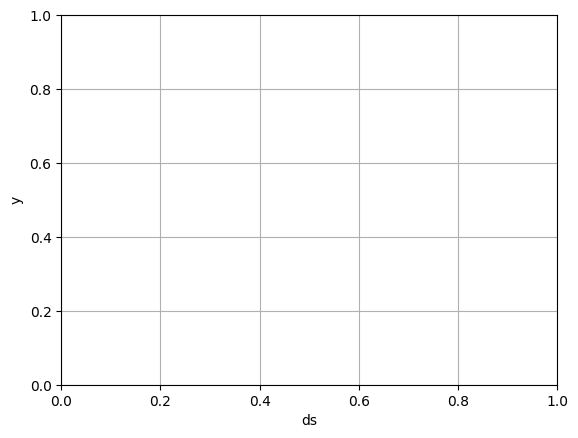

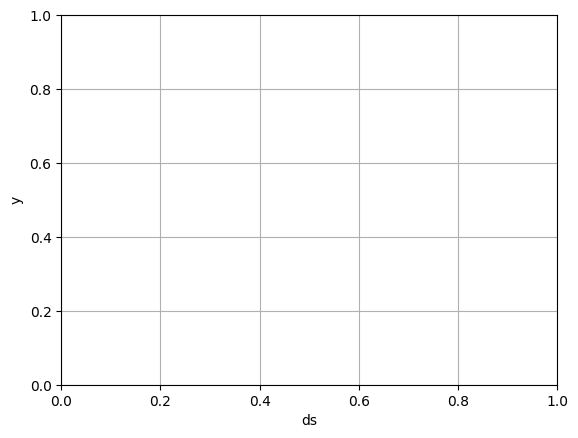

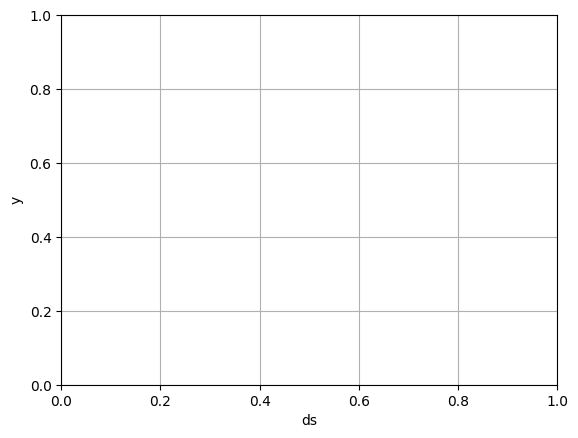

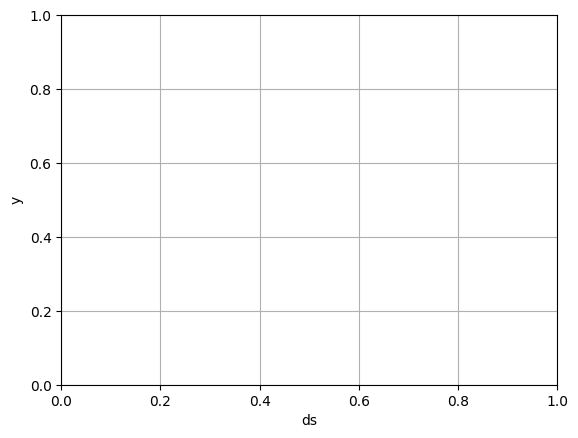

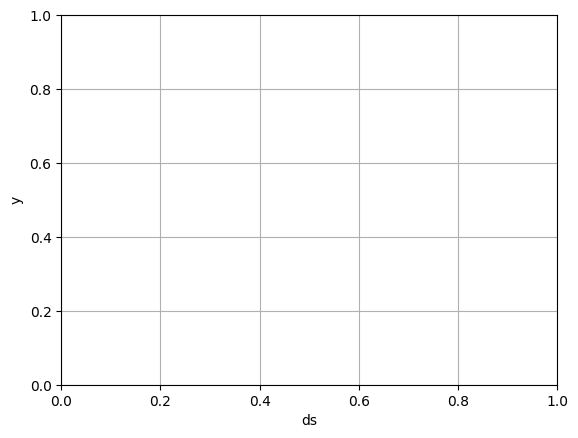

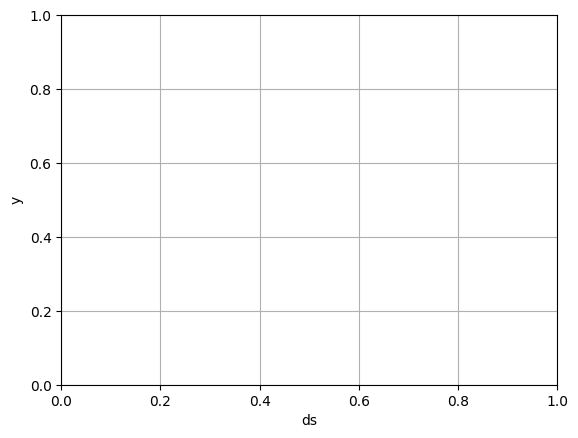

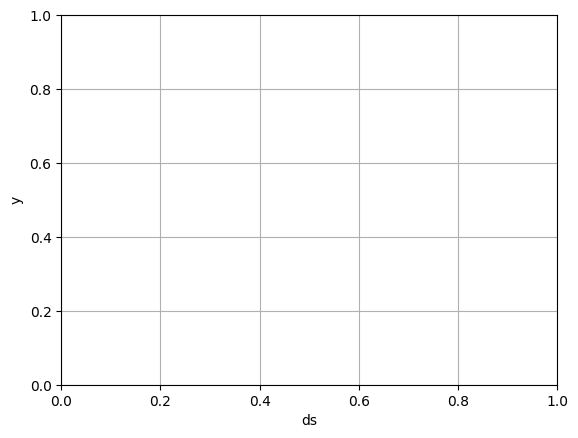

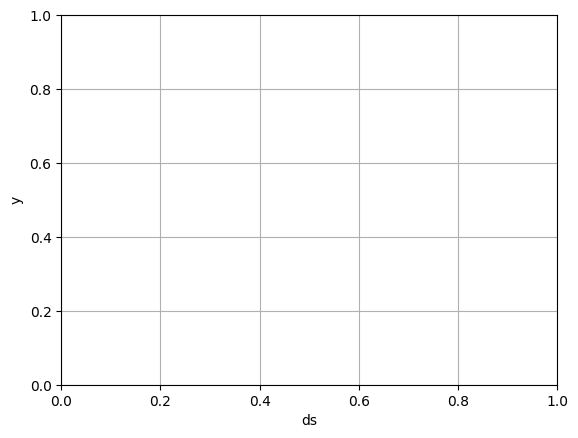

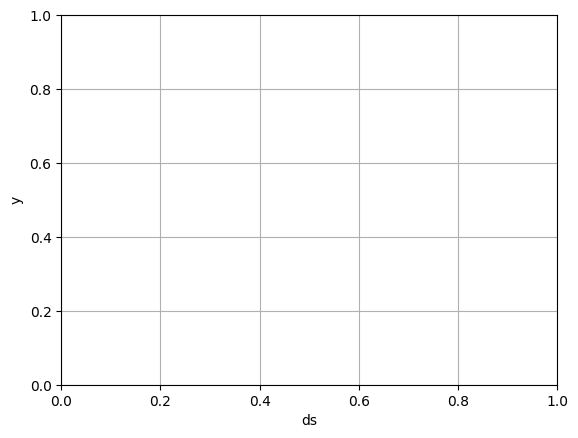

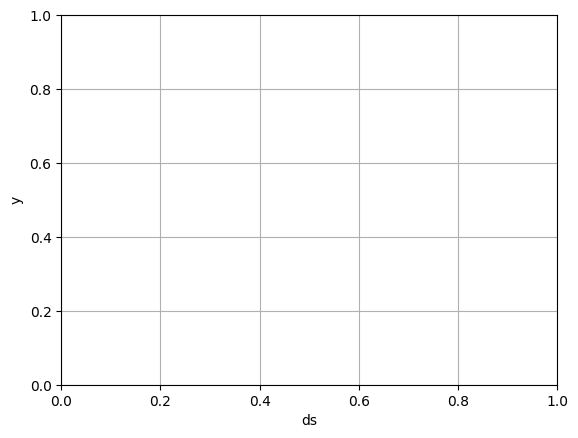

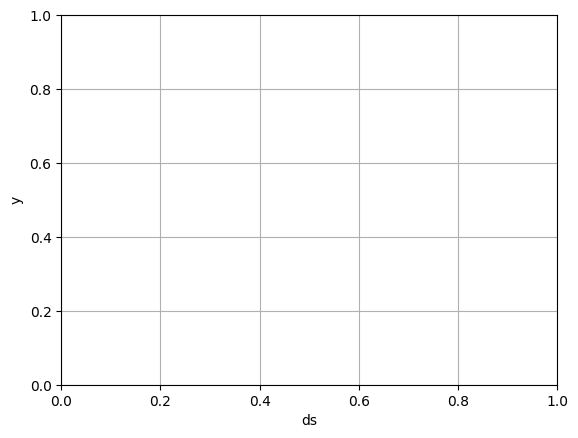

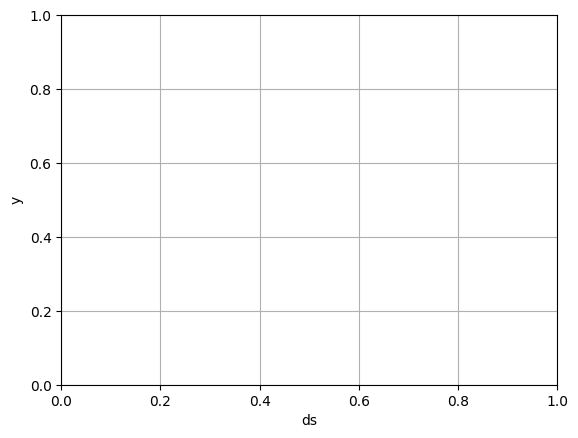

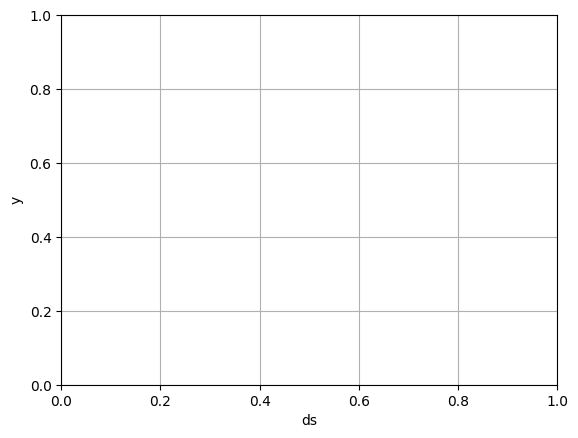

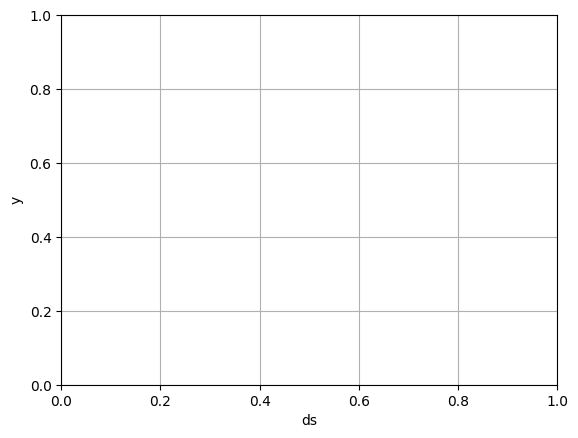

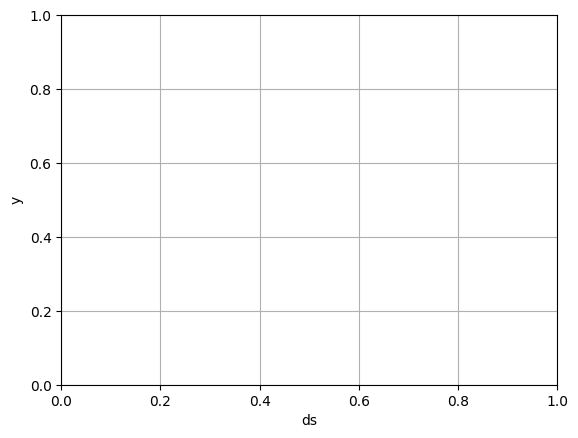

In [12]:
print(f'Значений в выборке {len(data)}')
# Определяем часть, отведённую для обучения

train_part = 9/10
# Для различных мерных интервалов (25%, 50%, 75%, 90%)
for part in [1 / 4, 1 / 2, 3 / 4, train_part]:
    # Определяем границы обучающей выборки
    end = int(train_part * len(data))
    start = int (end - part * len(data))
    print(f'== обучающая выборка {part}')
    print(f'= {start} - {end - 1}')
    # Разбиваем данные на обучающую выборку и тесты
    train = data[start:end]['y'].to_numpy()
    train_date = data[start:end]['ds'].to_numpy()
    test = data[end:]['y'].to_numpy()
    test_date = data[end:]['ds'].to_numpy()


    # Определяем параметры
    best_rmse = float("inf")
    best_params = None
    model, trend_i, rmse = find_model(train, test, 2, part)
    find_season(train, 2, part)
    find_resid(train, 1, part)


    ARIMA
    num=2
    d = 0
    for p in range(1,10,1):
        for q in range(1,10,1):
            _, _, rmse, aic = Arima(train, test, (p, d, q))
            if rmse < best_rmse:
                best_rmse = rmse
                best_params=(p,d,q)

            print(f'Params: {best_params}')
            m, f, rmse, _ = Arima(train, test, best_params)
            print(f'rmse: {rmse}')
            model_data = np.concatenate([m, f])
            model_data=model_data[1::]
            model_dates = np.concatenate([train_date, test_date])
            model_dates=model_dates[1::]
            #print(model_dates,model_data,len(model_dates),len(model_data))

            xs = [data['ds'],train_date, test_date,model_dates]
            ys = [data['y'],train, test,model_data]
            legend = ["original", "train", "test", "model"]

            plot_all(xs, ys, legend, f'ARIMA{num} {best_params} - {part} train') 
            
            xs = [train_date, test_date]
            ys = [train-m, test-f]
            legend = ["test", "model"]
            plot_all(xs, ys, legend, f'ARIMA{num} {best_params} - {part} remainders')       

    print('Обучающие данные:') 
    print(train_date,train)
    print('Тестовые данные:')
    print(test_date,test)
    print('Исходные данные')
    print(data['y'].values,data['ds'].values)
    print('Модель')
    print(test_date,f)


    num=1
    for season in range(30):
        _, _, rmse = bsts(train, test, season)
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = season
        m, f, rmse = bsts(train, test, best_params)
        print("BSTS:", best_params, rmse)
        model_data = np.concatenate([m, f])
        model_dates = np.concatenate([train_date, test_date])
        xs = [data['ds'],train_date, test_date,model_dates]
        ys = [data['y'],train, test,model_data]
        legend = ["original", "train", "test", "model"]
        plot_all(xs, ys, legend, f'BSTS{num} {best_params} - {part} train')

        xs = [test_date]
        ys = [test-f]
        legend = ["train", "test"]
        find_resid(test-f, 1, part)
        plot_all(xs, ys, legend, f'BSTS{num} {best_params} - {part} remainders')


    model = LinearRegression().fit(data.index.values.reshape(-1, 1),data['y'].values)
    trend_l = model.predict(data.index.values.reshape(-1, 1))
    legend = ["original", "train", "test", "model"]
    plot_all(data.index.values,trend_l,legend,f'BSTS{1} {best_params} - {part} train')



    Prophet
    num=2
    for period in range(10, 40):
        m = Model(data.iloc[start:end], period, 2)
        rmse = np.sqrt(mean_squared_error(train, m.model()['yhat'])) ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = period
    best_fourier = None
    best_rmse = float("inf")
    for fourier in range(1, 4):
        m = Model(data.iloc[start:end], best_params, fourier)
        rmse = np.sqrt(mean_squared_error(train, m.model()['yhat'])) ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_fourier = fourier
    print(best_params, best_fourier, best_rmse)
    m = Model(data.iloc[start:end], best_params, best_fourier)
    m_val = m.model()['yhat'].to_numpy()
    forecast = m.forecast(len(test))
    merged = pd.concat([m.model(), forecast],
                                ignore_index=True, sort=False)
    m_for = forecast['yhat'].to_numpy()
    xs = [data['ds'], train_date, test_date, merged['ds']]
    ys = [data['y'], train, test, merged['yhat']]
    legend = ["original", "train", "test", "model"]
    plot_all(xs, ys, legend, f'Prophet{num} {best_params} {best_fourier} - {part} train')

    xs = [train_date, test_date]
    ys = [train-m_val, test_m_for]
    legend = ["train", "test"]
    plot_all(xs, ys, legend, f'Prophet{num} {best_params} {best_fourier} - {part} remainders')